In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import time

In [3]:
file_path = "Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.0001.csv"
data = pd.read_csv(file_path)
filtered_data = data[data['PEEQ'] <= 3]
PEEQ = filtered_data["PEEQ"].to_numpy()
PEEQ_fit = np.linspace(np.min(PEEQ), np.max(PEEQ), 200)

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\260840761.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lambda x, a, b, c, d, e, f, g, h, i, j: combined_fit(x, a, b, c, d, e, f, g, h, i, j, parameter), x, y, maxfev=100000, **fit_kwargs)


Parameter: C1, R^2: 0.9974, Coefficients: [1.08145587 0.78965719 0.21740676 1.87356006 0.87606501 0.7820831
 1.         1.         1.         1.        ]


C:\Users\meian\AppData\Local\Temp\ipykernel_7496\260840761.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lambda x, a, b, c, d, e, f, g, h, i, j: combined_fit(x, a, b, c, d, e, f, g, h, i, j, parameter), x, y, maxfev=100000, **fit_kwargs)
C:\Users\meian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Parameter: C2, R^2: 0.9897, Coefficients: [ 0.53668693  0.42952256  0.07457646  0.01298091 -0.50495733  0.58711332
  1.          1.          1.          1.        ]
Parameter: C3, R^2: 0.9828, Coefficients: [-5.85082433e-01  1.25025809e-01  7.04781939e-01  6.43587767e-01
  4.81364621e+01  4.25272120e-01  3.46282091e-02  3.23634353e+00
  2.70196837e-01  1.04829692e+02]
Parameter: C4, R^2: 0.9800, Coefficients: [0.20101043 3.67748081 0.21212239 0.32354562 0.71065618 0.17901846
 1.         1.         1.         1.        ]


C:\Users\meian\AppData\Local\Temp\ipykernel_7496\260840761.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(lambda x, a, b, c, d, e, f, g, h, i, j: combined_fit(x, a, b, c, d, e, f, g, h, i, j, parameter), x, y, maxfev=100000, **fit_kwargs)


Parameter: C5, R^2: 0.9900, Coefficients: [ 6.36553519e+01  2.39708812e-35  3.50928726e-01 -9.02961765e+01
  1.85215865e+02  1.73700428e+01  8.17912594e-01  3.44430237e-01
  1.05048593e+03  2.32750448e-22]
Parameter: C6, R^2: 0.9667, Coefficients: [ 6.84205965e+01  2.96842644e-03  2.02723107e-02 -2.80148936e+02
  8.79345047e+03  7.97165392e+01  1.05012912e-34  4.41175467e-01
  3.00522143e+02  3.62864163e+00]


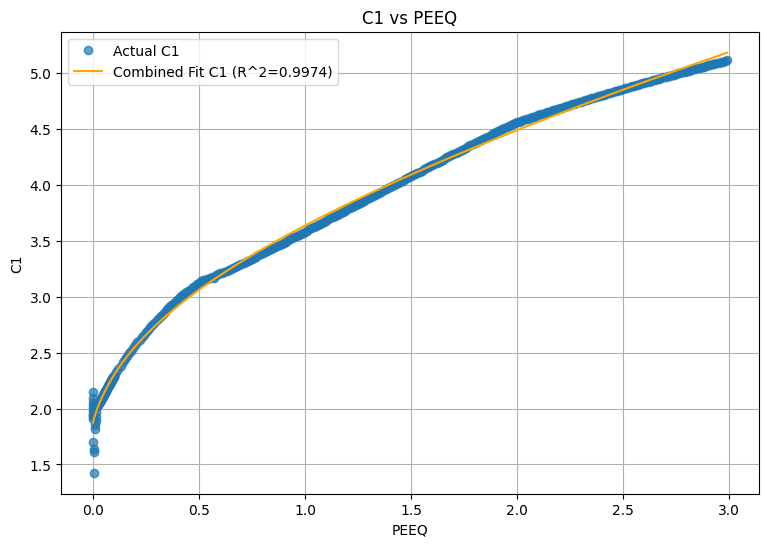

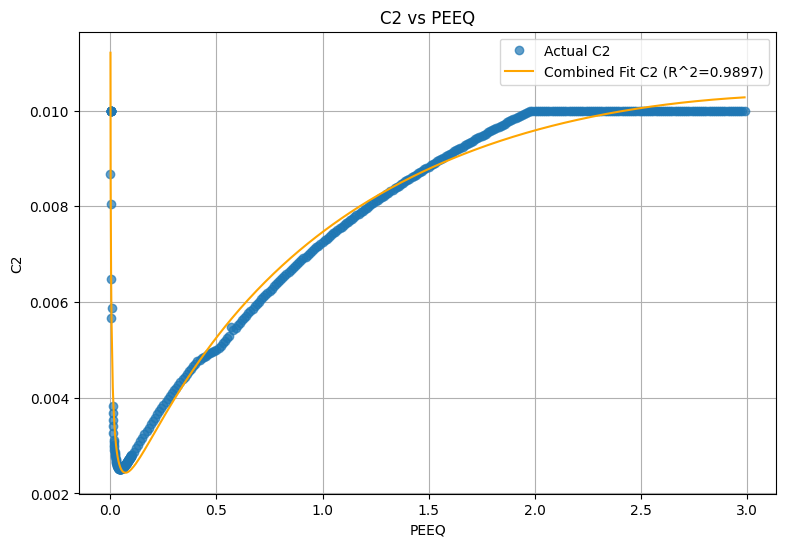

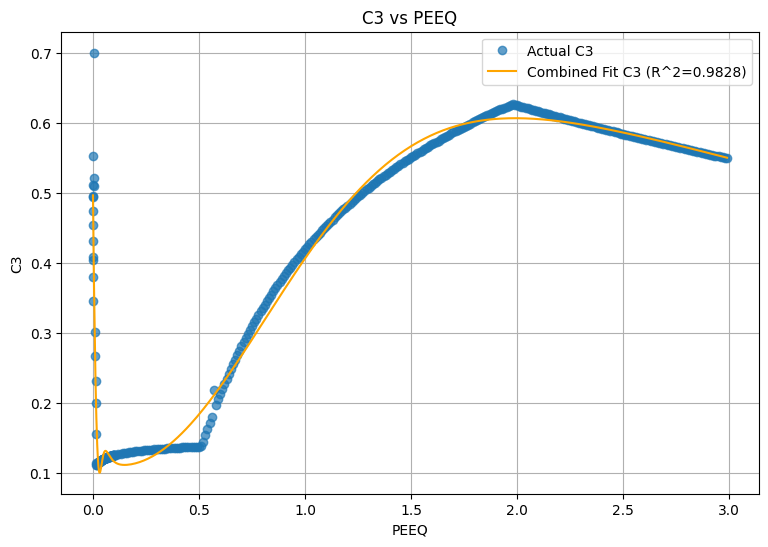

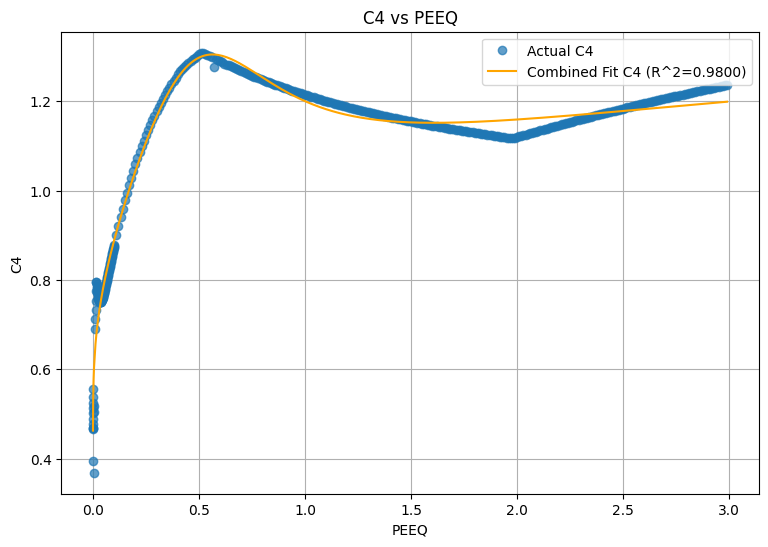

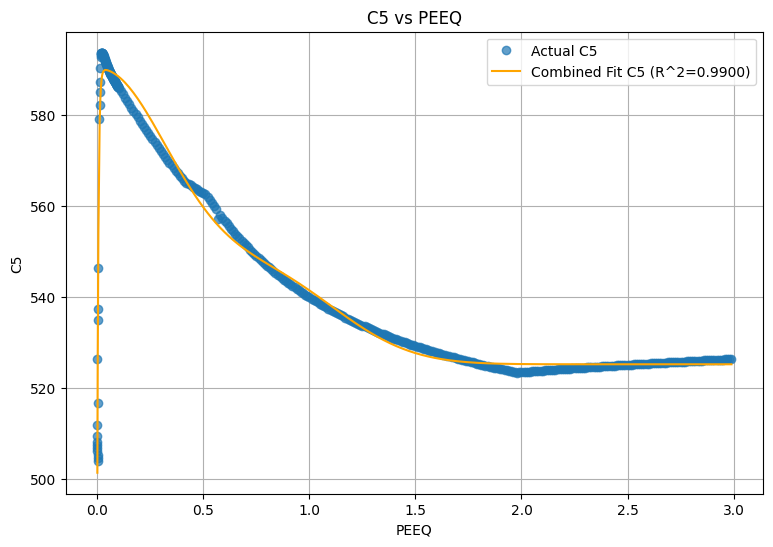

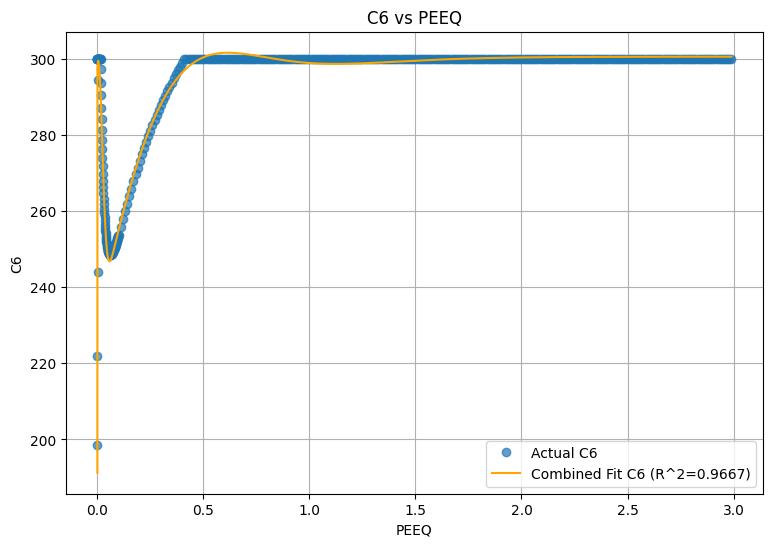

In [4]:
df_para_fit = pd.DataFrame(PEEQ, columns=["PEEQ"])

# Define the combined polynomial + exponential function
def combined_fit(x, a, b, c, d, e, f, g, h, i, j, C):
    if C == 'C4' or C == 'C2' or C == 'C1':
        return (a*x)/(x**b + c) + d + e * (x**f)
    else:
        gaussian1 = a * np.exp(-((x - b)**2) / (2 * c**2))  # First Gaussian for initial increase
        decay = d * np.exp(-e * x)  # Exponential decay for rapid drop
        gaussian2 = f * np.exp(-((x - g)**2) / (2 * h**2))  # Second Gaussian for the rise
        logistic = i / (1 + np.exp(-j * (x - g)))  # Logistic function for final leveling off
        return gaussian1 + decay + gaussian2 + logistic

# Function to fit the combined model and calculate R^2 score
def fit_combined_model(data, parameter):
    x = data['PEEQ']
    y = data[parameter]
    
    # Apply initial guesses and bounds only for 'C5' and 'C6'
    if parameter in ['C5', 'C6']:
        initial_guess = [10, 0.002, 0.001, -150, 5, 200, 1.5, 0.2, 300, 1]  # Adjusted initial guesses
        bounds = ([-np.inf, 0, 0.001, -np.inf, 0, 0, 0, 0.001, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        fit_kwargs = {'p0': initial_guess, 'bounds': bounds}
    else:
        fit_kwargs = {}  # No initial guess or bounds for other parameters

    # Fit the combined model
    try:
        popt, _ = curve_fit(lambda x, a, b, c, d, e, f, g, h, i, j: combined_fit(x, a, b, c, d, e, f, g, h, i, j, parameter), x, y, maxfev=100000, **fit_kwargs)
        y_pred = combined_fit(x, *popt, parameter)
        r2 = r2_score(y, y_pred)
    except RuntimeError:
        popt = None
        y_pred = None
        r2 = -np.inf  # Indicate failed fit
    
    if popt is not None:
        print(f'Parameter: {parameter}, R^2: {r2:.4f}, Coefficients: {popt}')
    else:
        print(f'Parameter: {parameter} - Fit failed')
    
    return popt, y_pred, r2

# List of parameters to fit
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for i, param in enumerate(parameters):
    popt, y_pred, r2 = fit_combined_model(data, param)
    x = data['PEEQ']
    y_actual = data[param]
    df_para_fit[param] = y_pred
    
    # Fit models and plot results
    plt.figure(figsize=(9,6))
    plt.plot(x, y_actual, 'o', label=f'Actual {param}', alpha=0.7)
    
    # Plot fitted combined model if successful
    if y_pred is not None:
        plt.plot(x, y_pred, '-', color='orange', label=f'Combined Fit {param} (R^2={r2:.4f})')
    
    plt.xlabel('PEEQ')
    plt.ylabel(param)
    plt.title(f'{param} vs PEEQ')
    plt.legend()
    plt.grid(True)

plt.show()

In [5]:
df_para_fit.to_csv('para_fit_results_0.0001.csv', index=False)
# Assuming the file is one level up from the current directory
file_path = "Fitted_FC_TmpDpn_RD_StrRt0.0001_ref.csv"
stress_data = pd.read_csv(file_path)

fitted_para = pd.read_csv('para_fit_results_0.0001.csv')

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


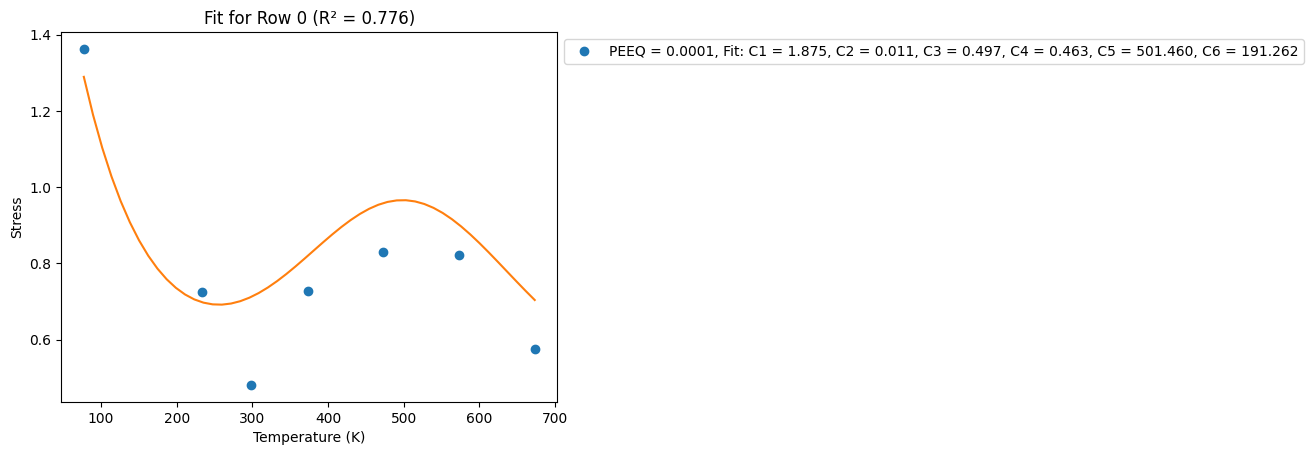

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


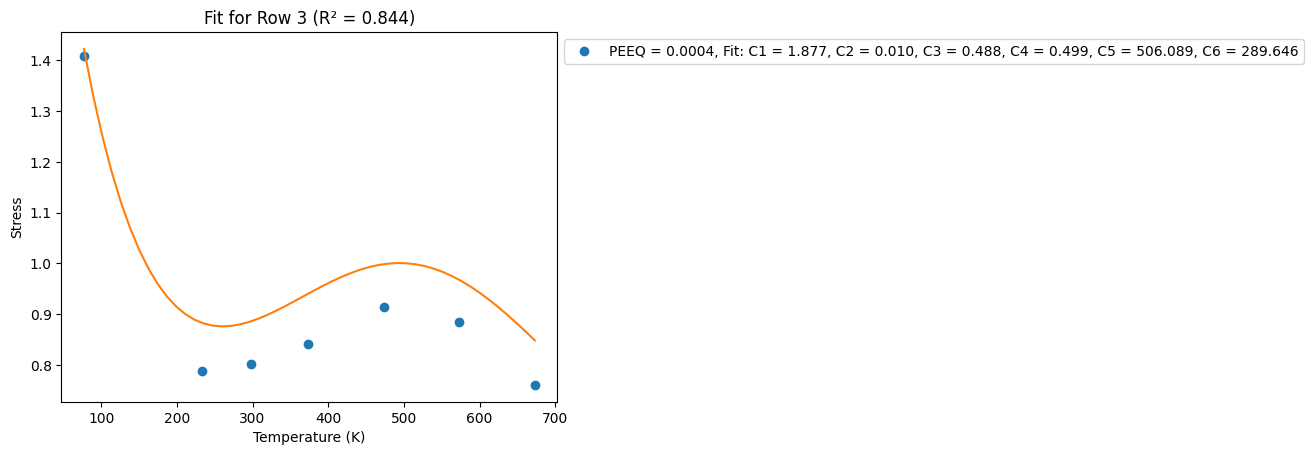

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


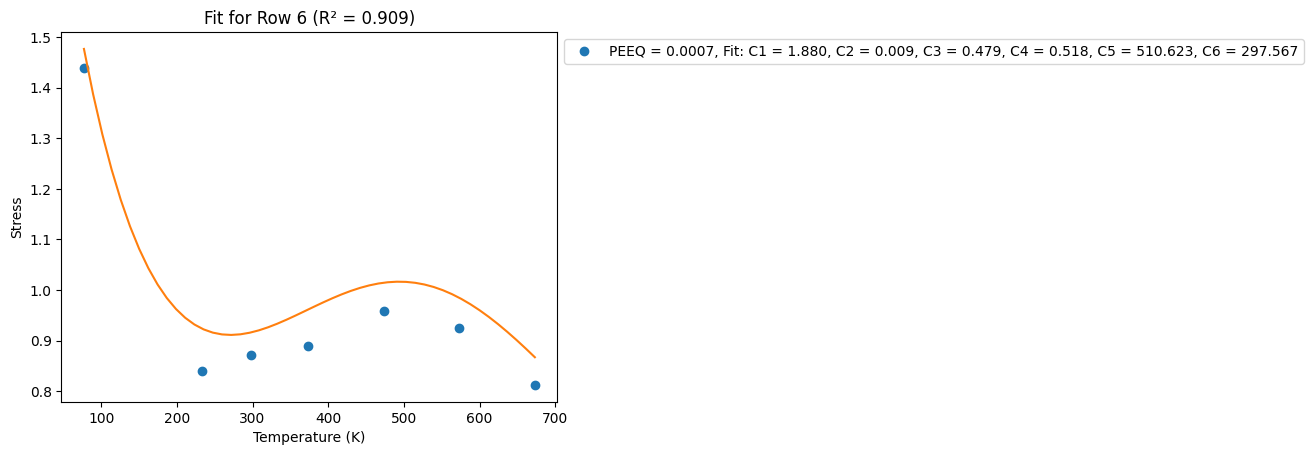

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


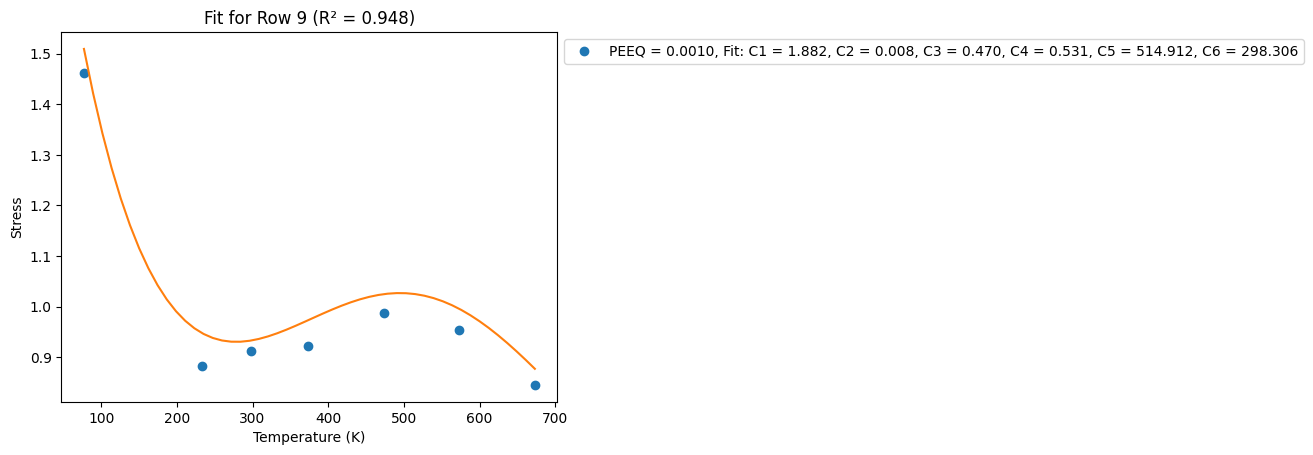

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


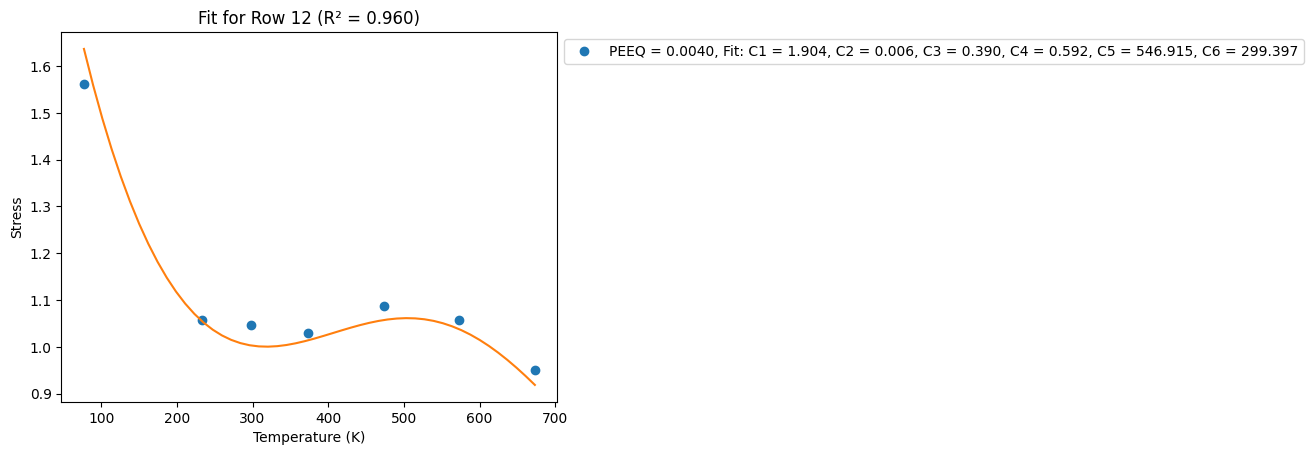

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


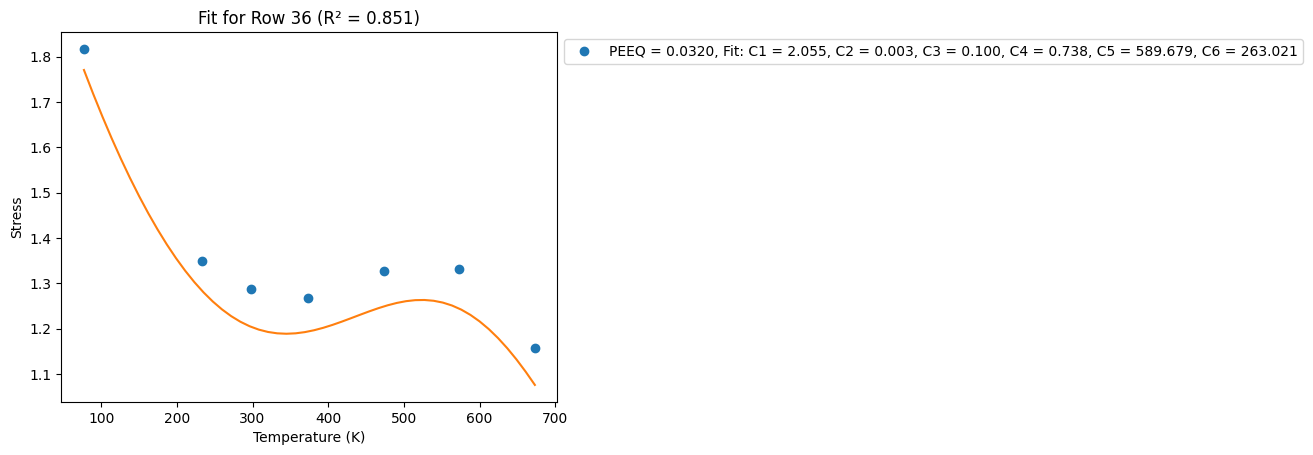

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


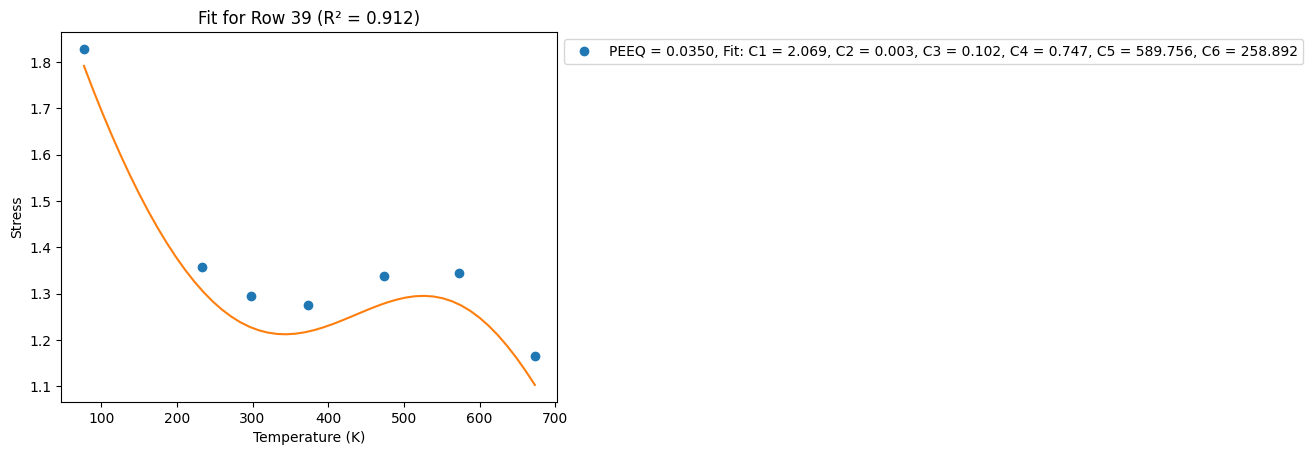

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


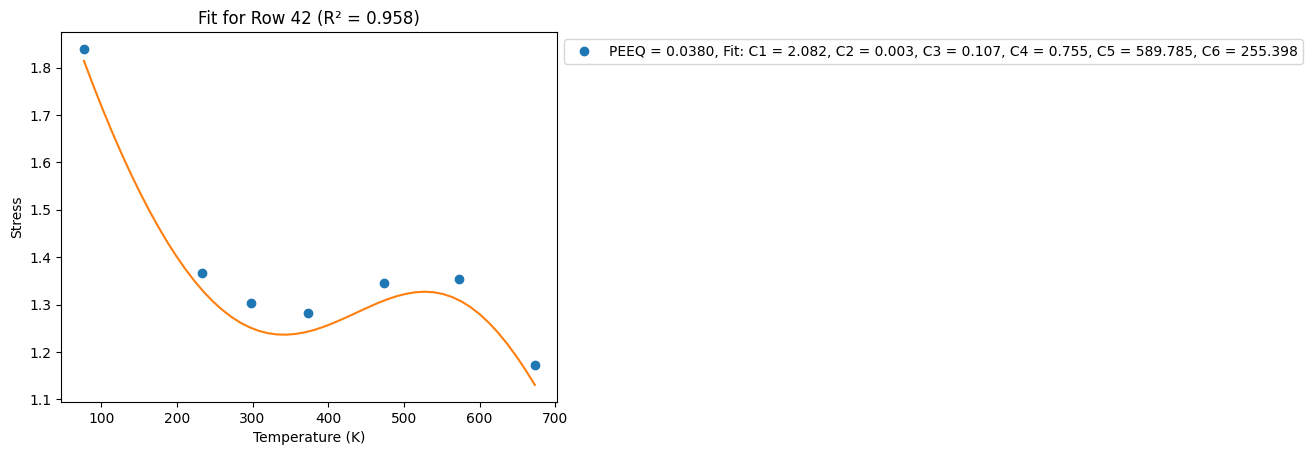

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


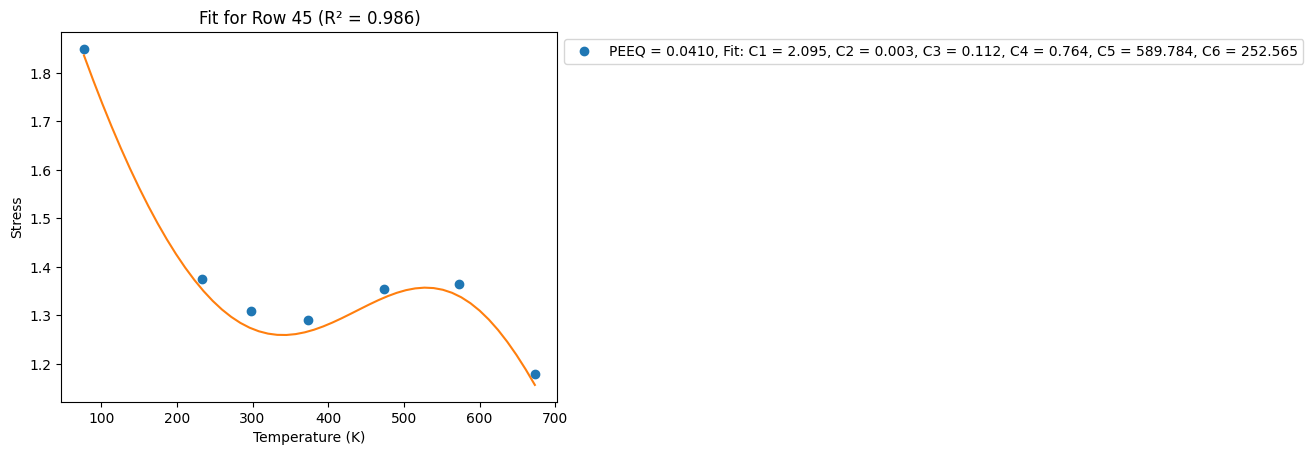

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


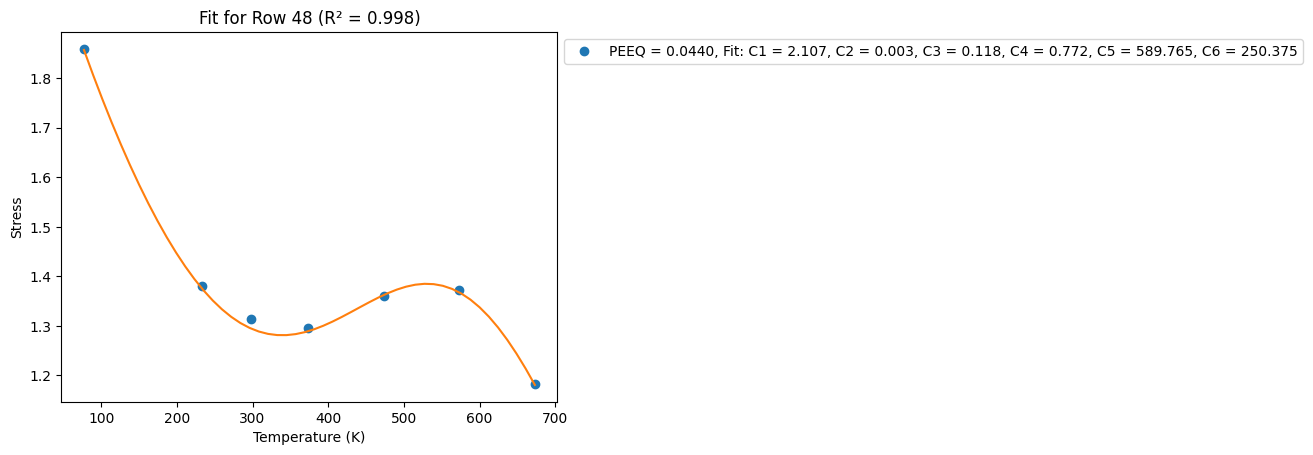

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


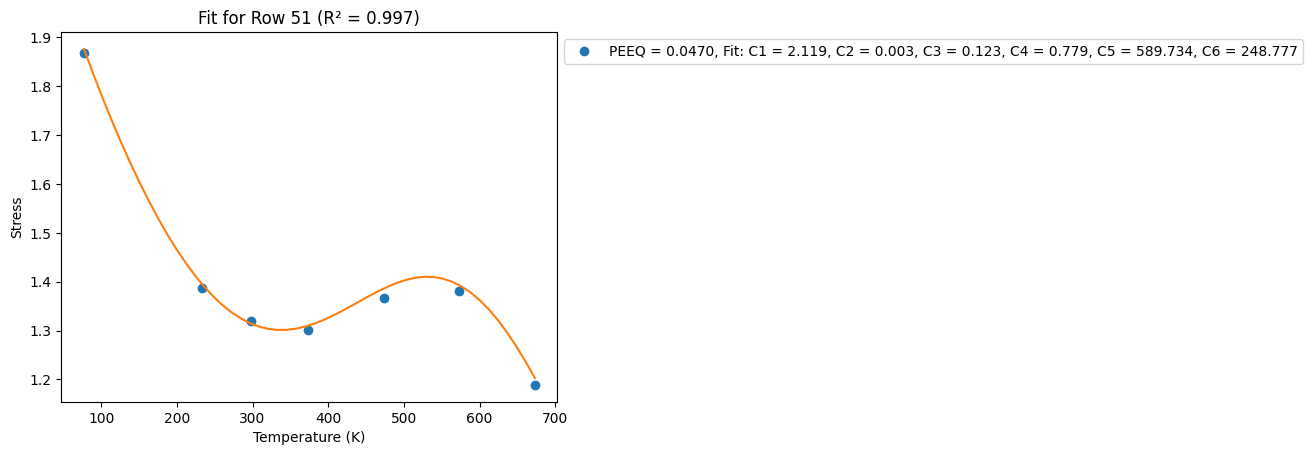

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


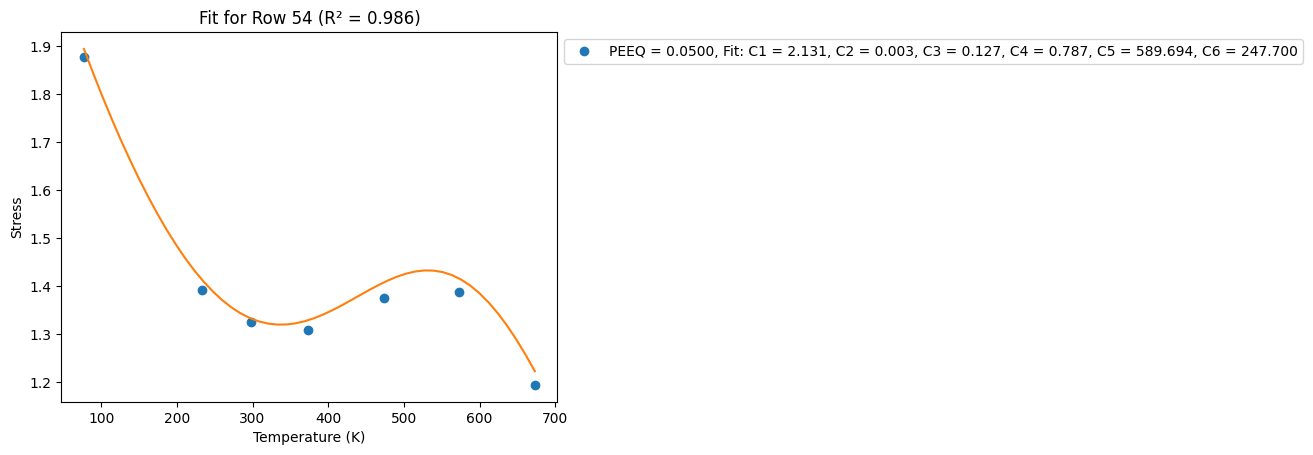

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


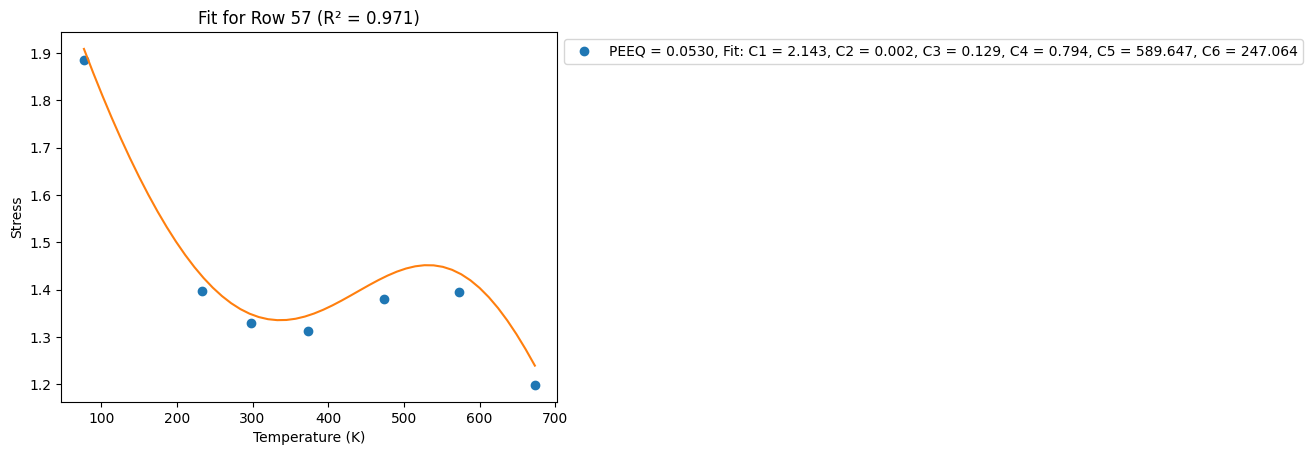

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


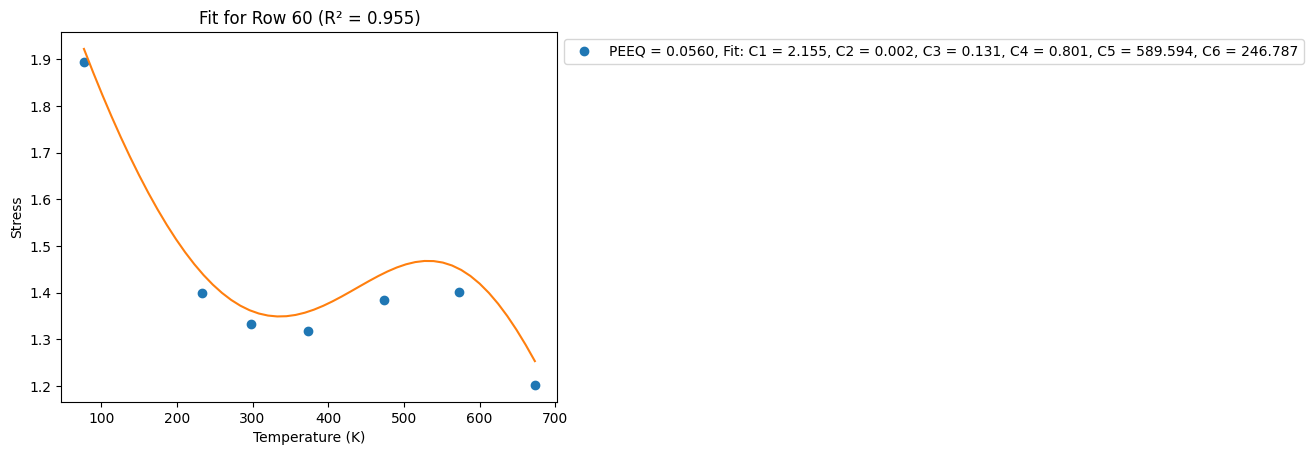

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


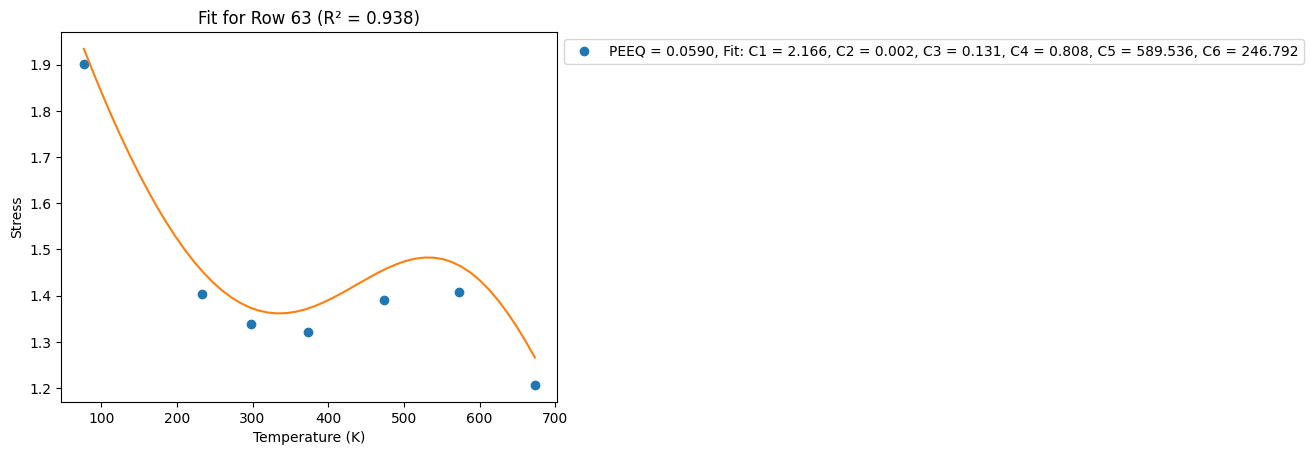

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


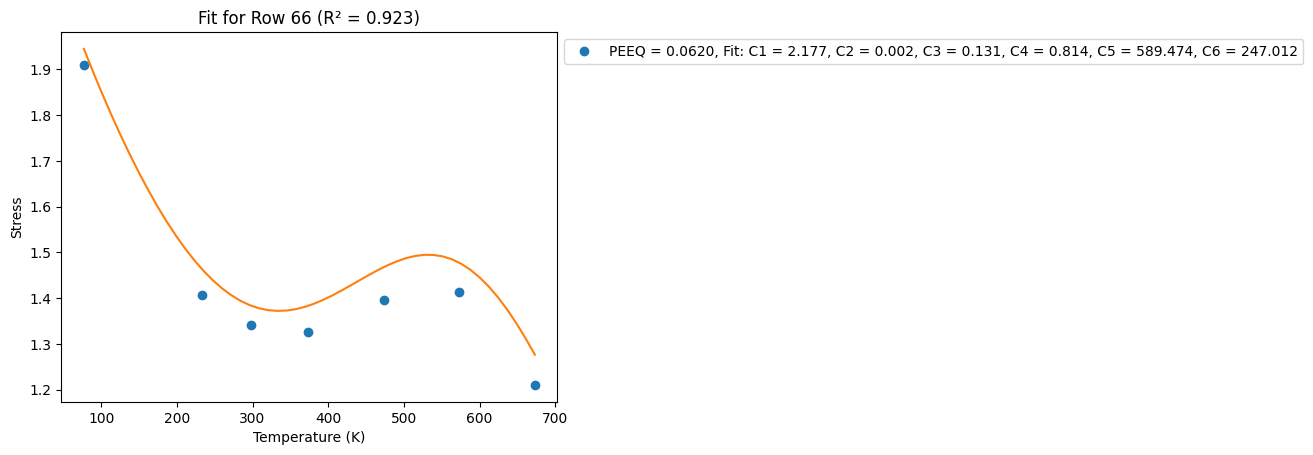

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


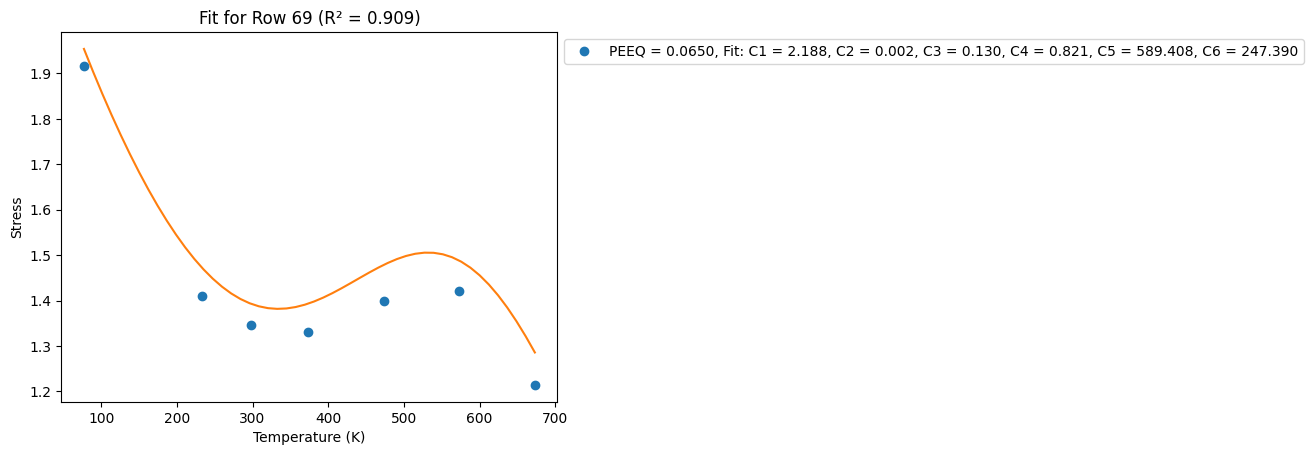

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


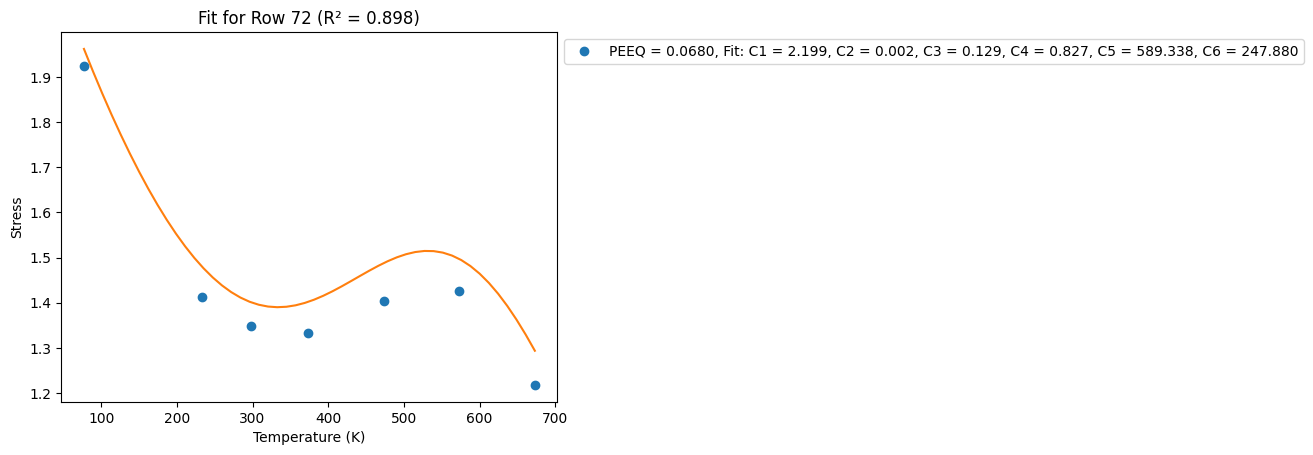

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


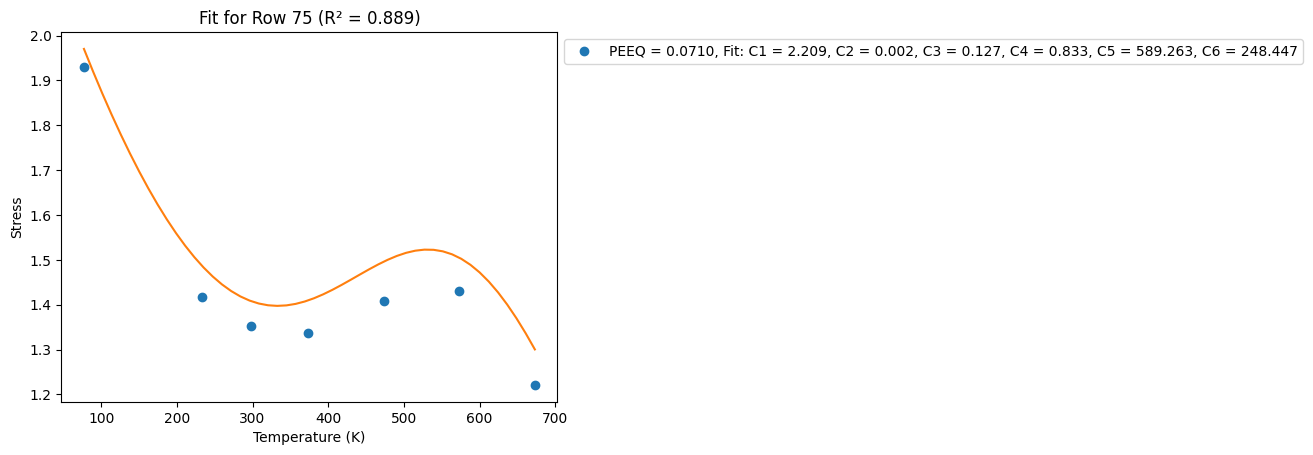

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


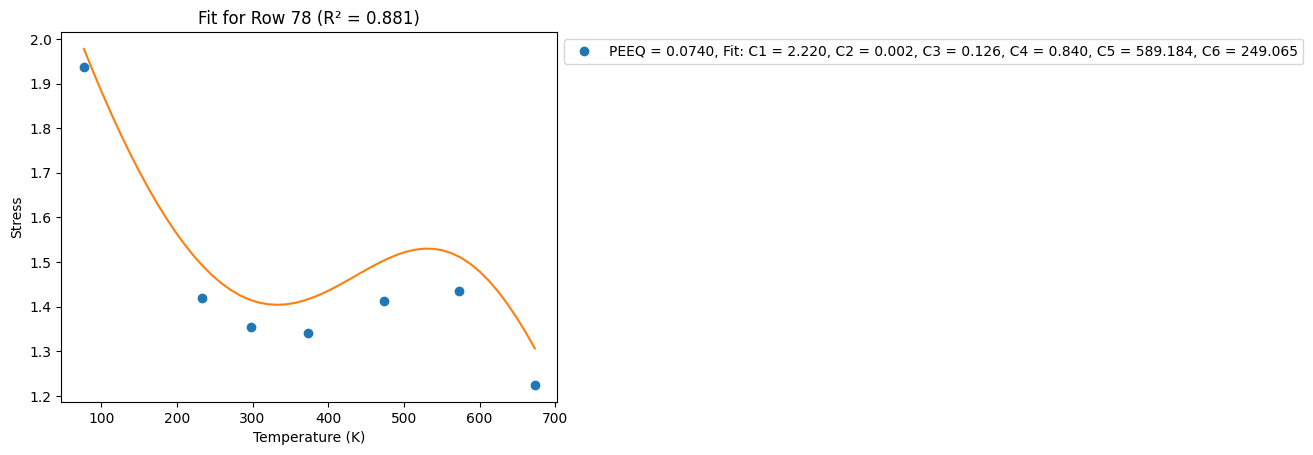

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


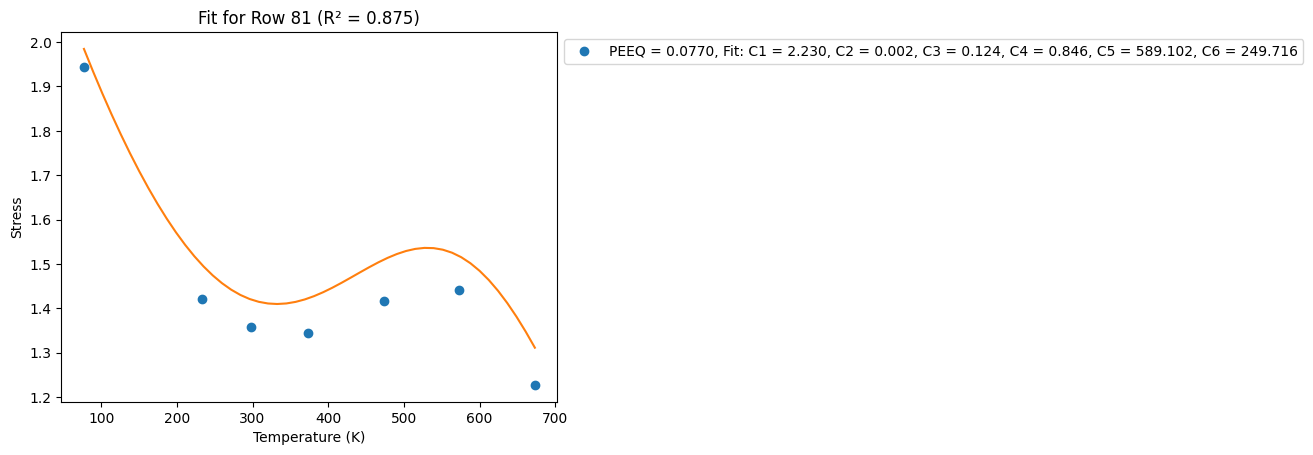

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


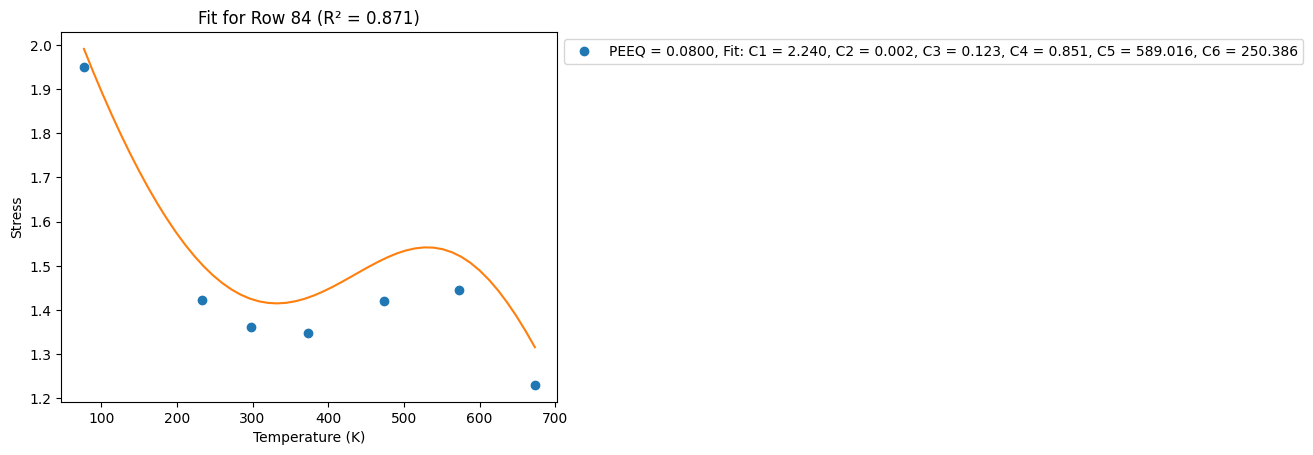

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


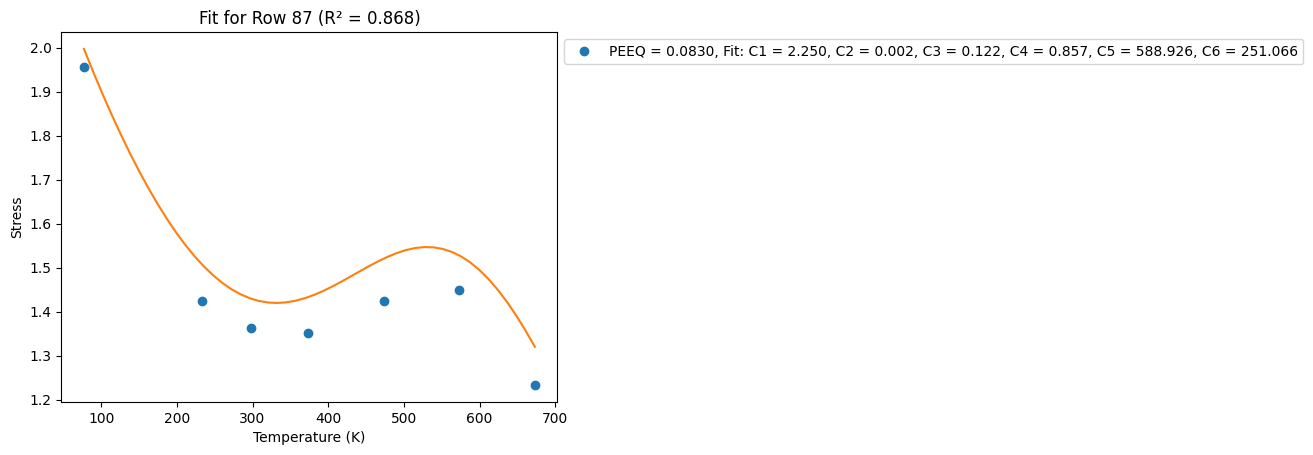

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


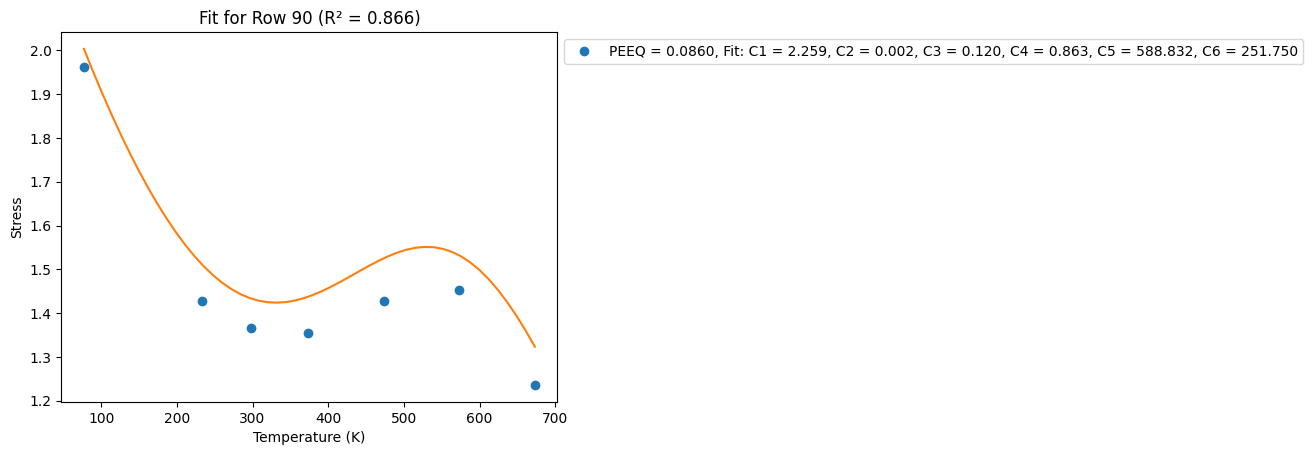

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


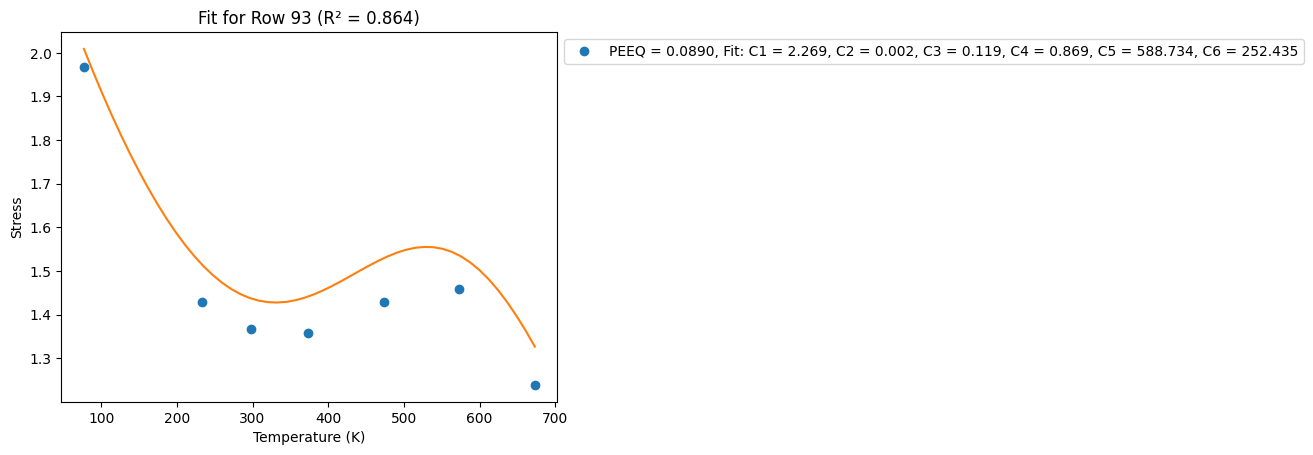

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


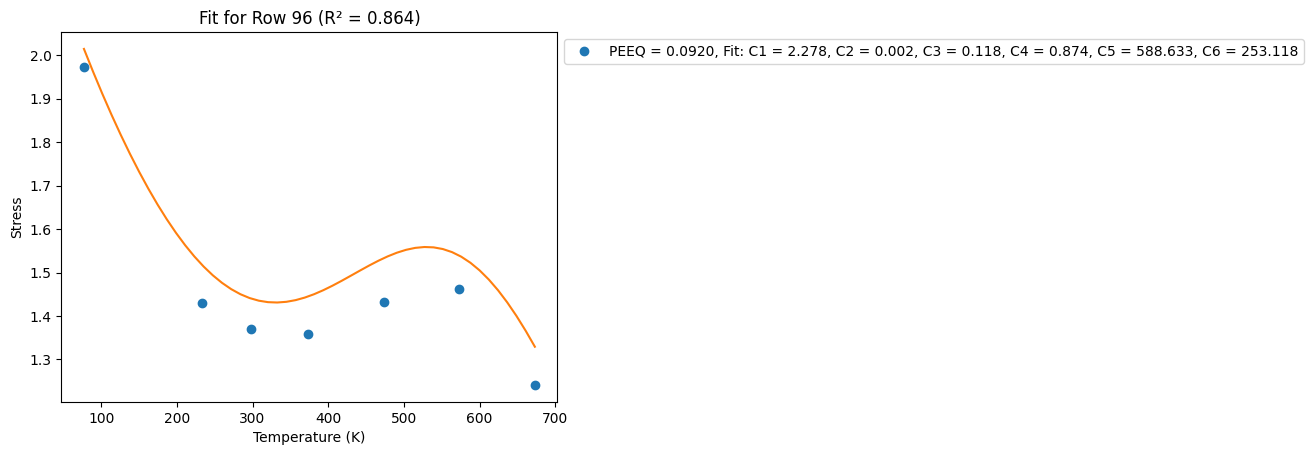

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


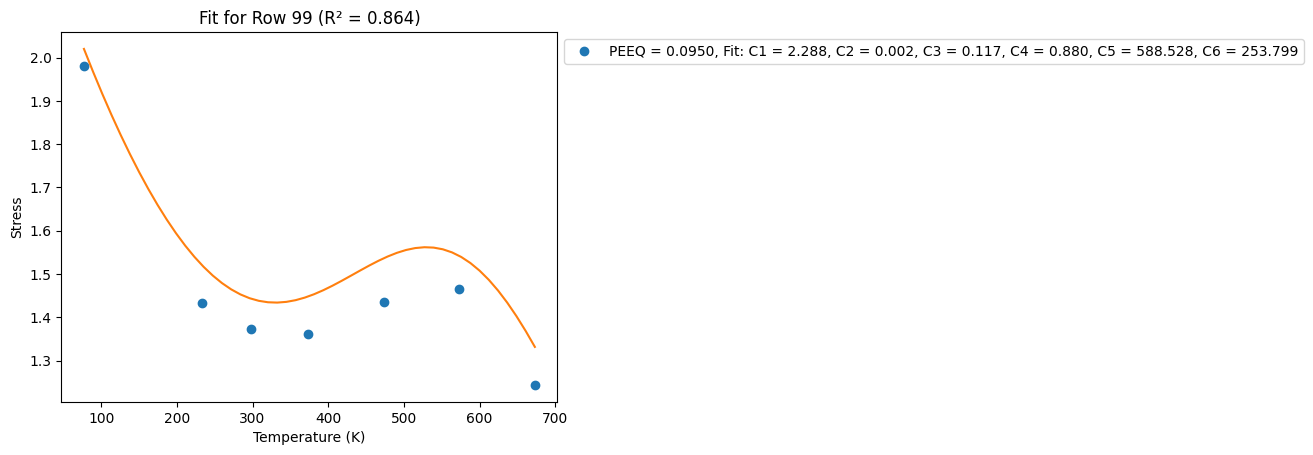

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


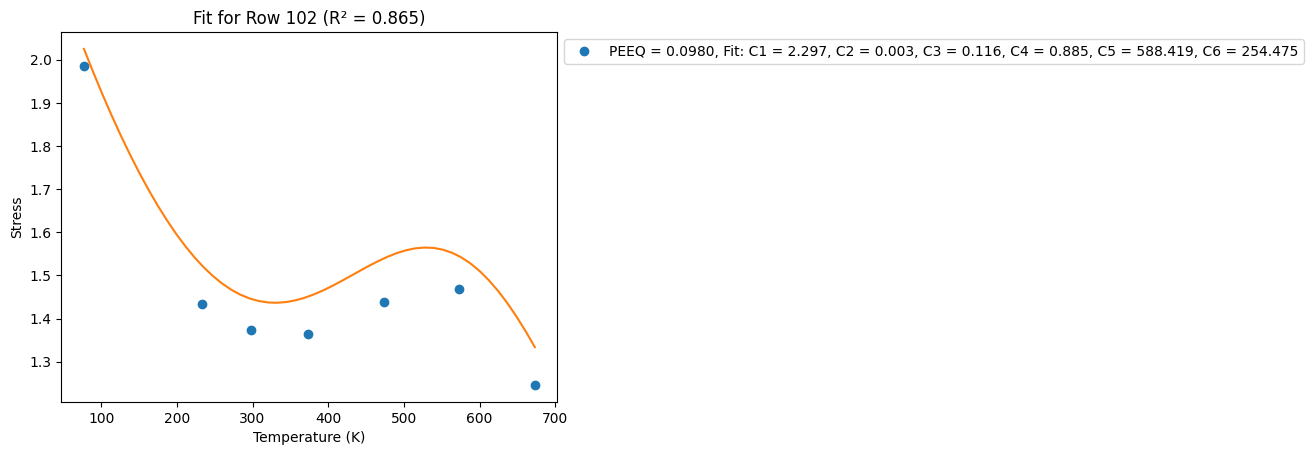

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


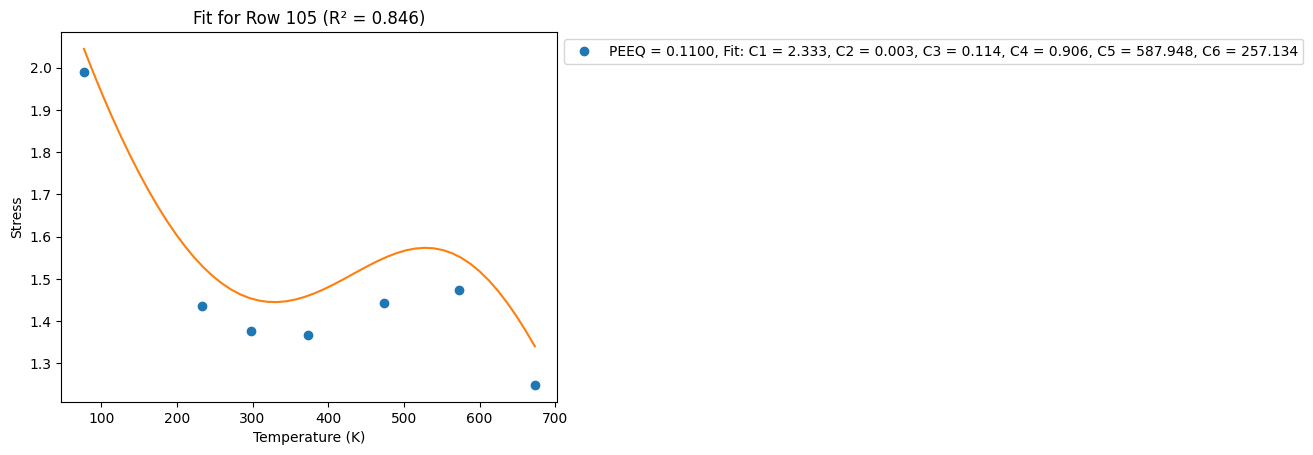

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


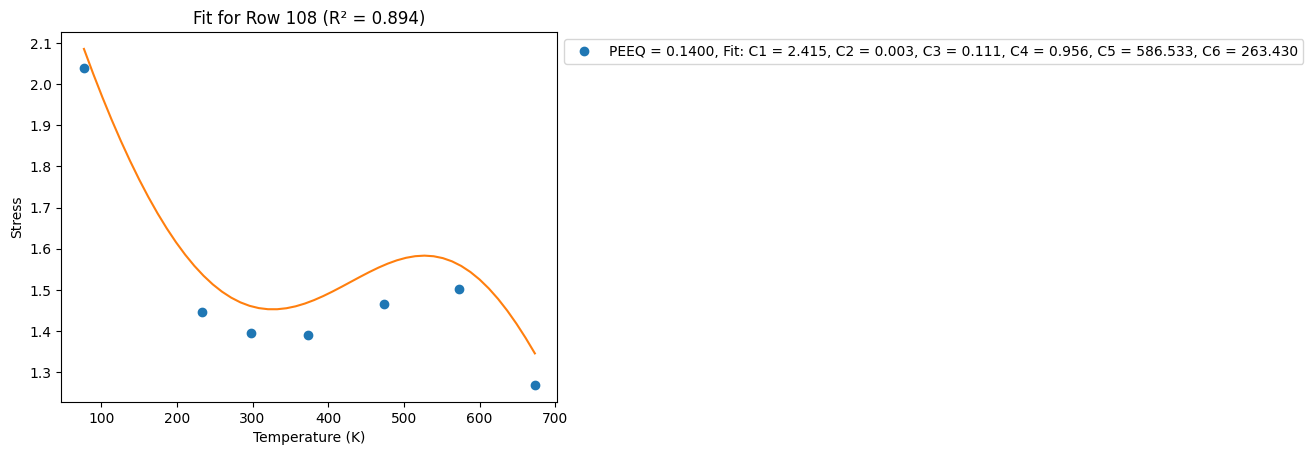

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


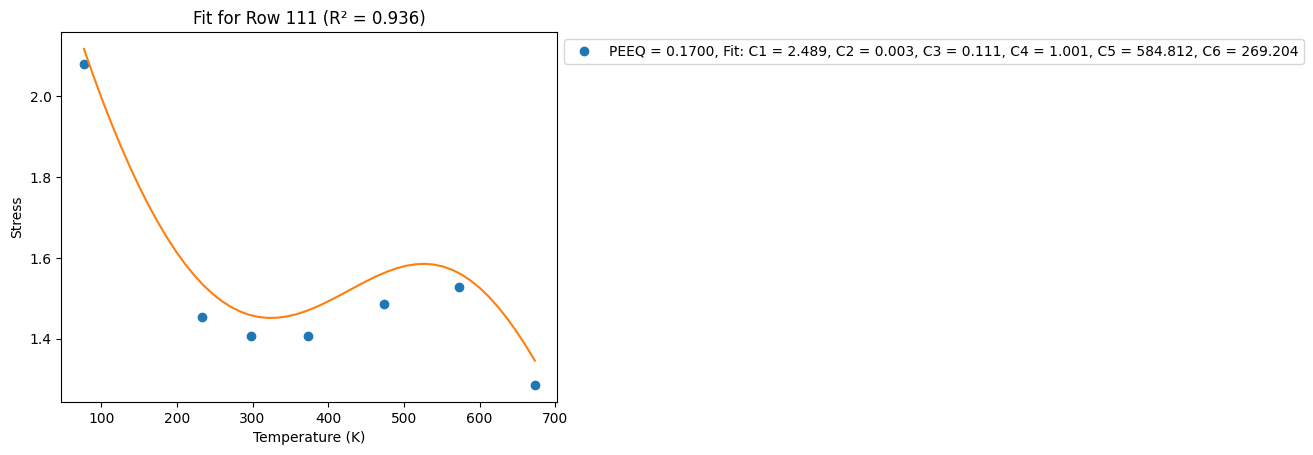

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


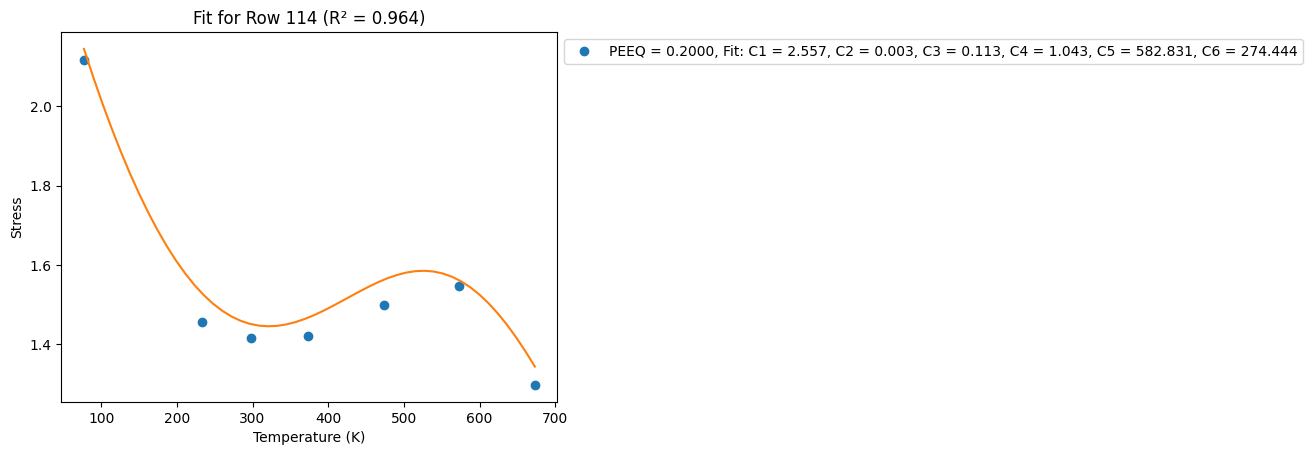

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


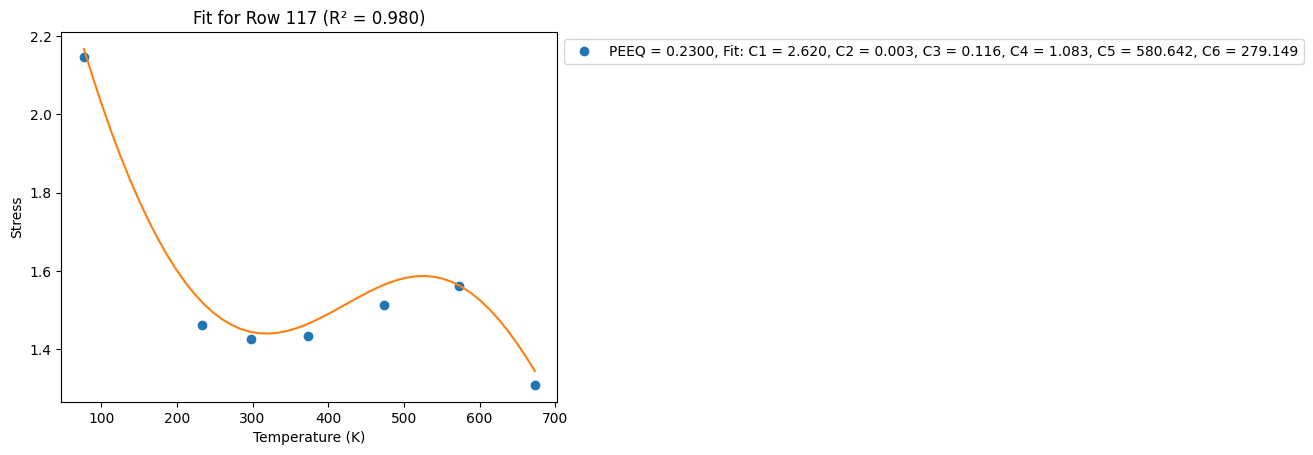

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


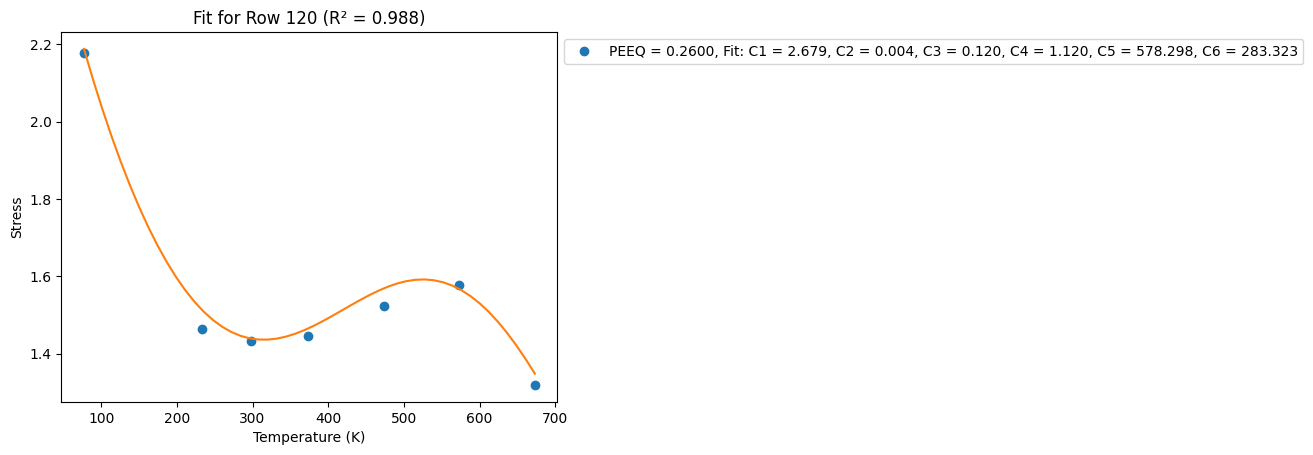

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


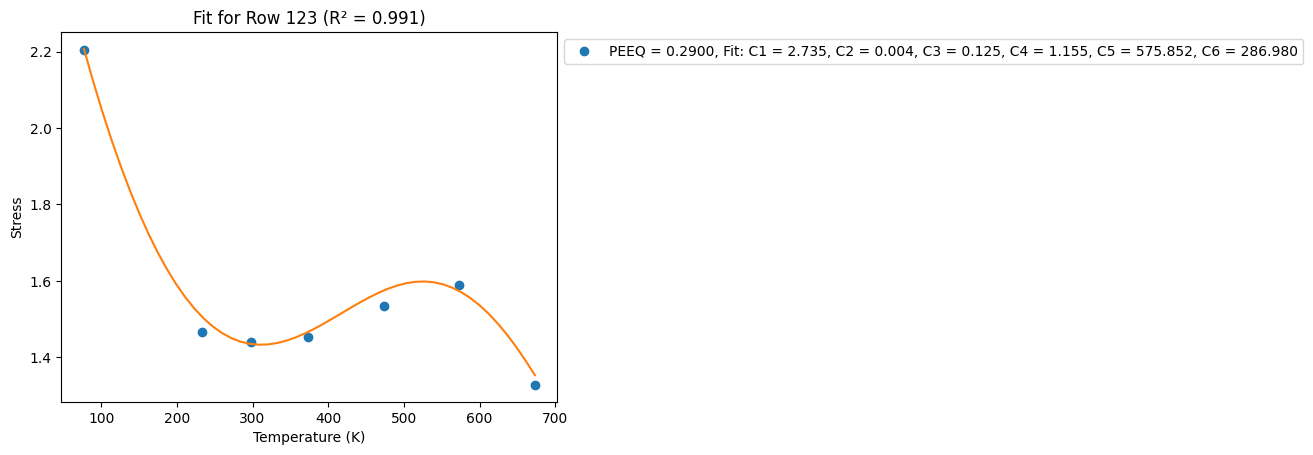

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


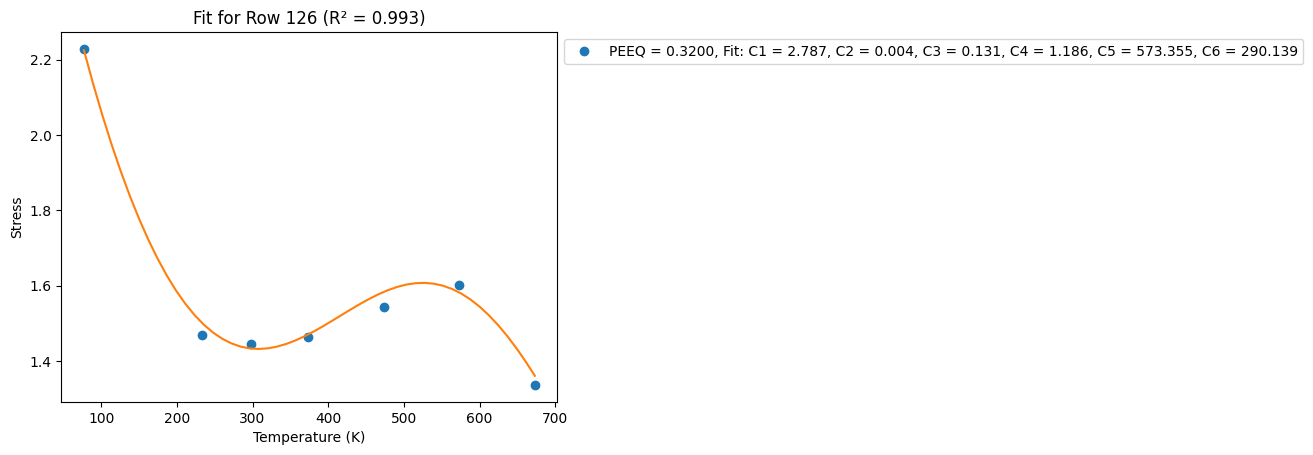

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


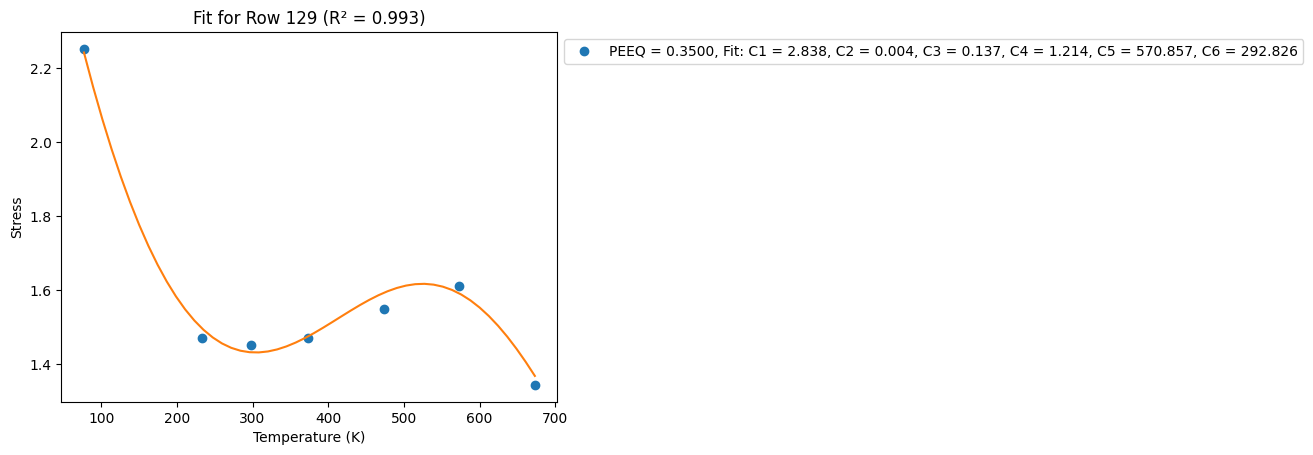

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


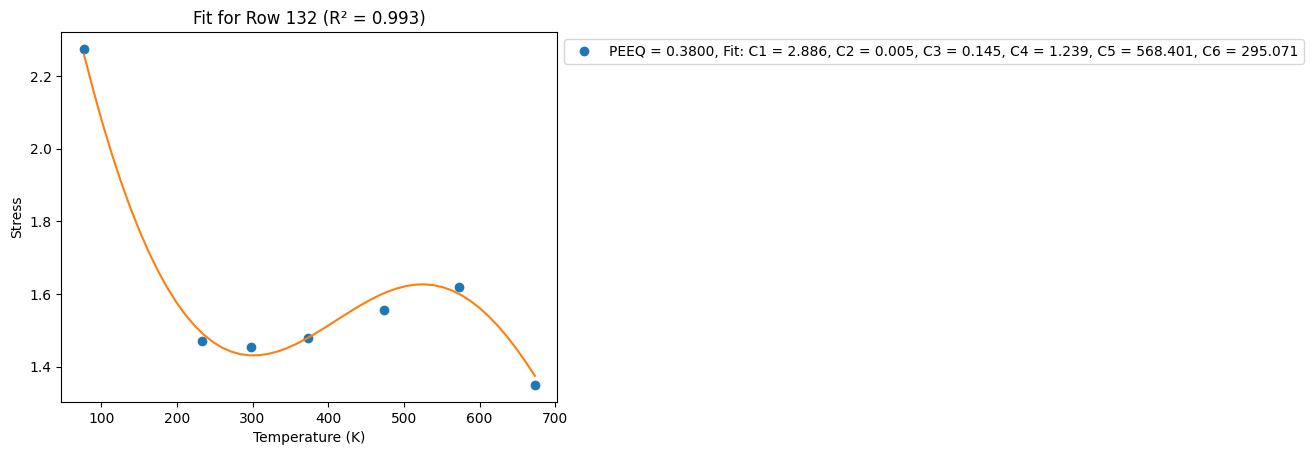

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


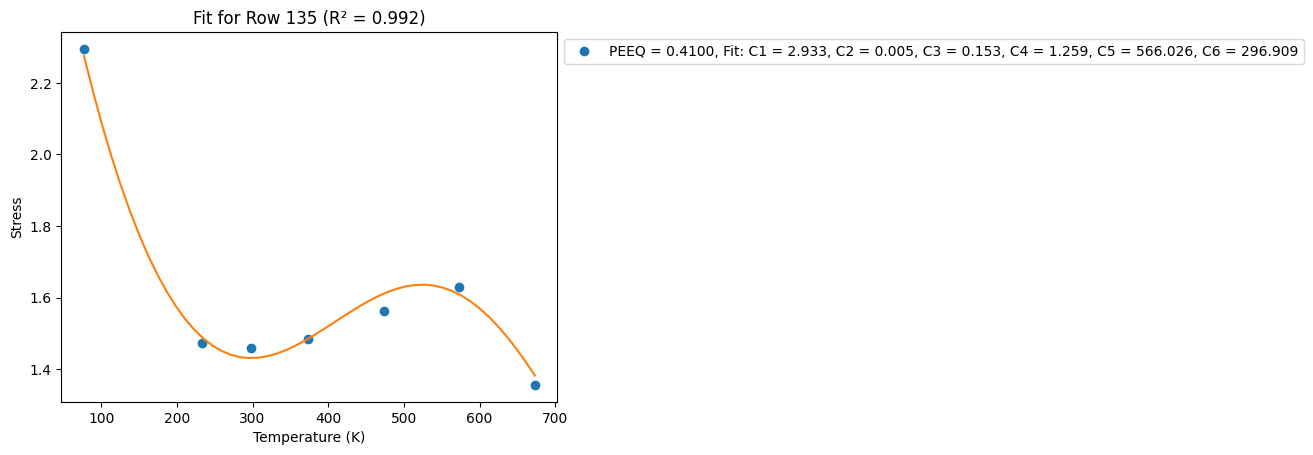

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


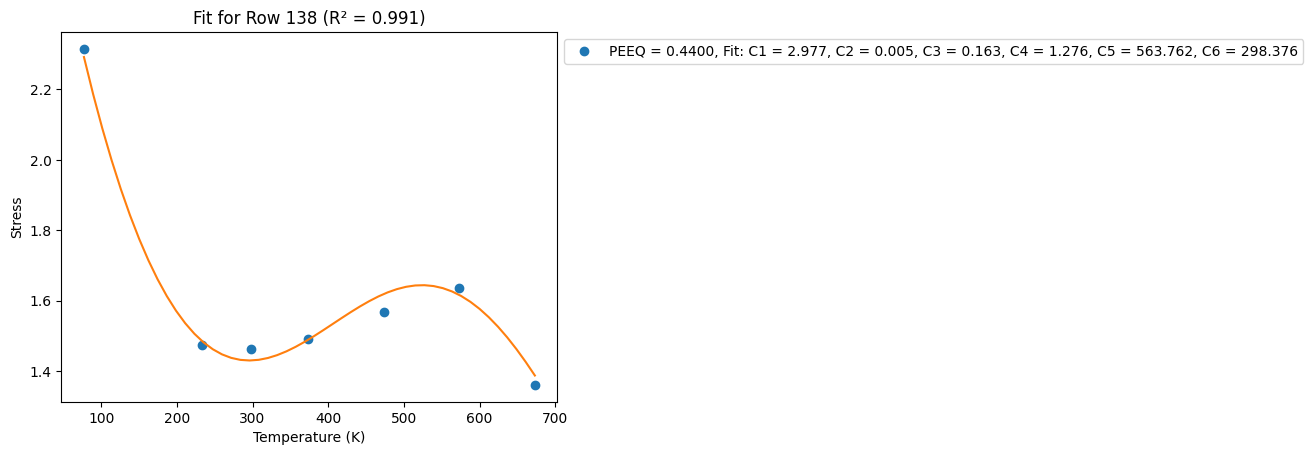

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


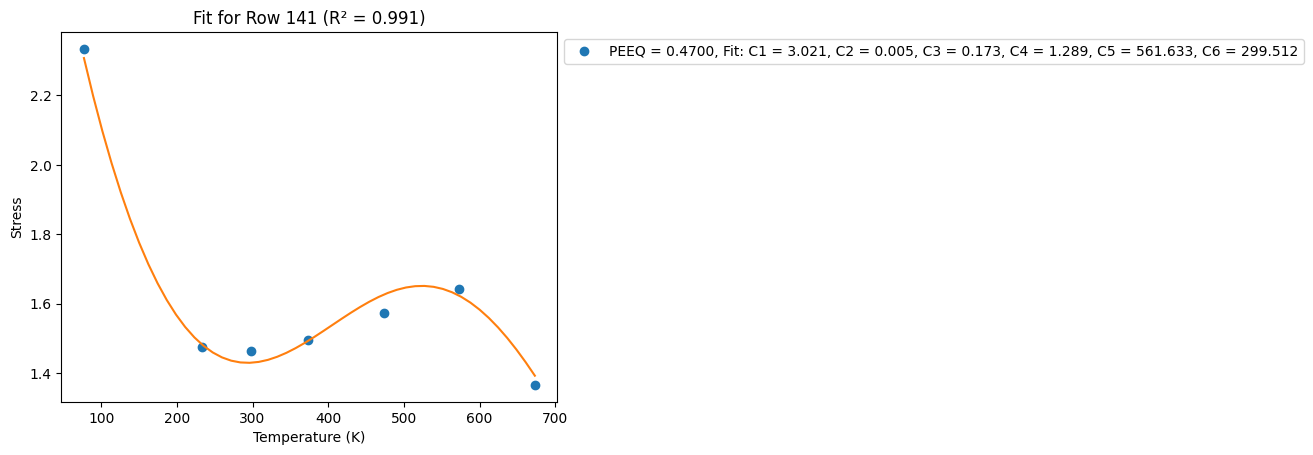

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


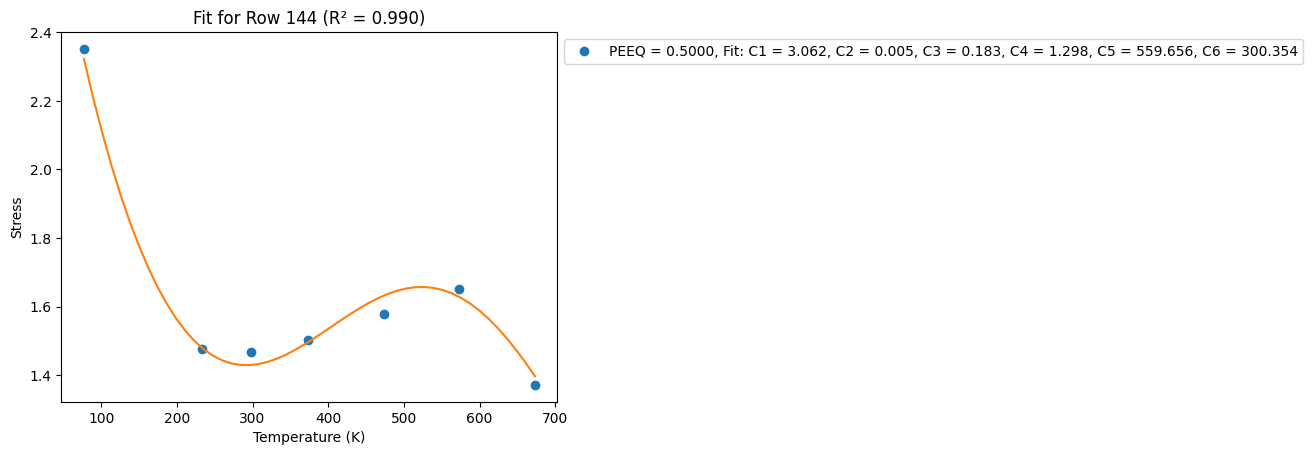

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


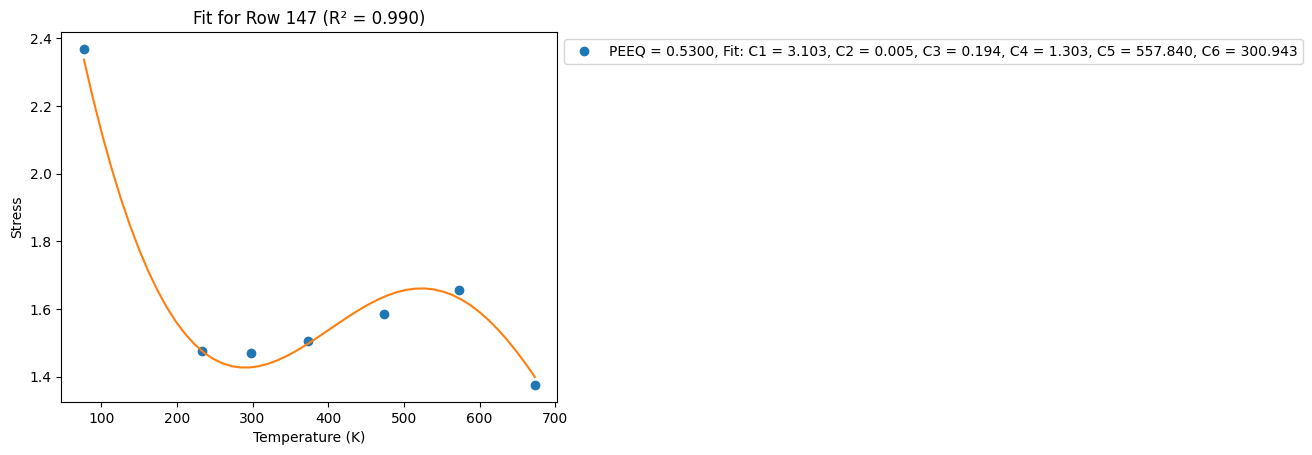

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


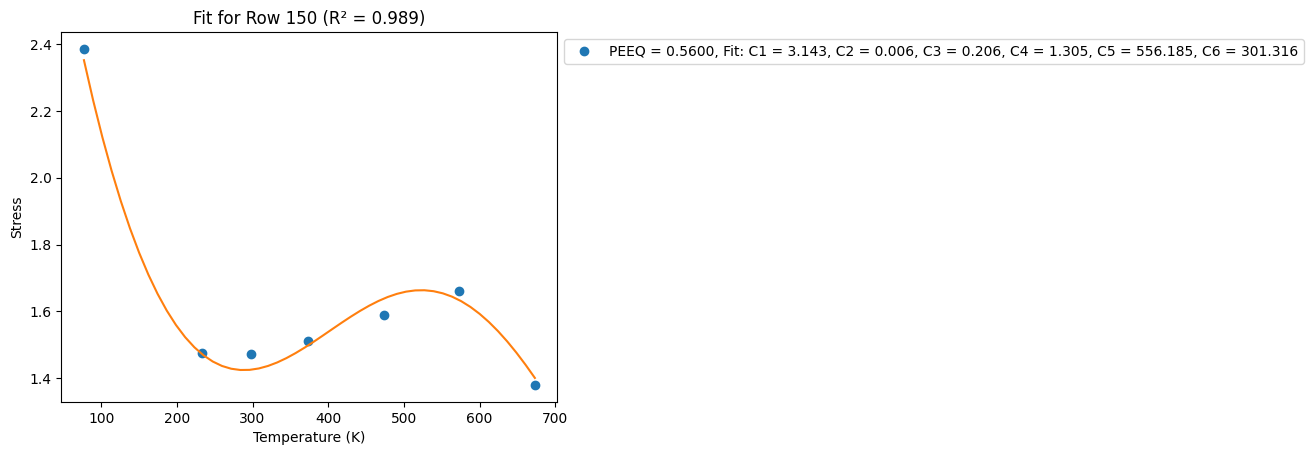

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


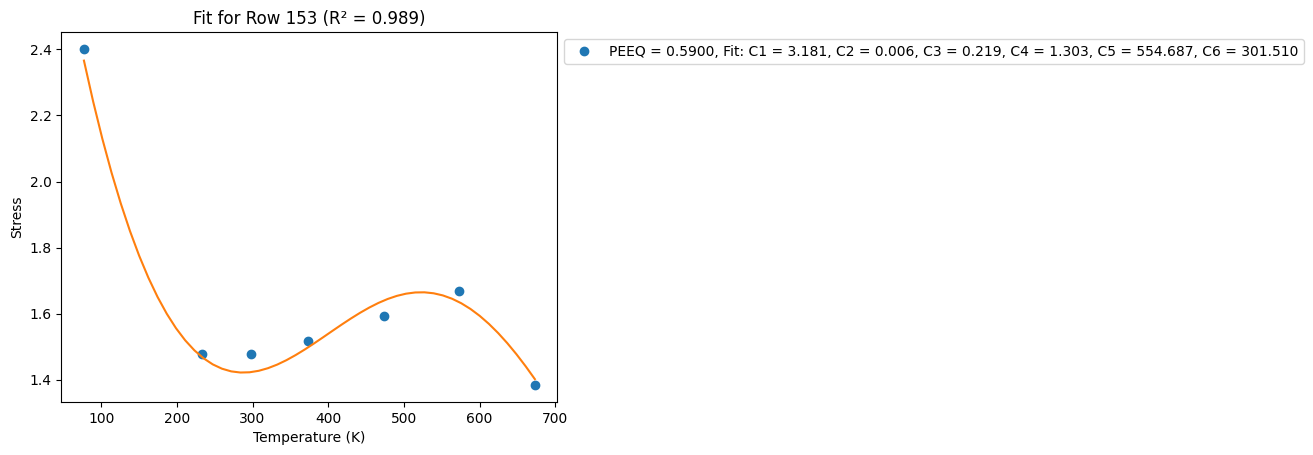

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


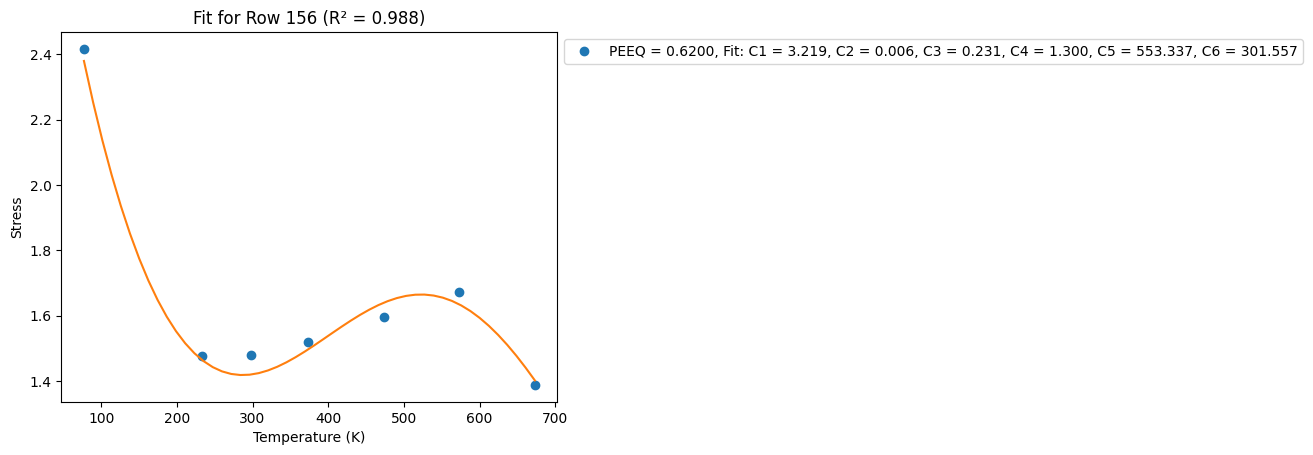

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


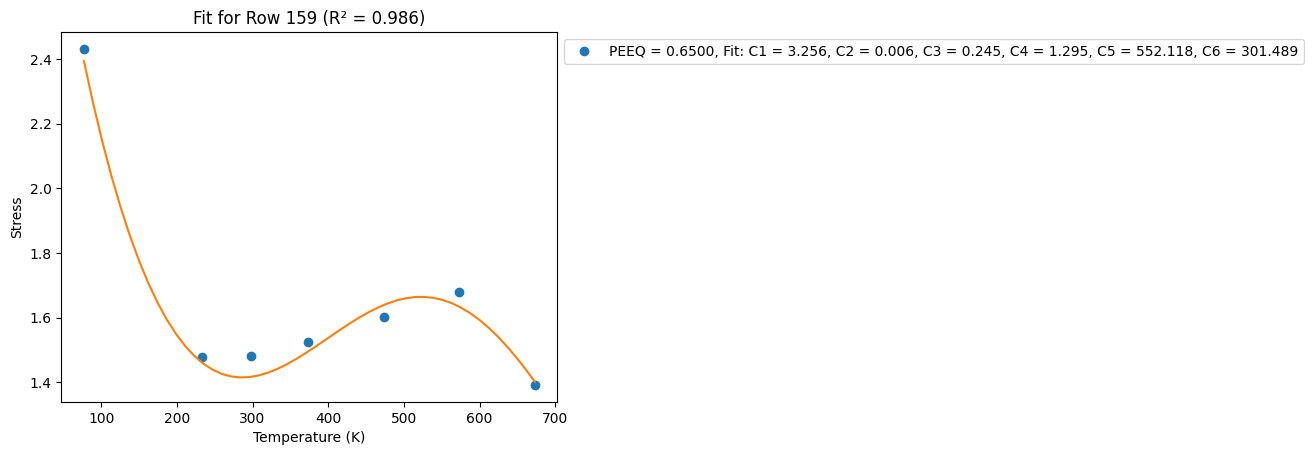

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


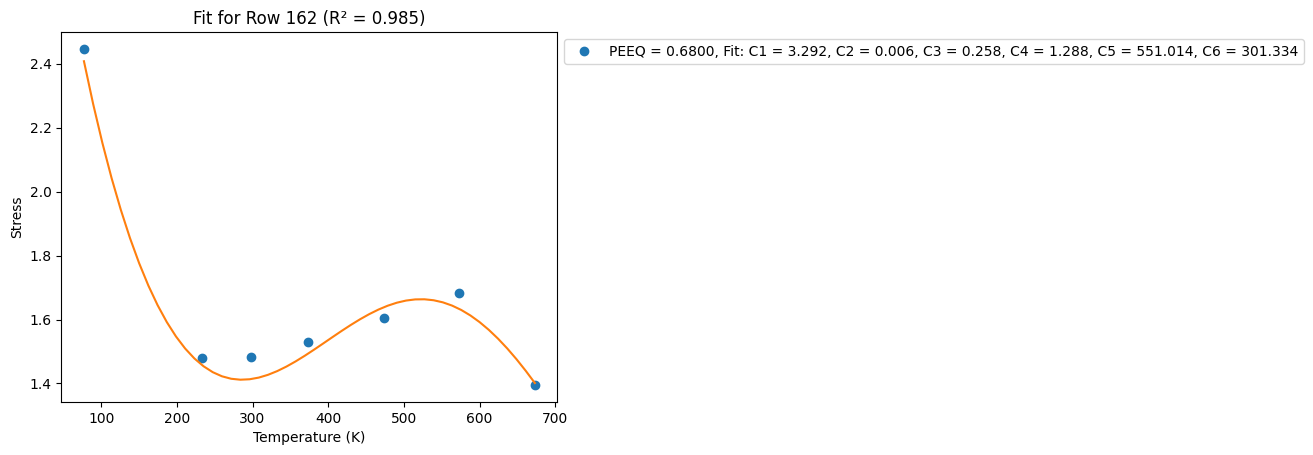

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


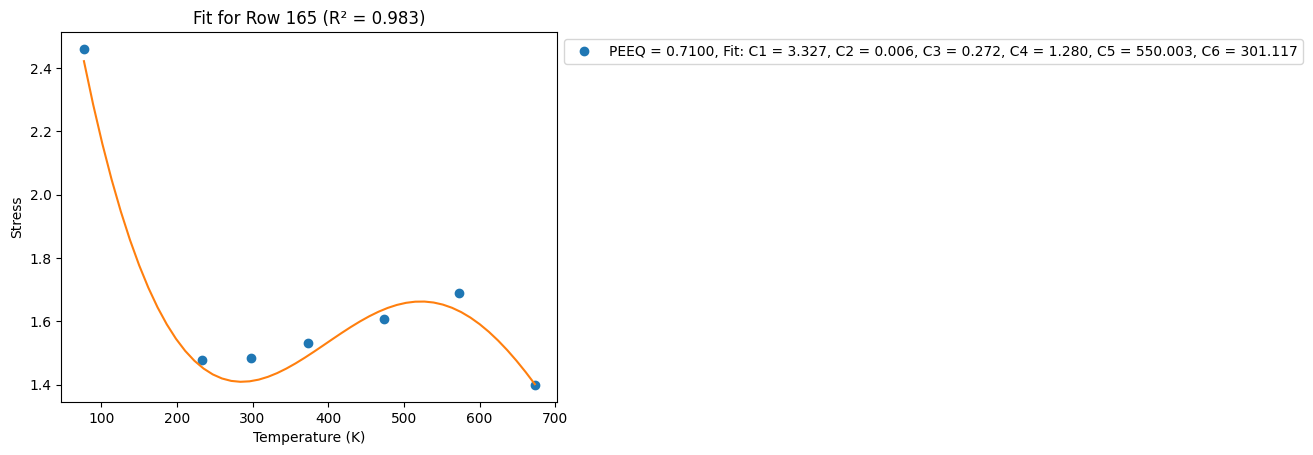

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


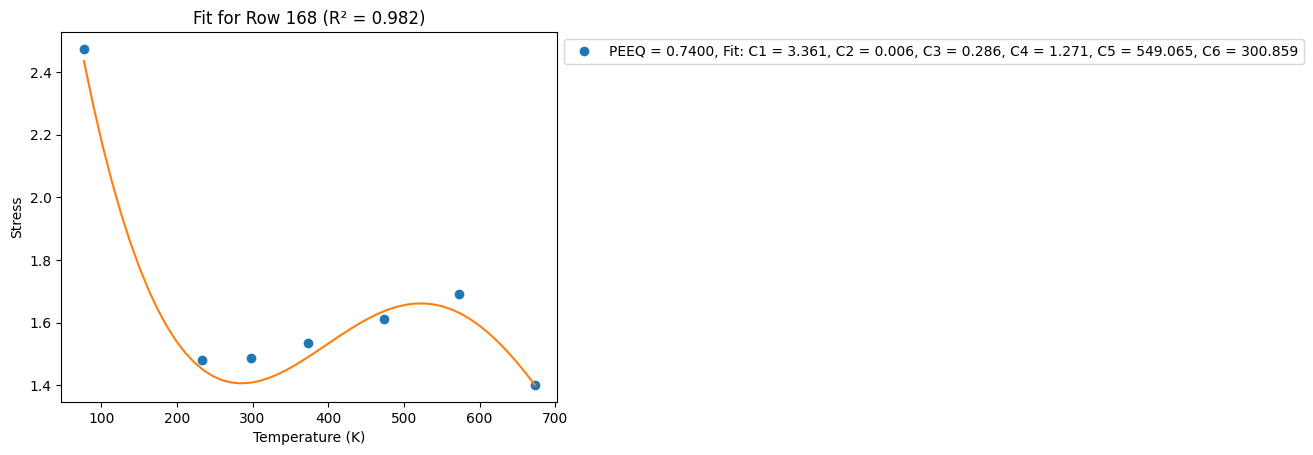

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


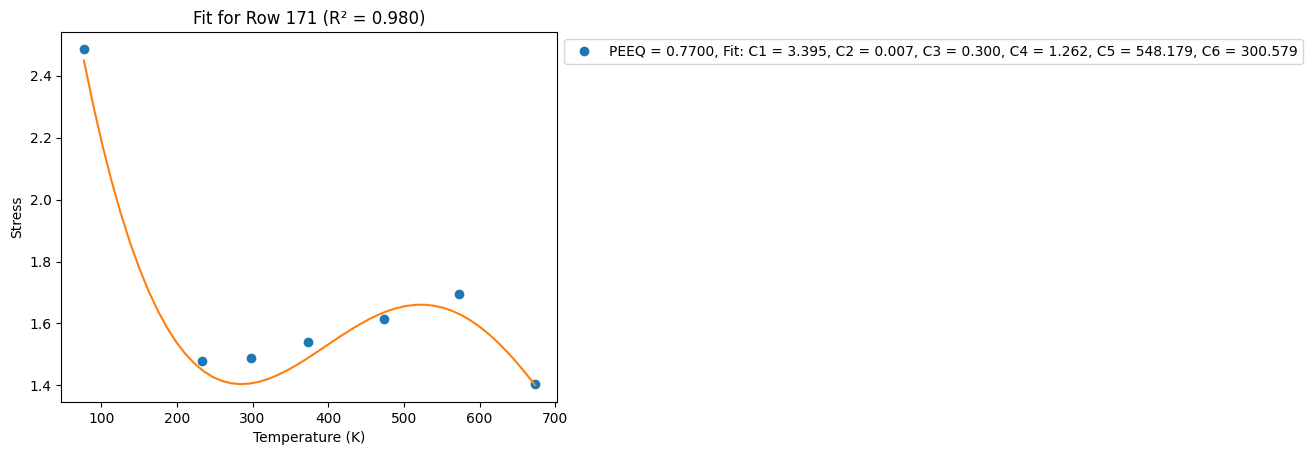

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


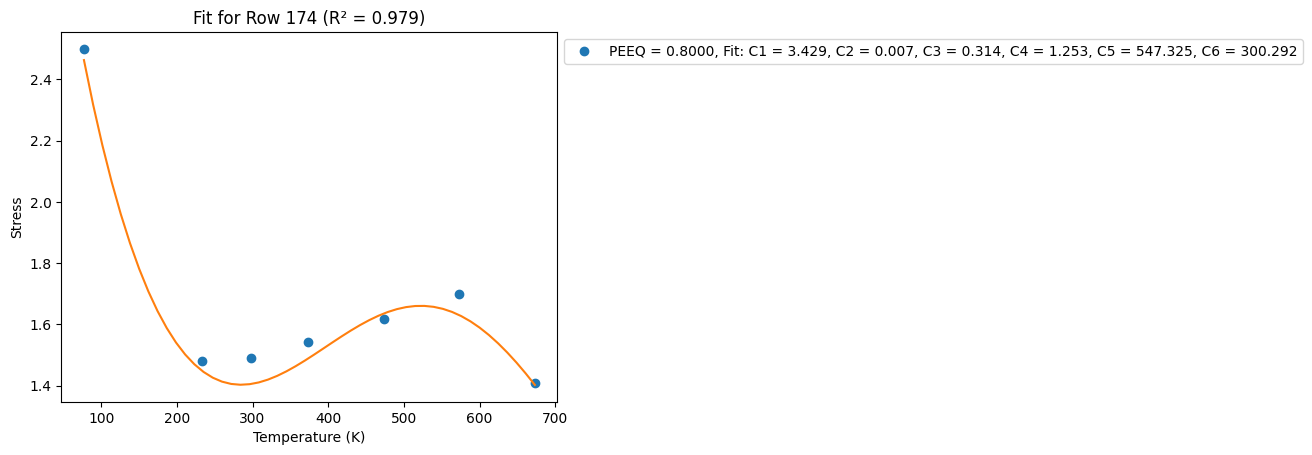

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


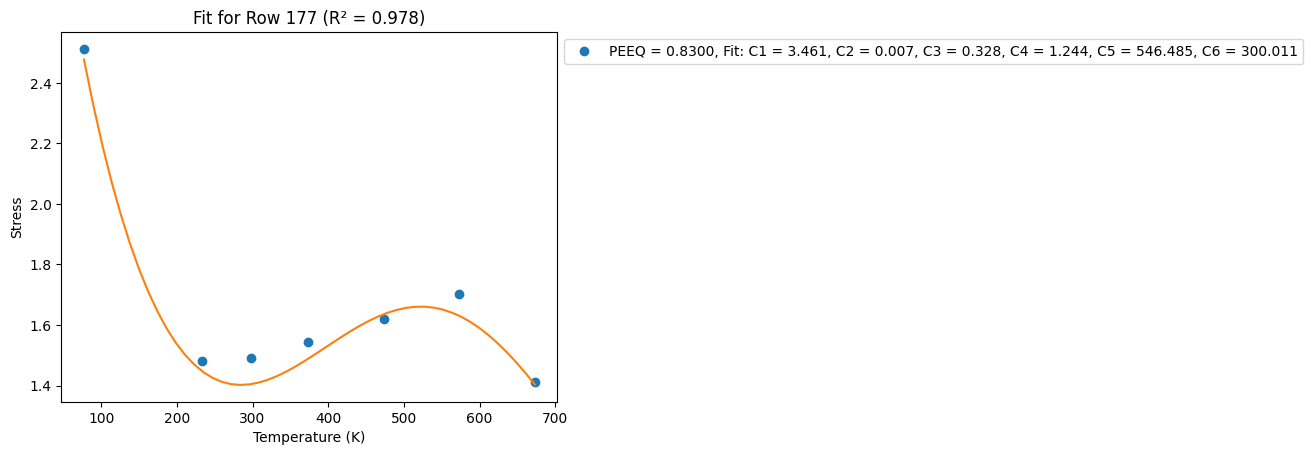

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


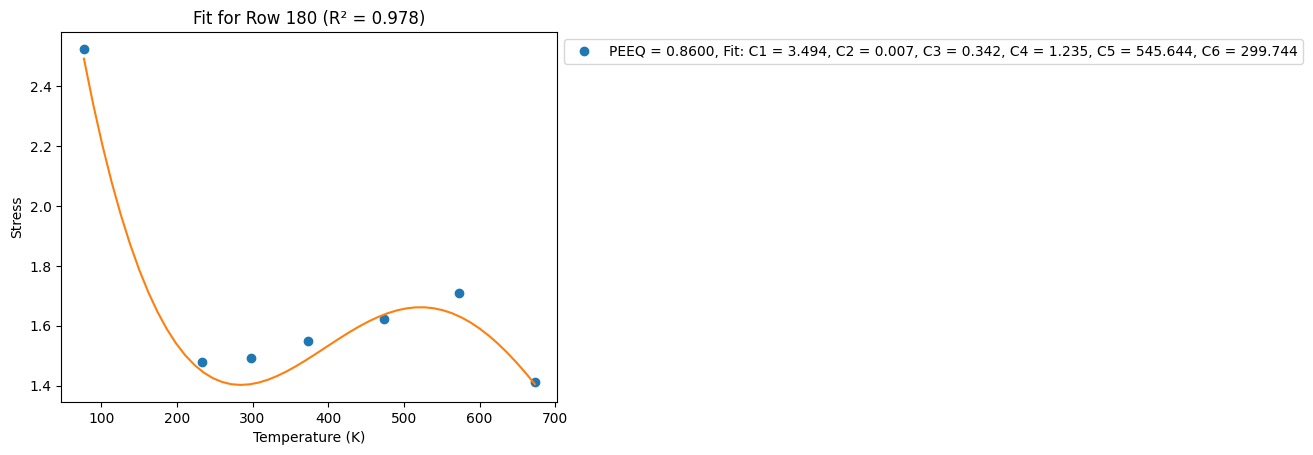

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


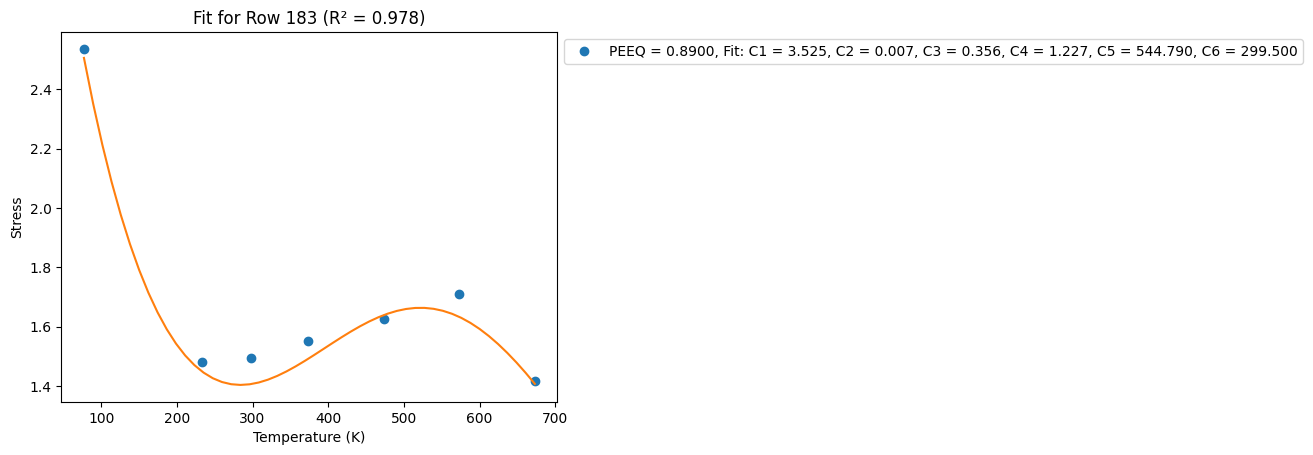

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


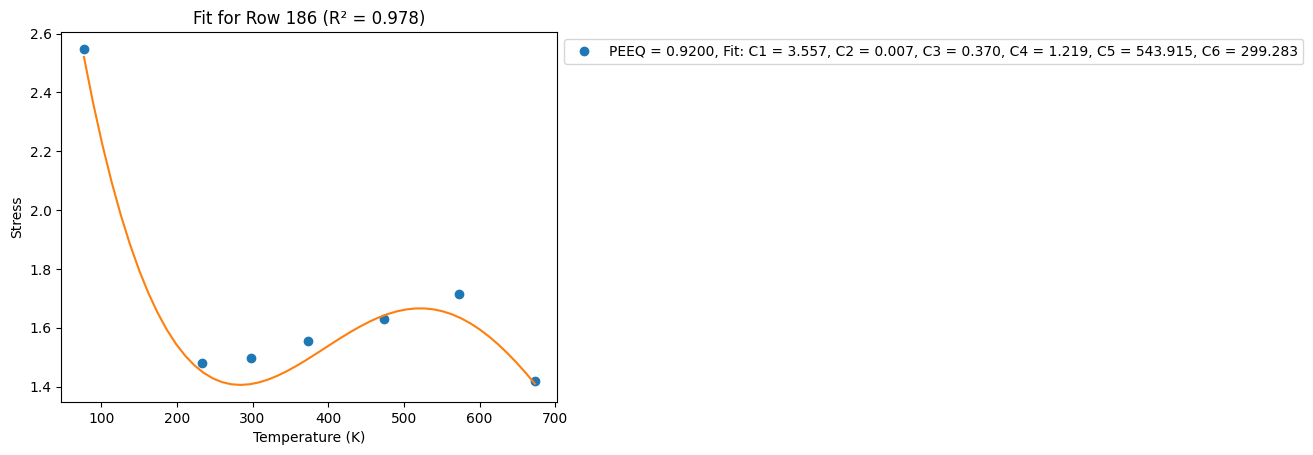

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


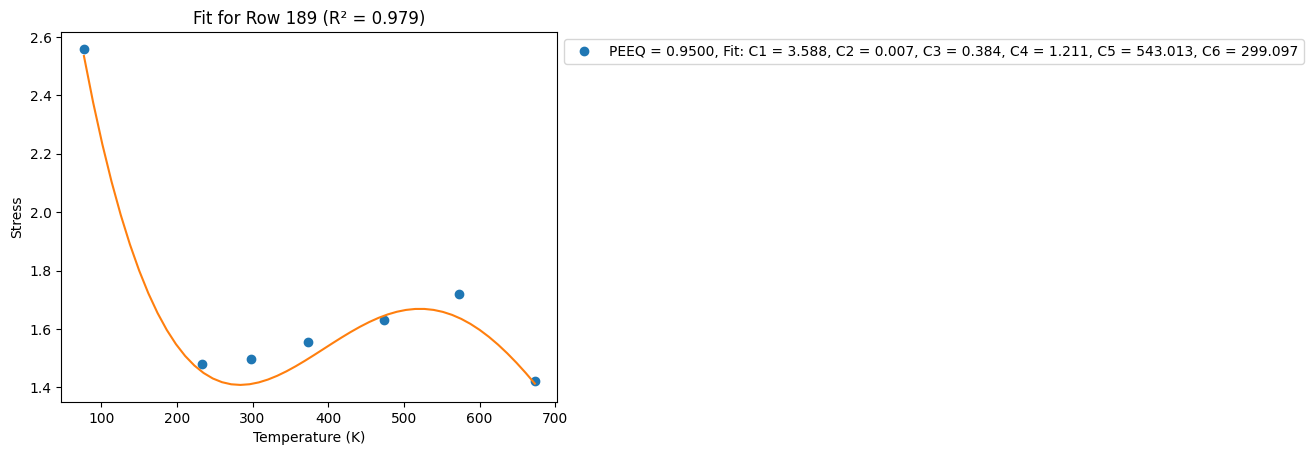

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


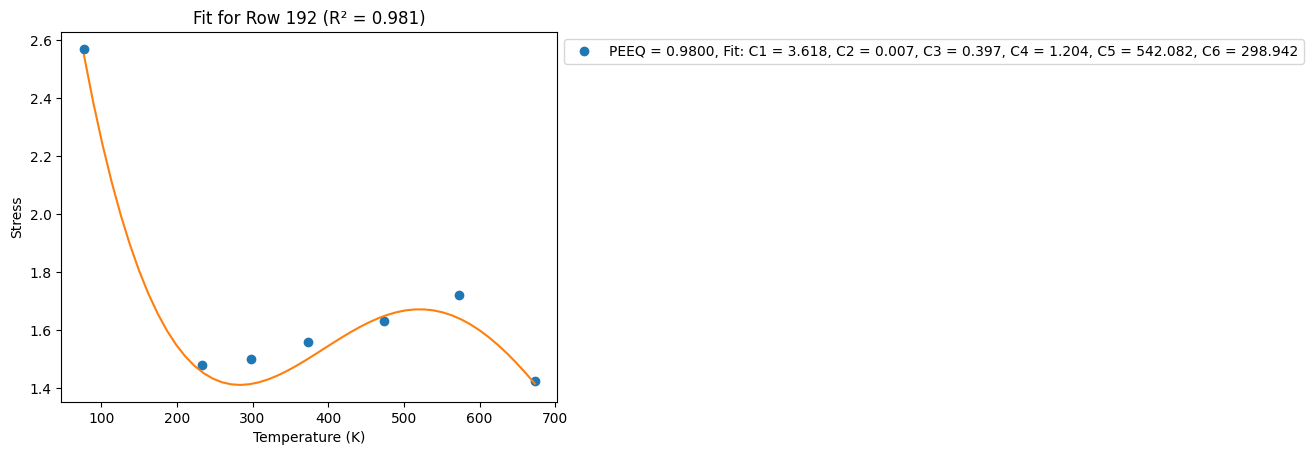

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


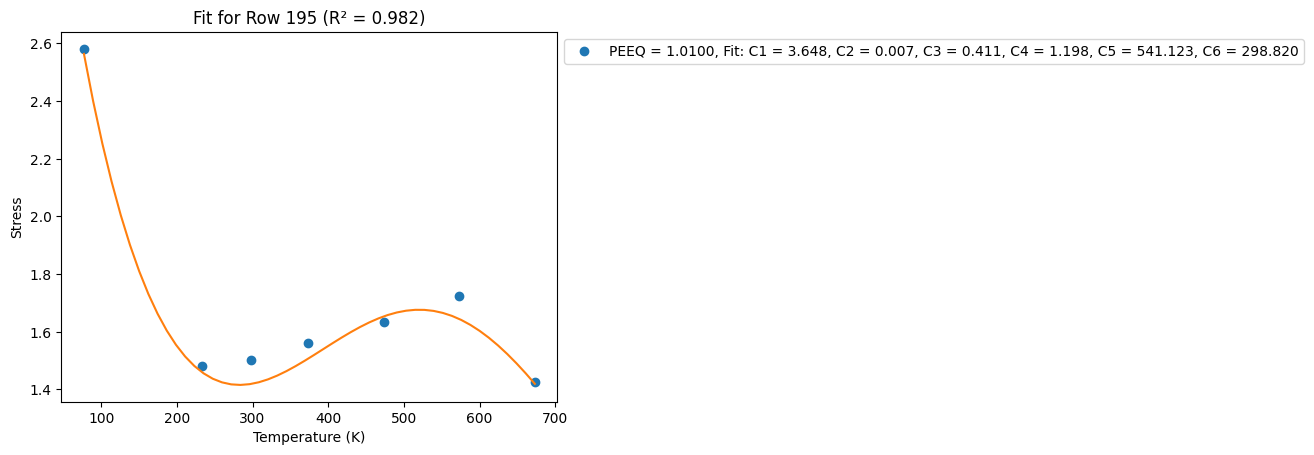

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


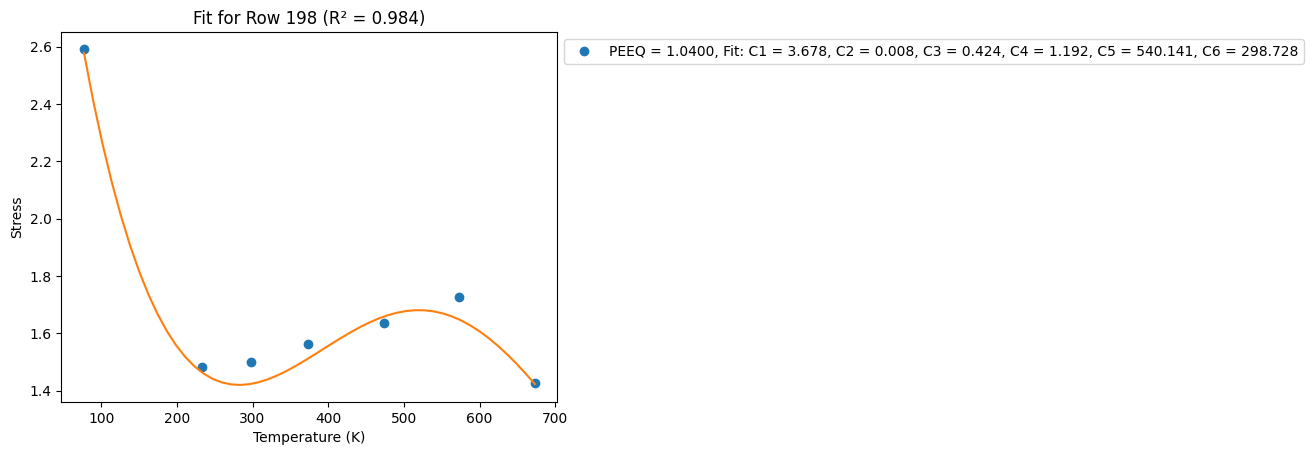

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


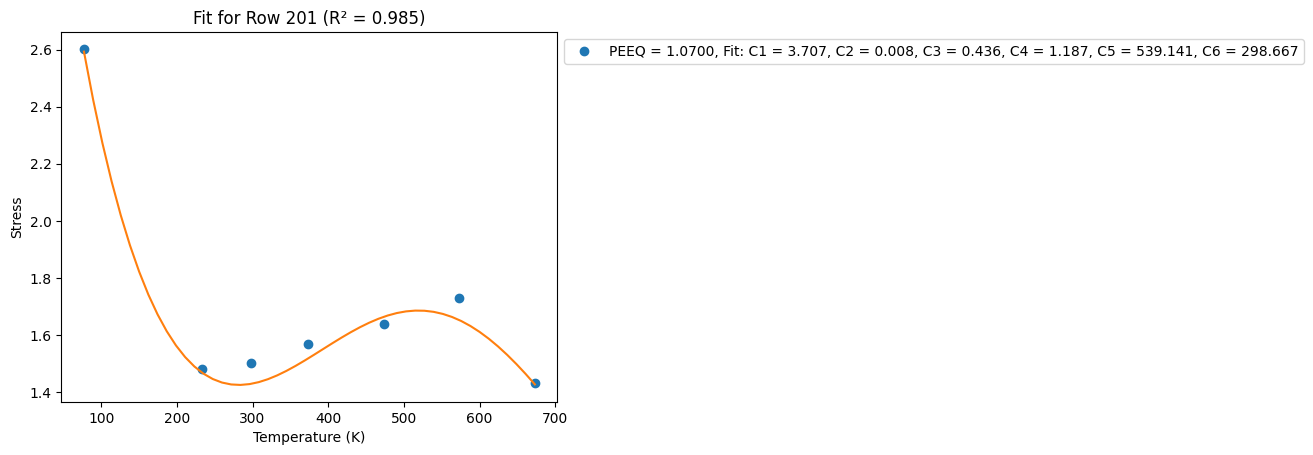

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


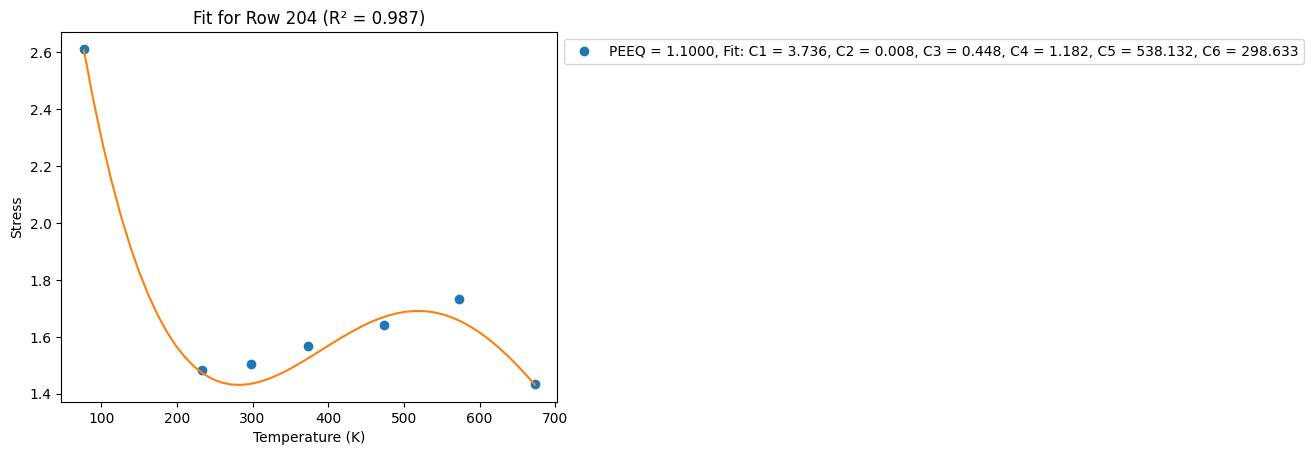

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


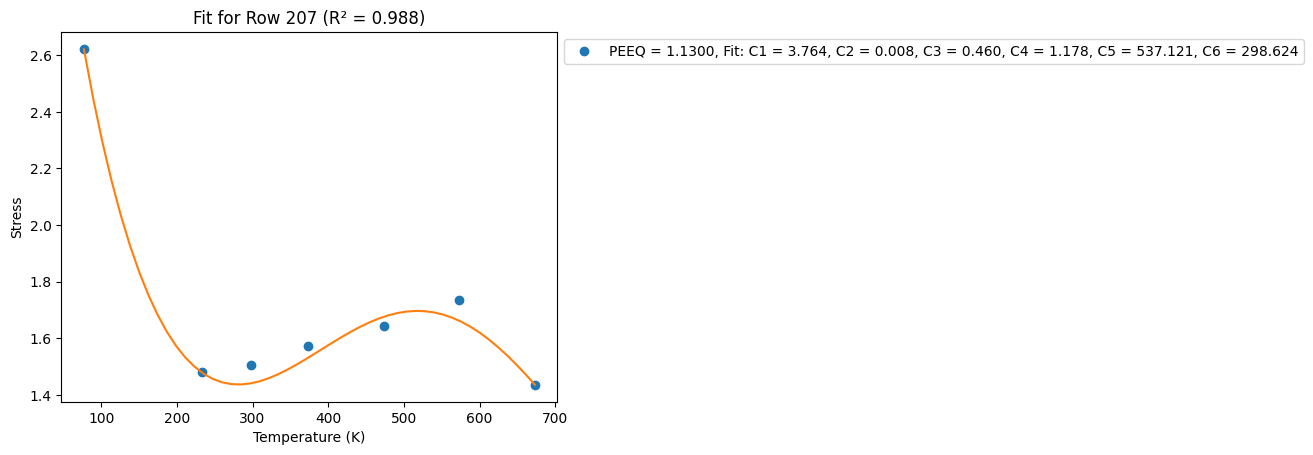

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


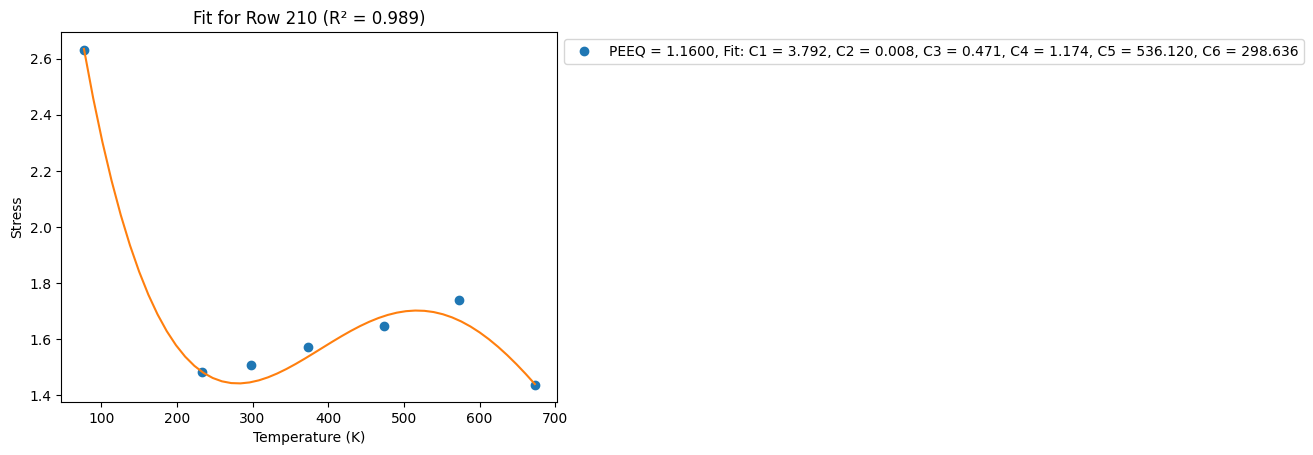

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


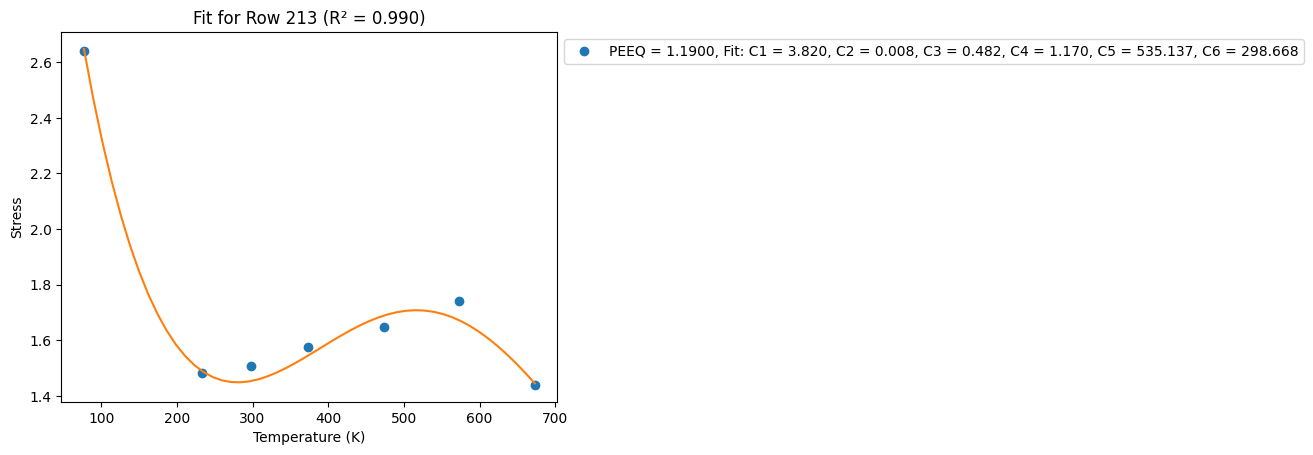

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


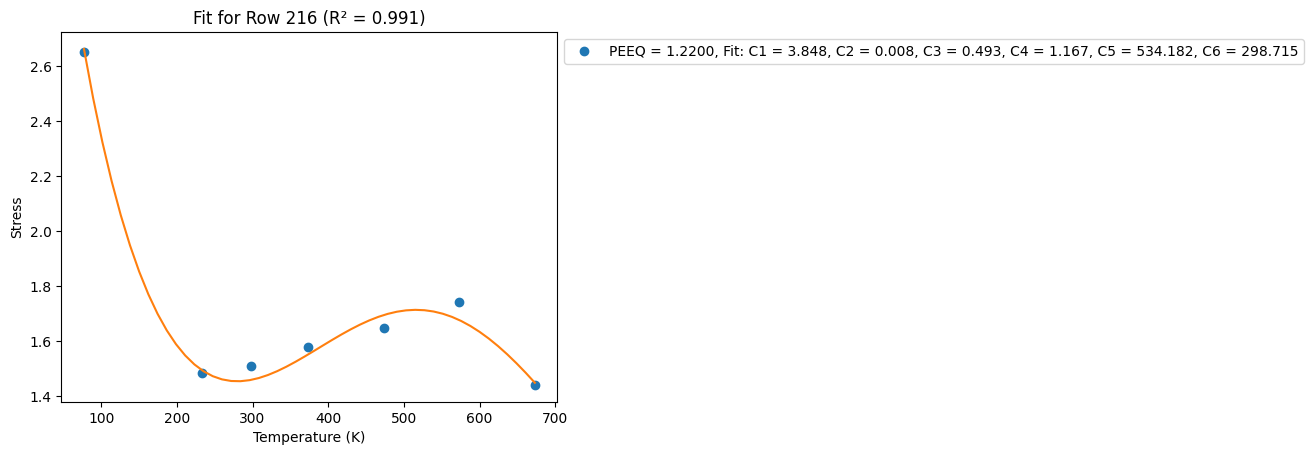

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


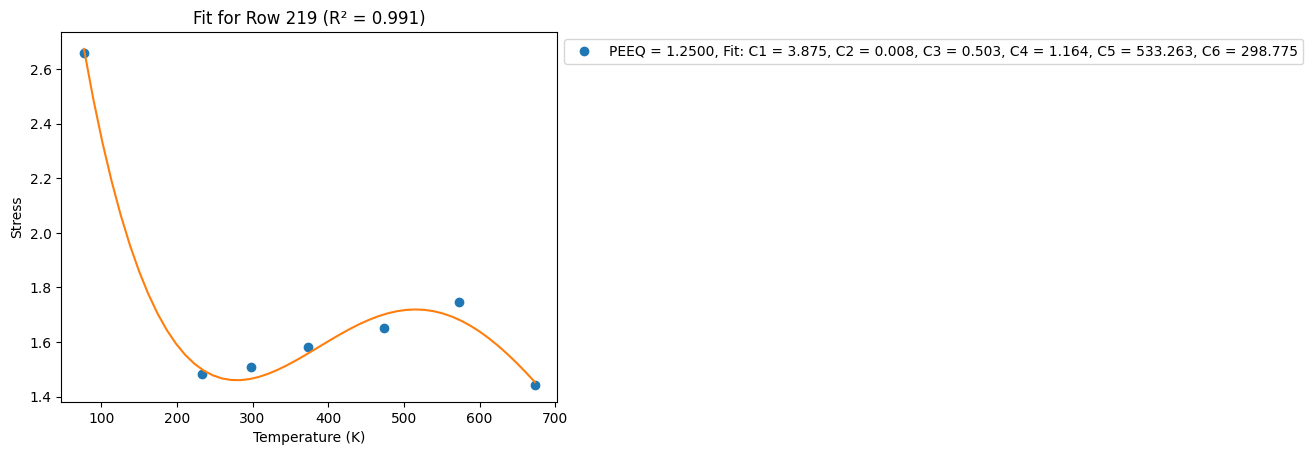

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


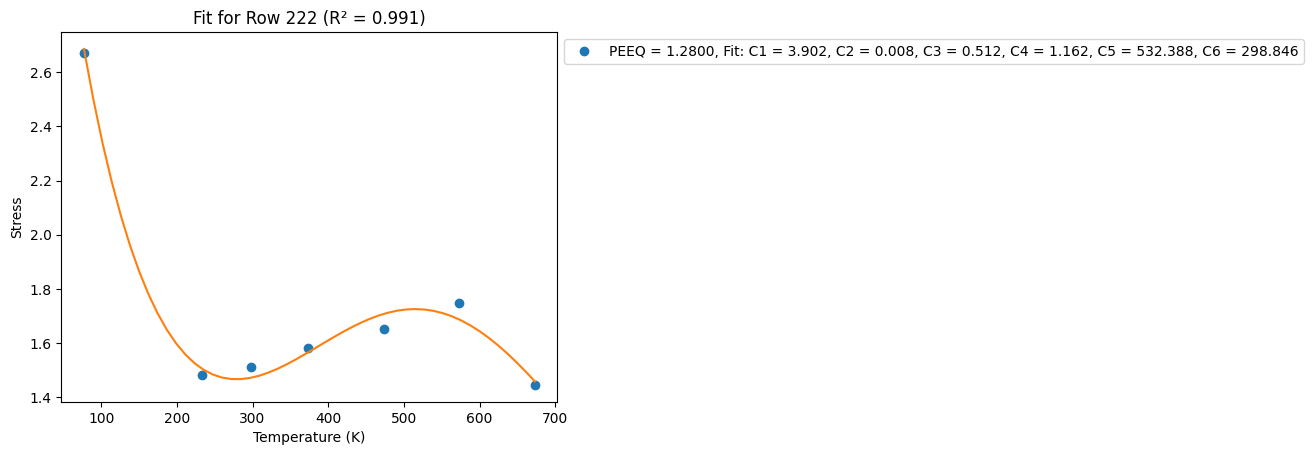

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


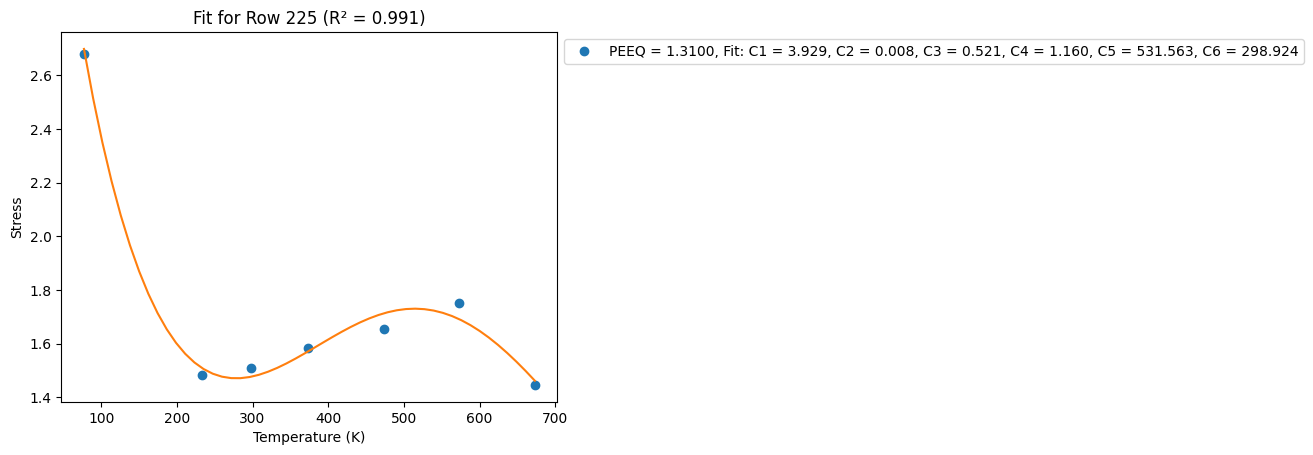

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


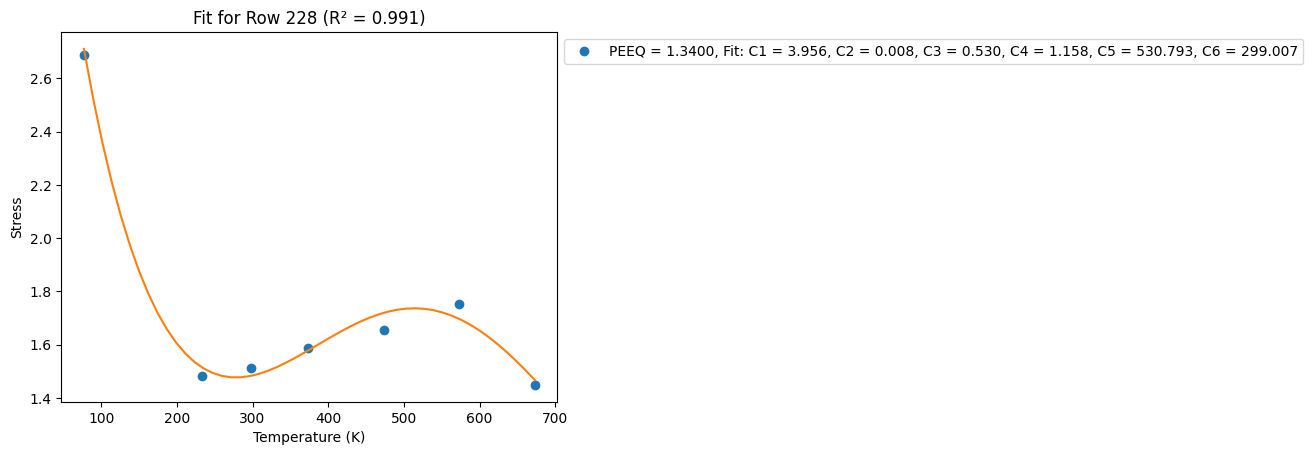

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


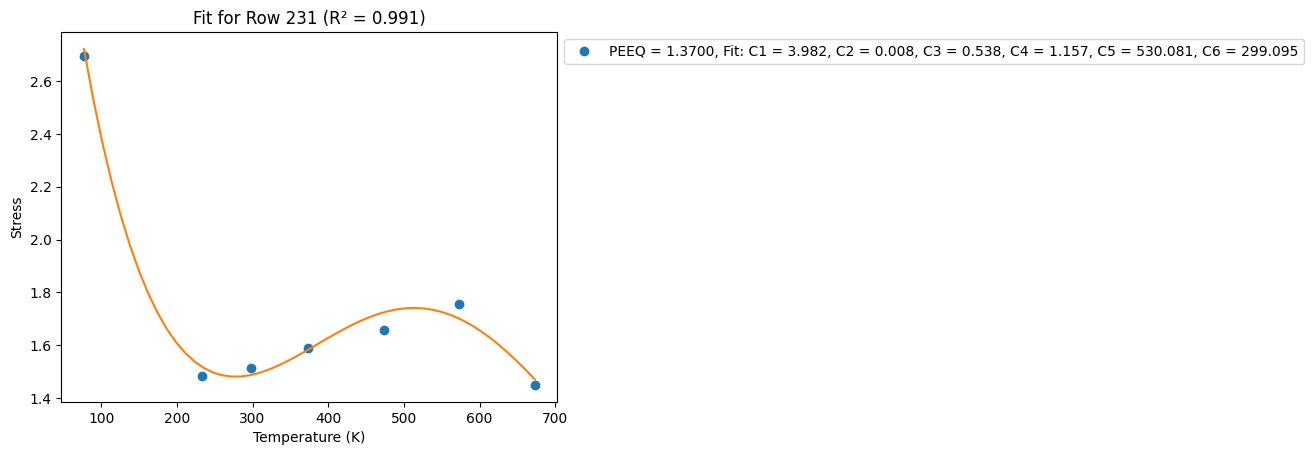

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


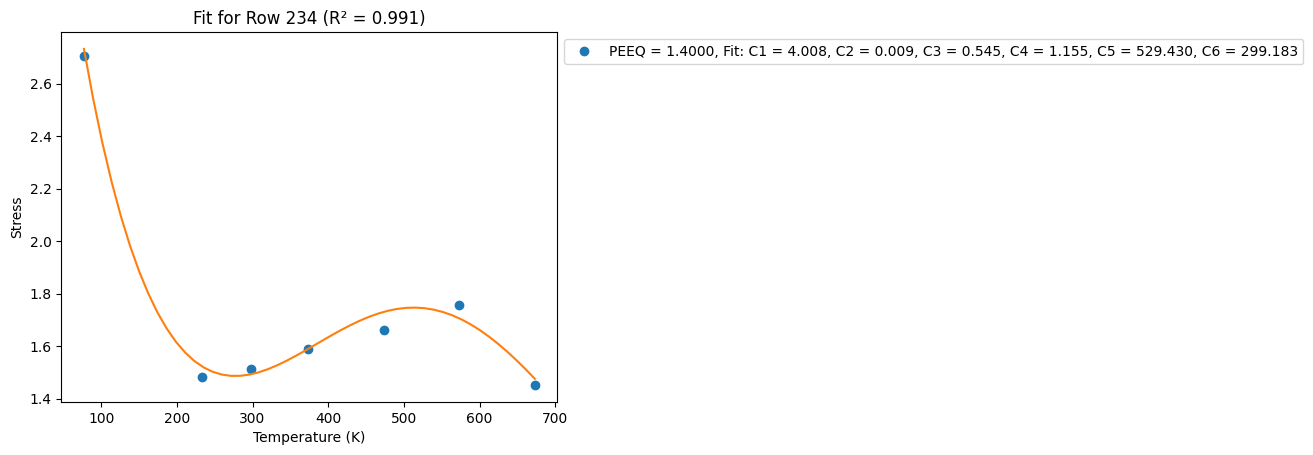

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


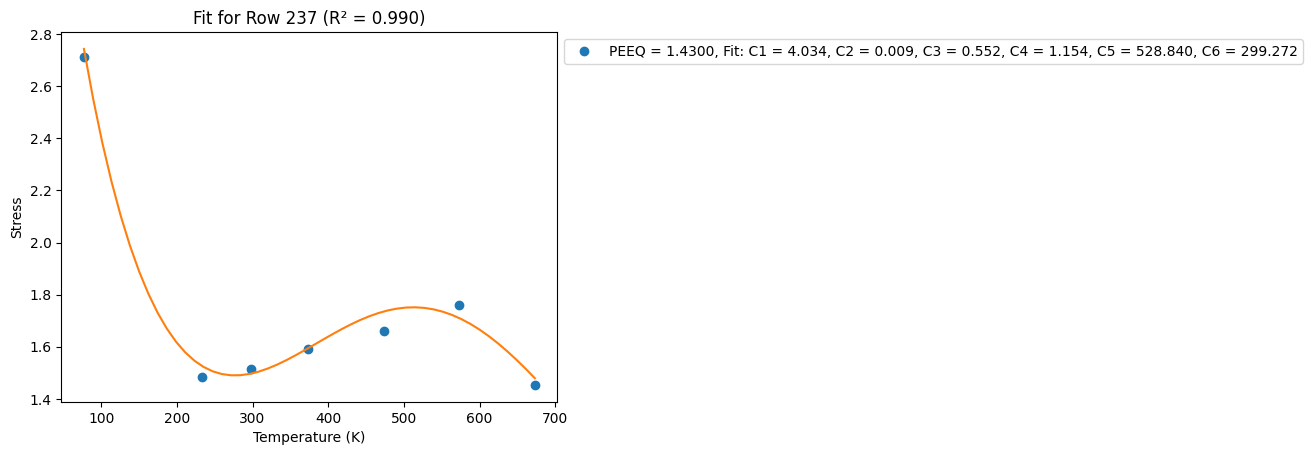

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


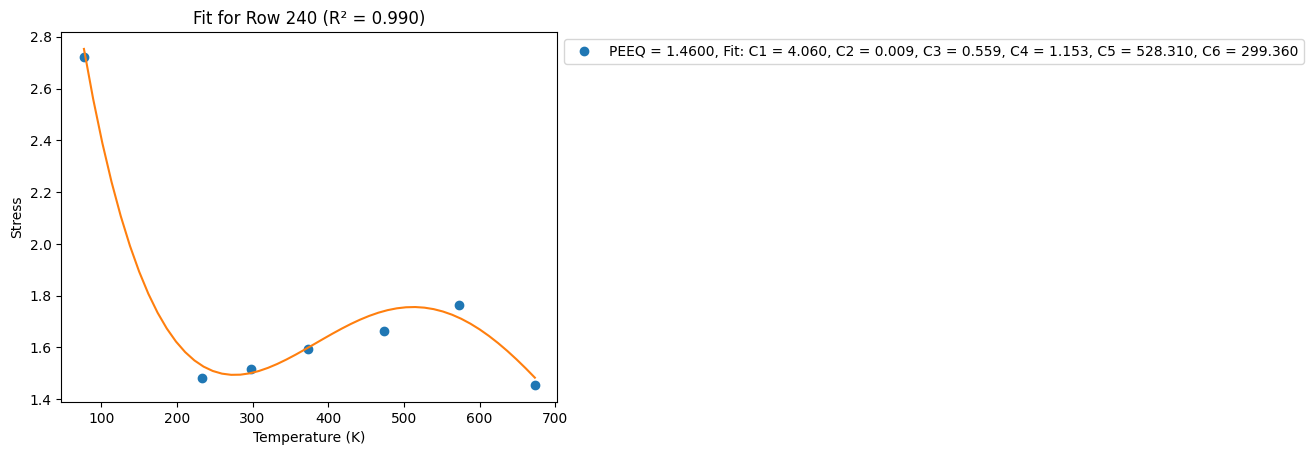

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


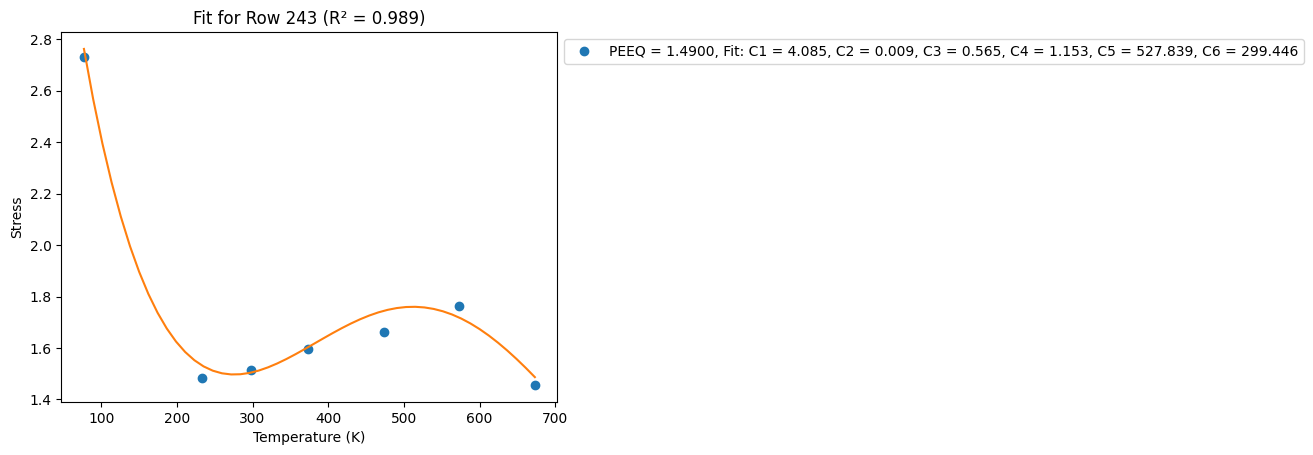

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


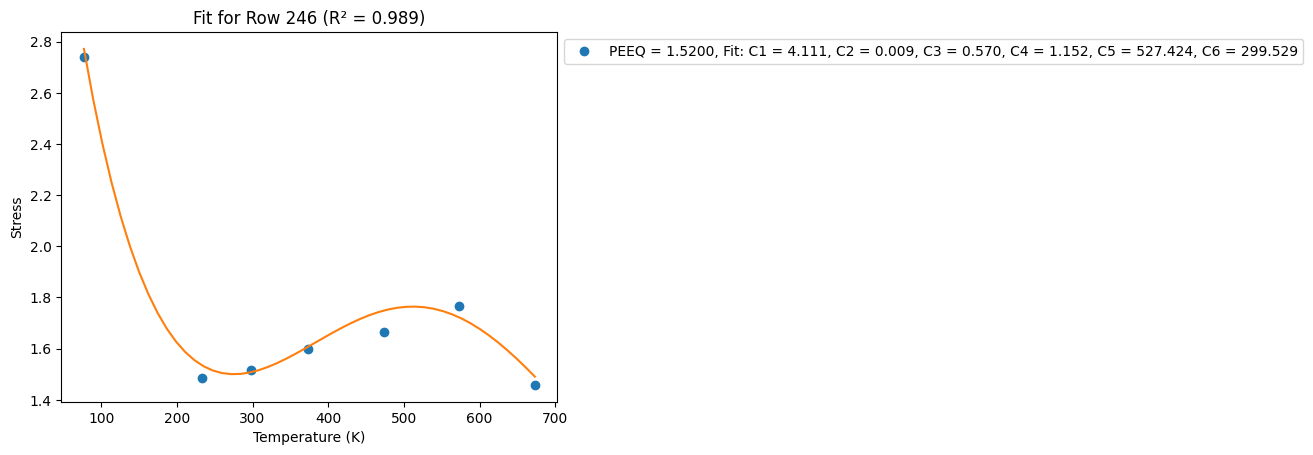

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


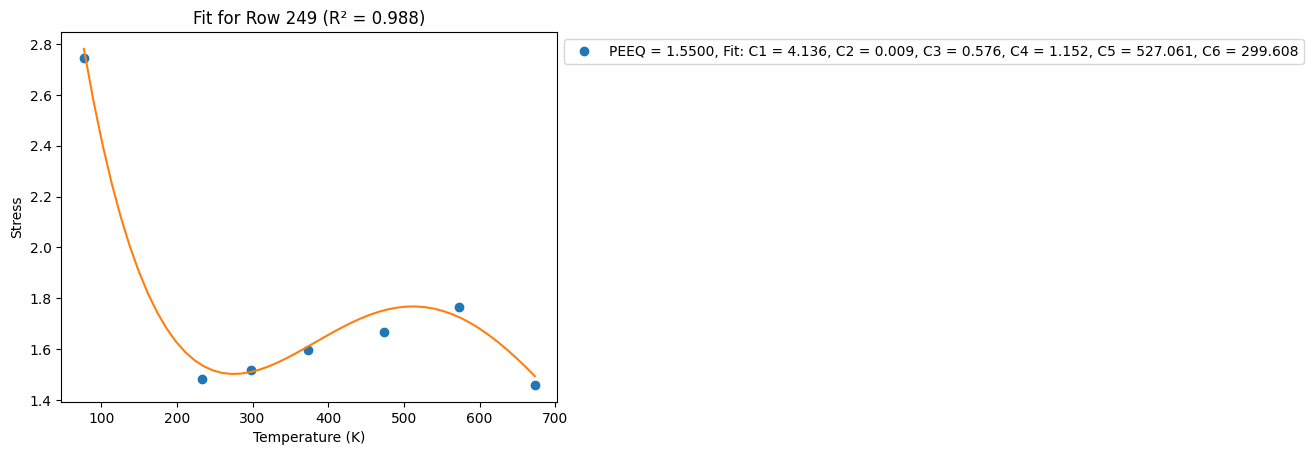

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


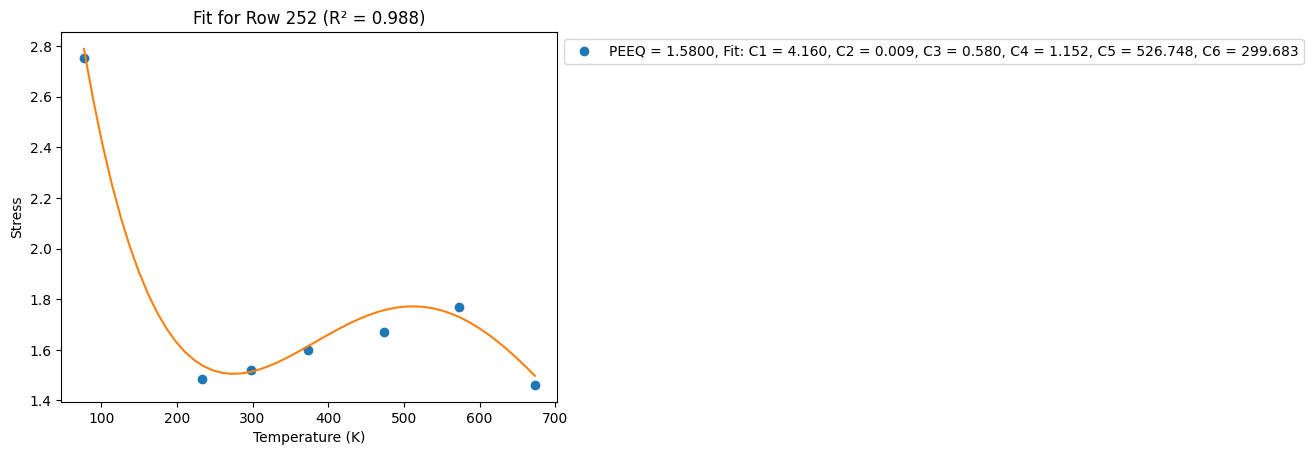

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


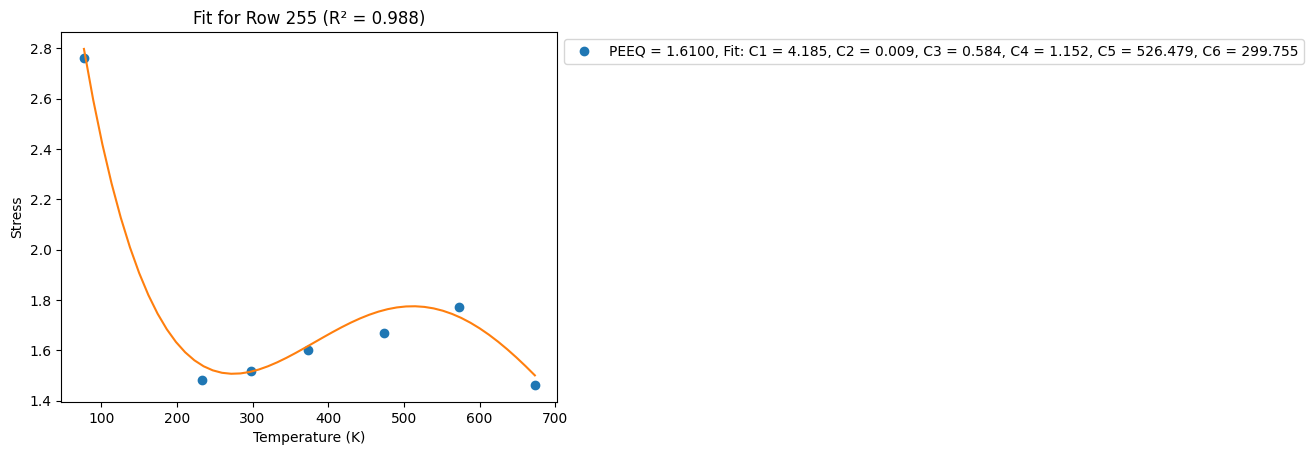

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


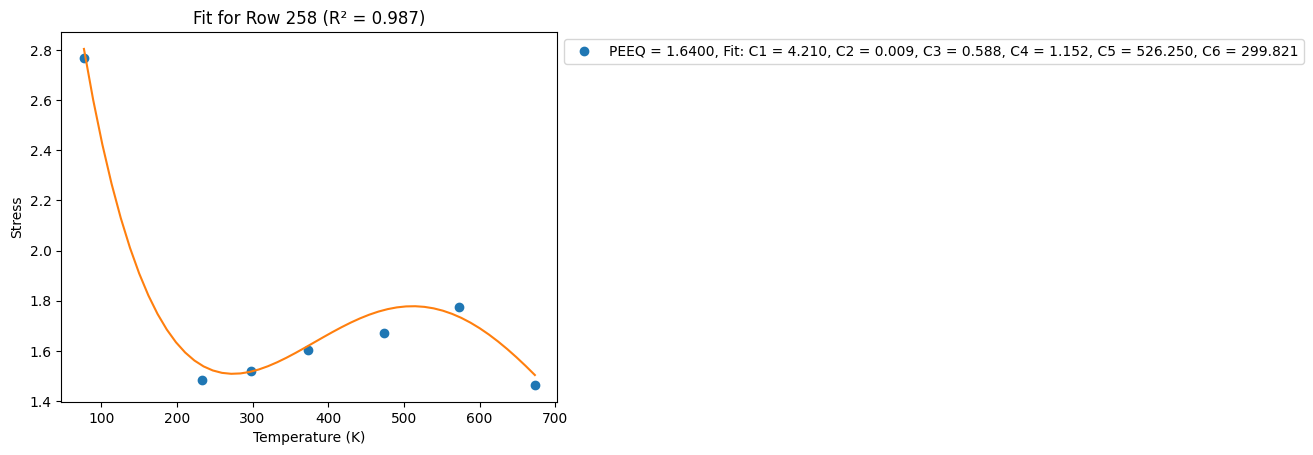

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


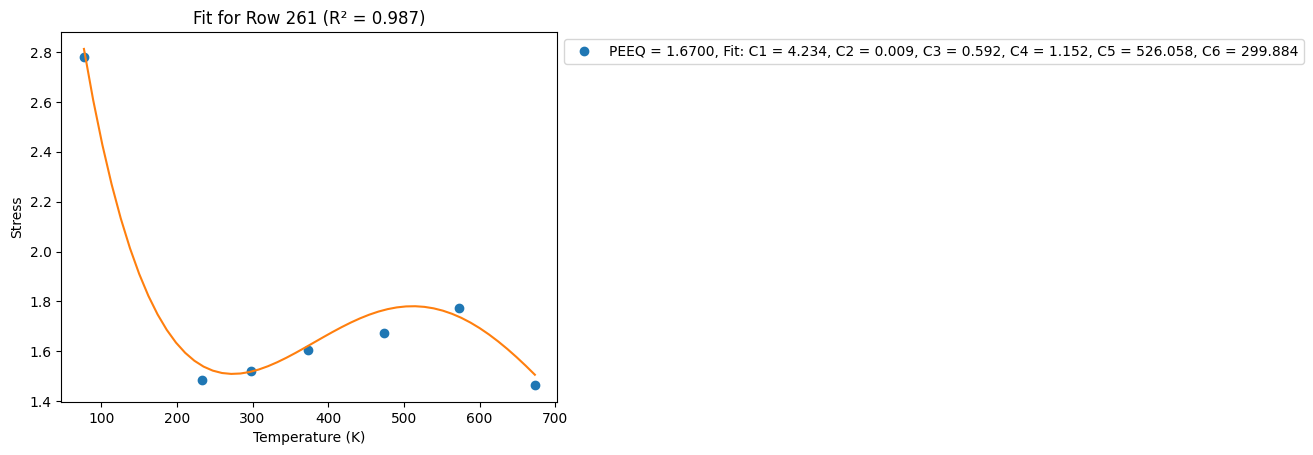

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


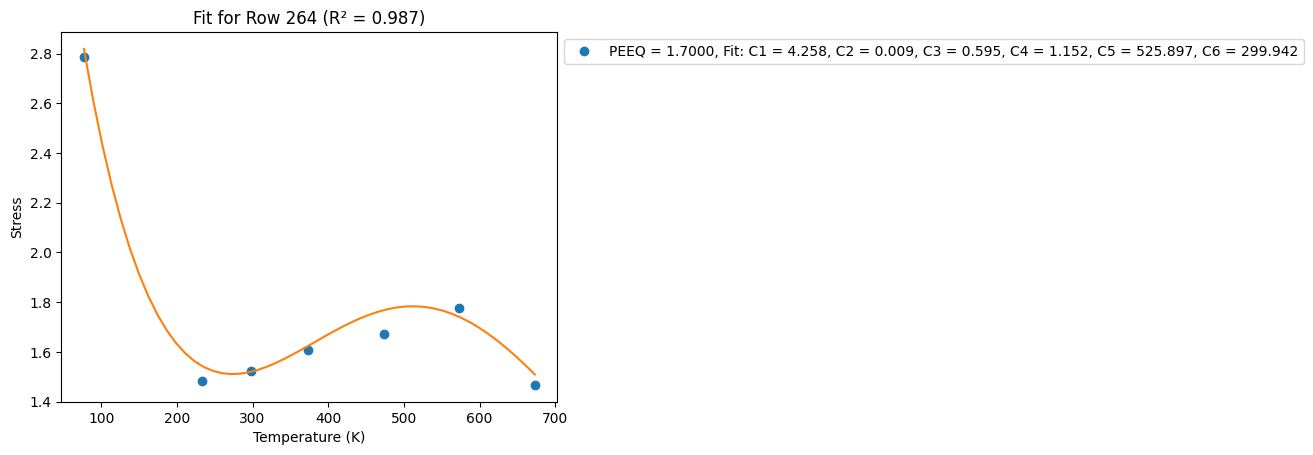

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


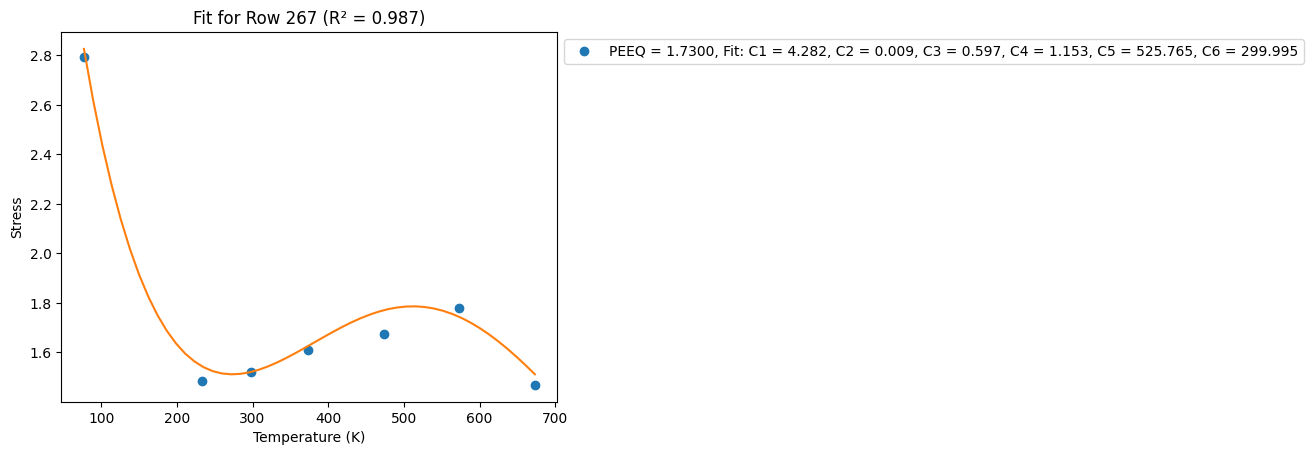

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


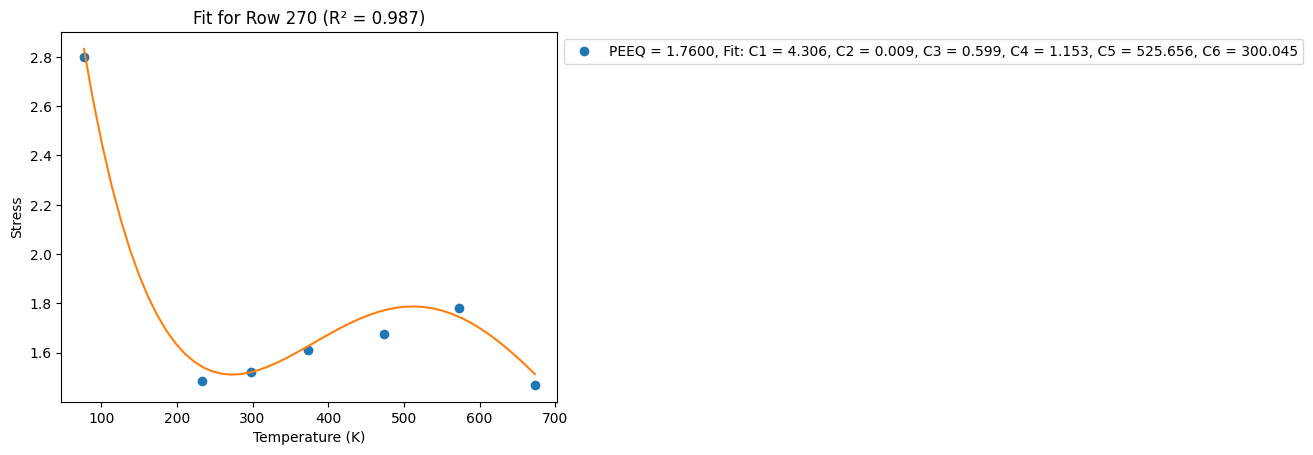

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


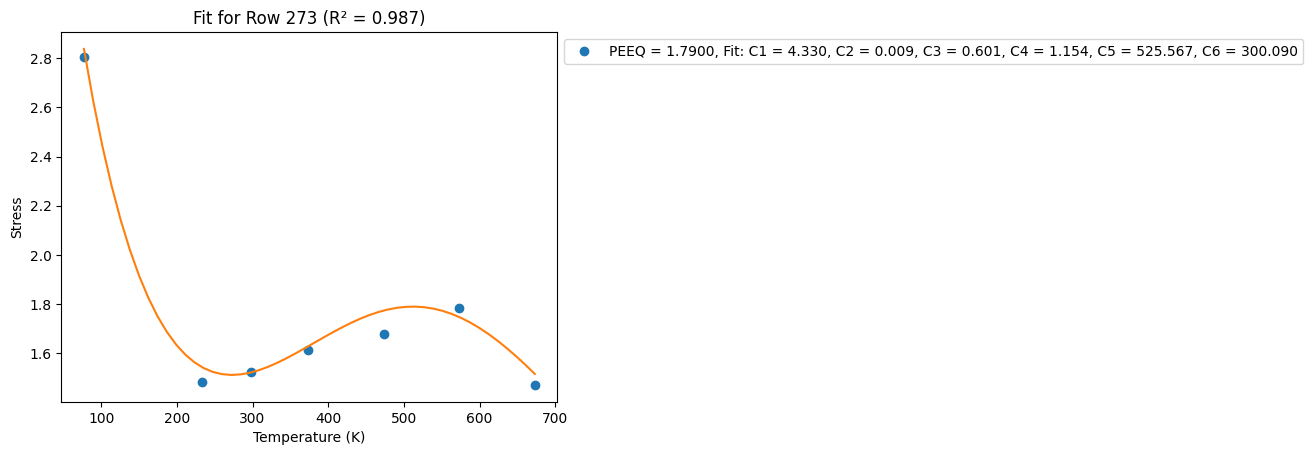

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


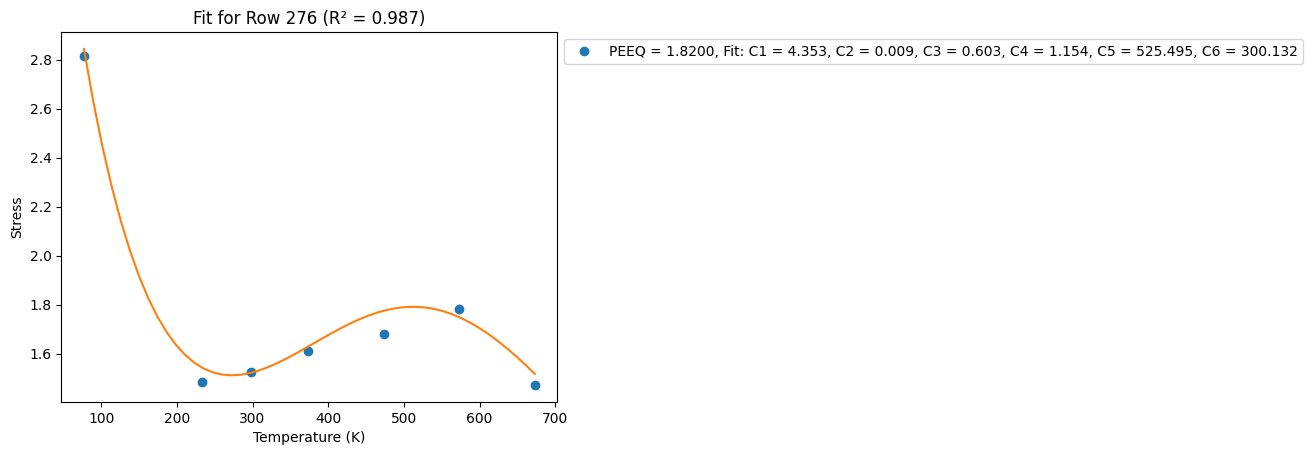

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


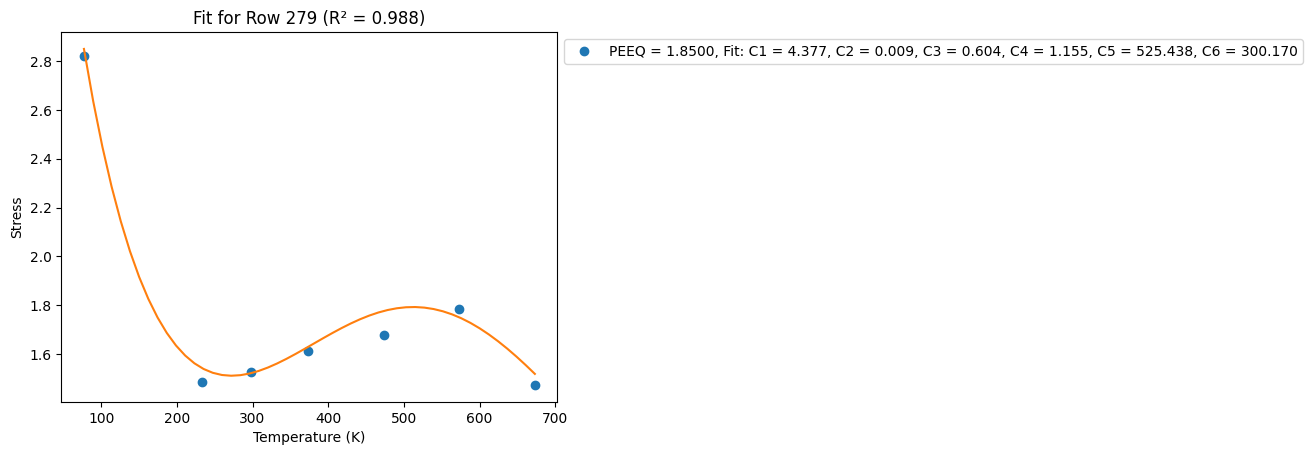

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


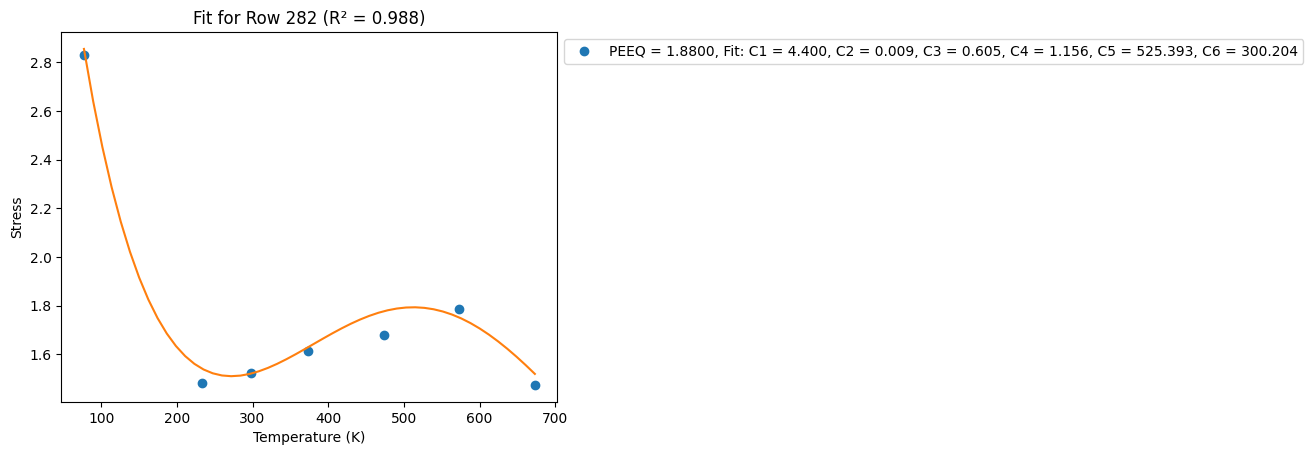

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


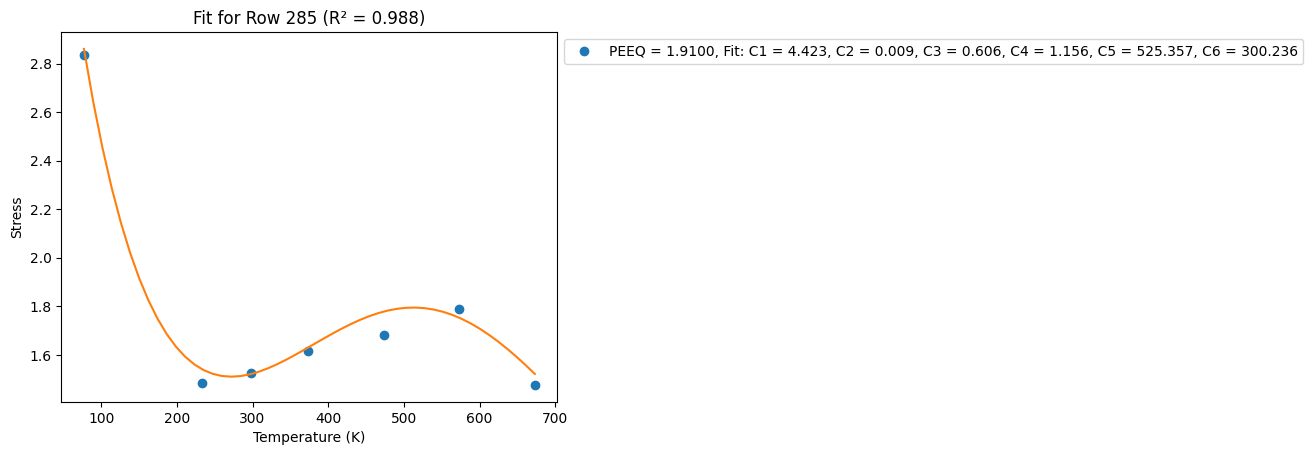

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


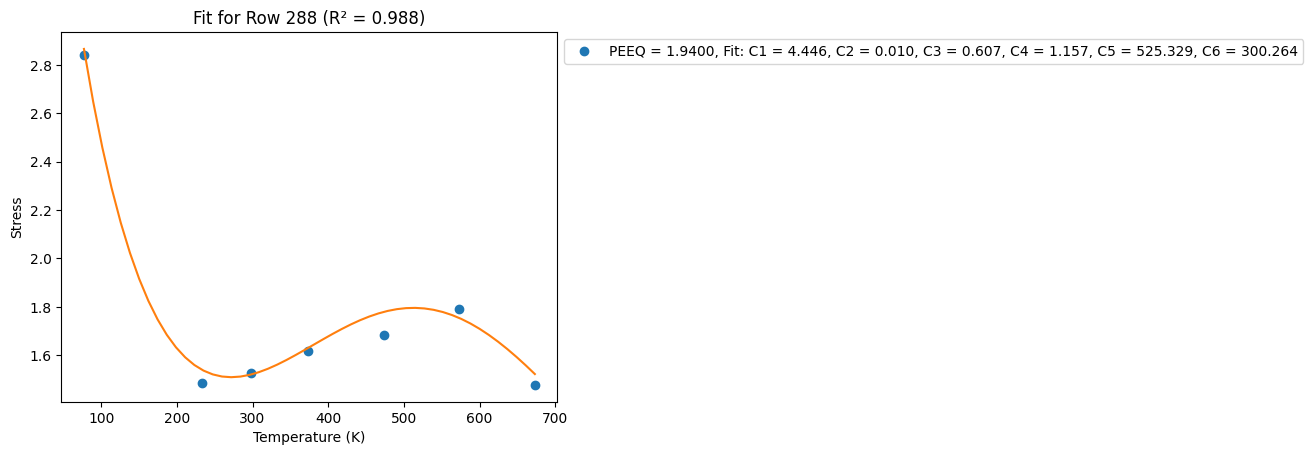

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


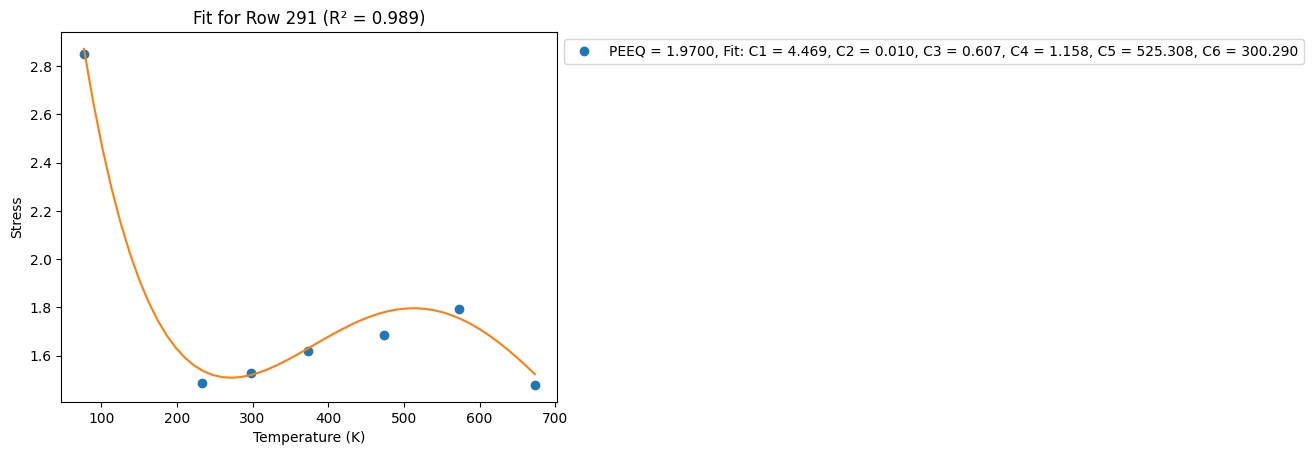

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


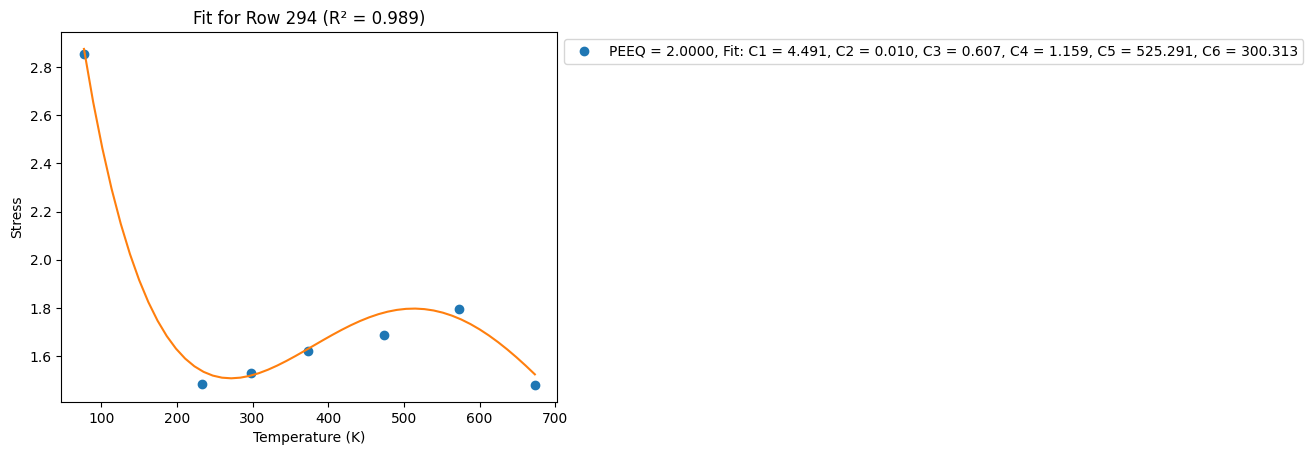

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


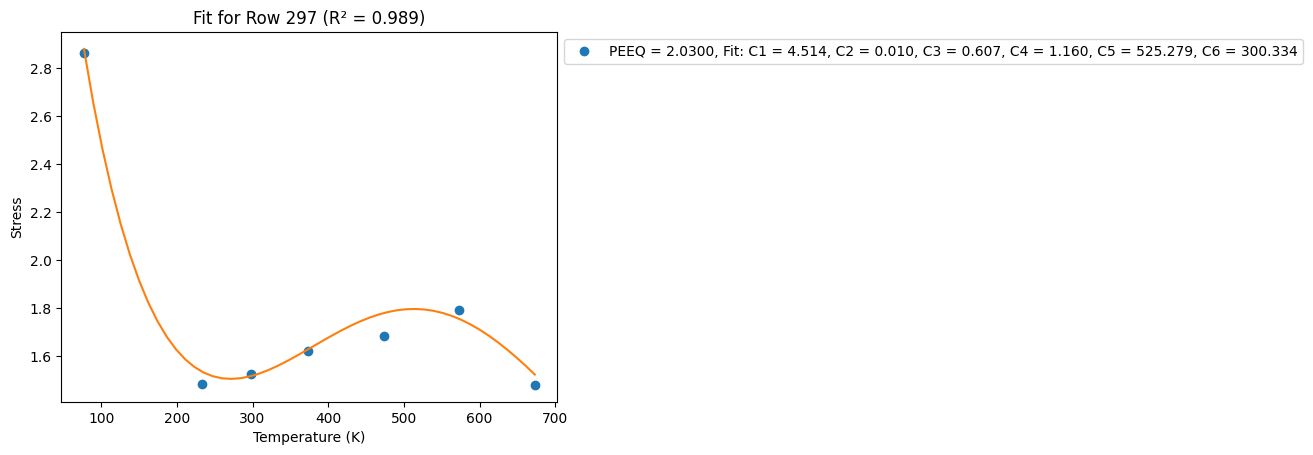

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


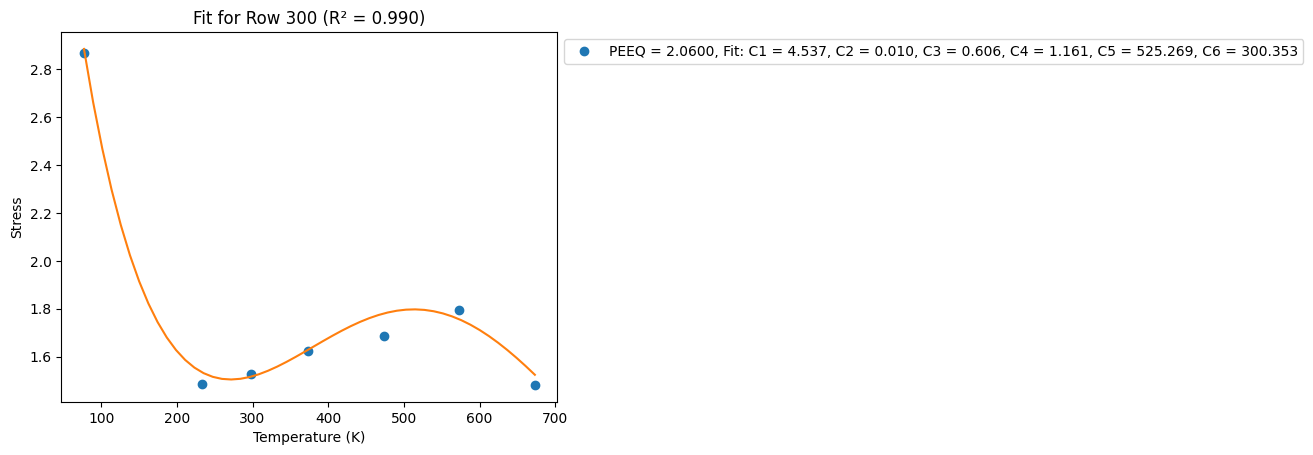

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


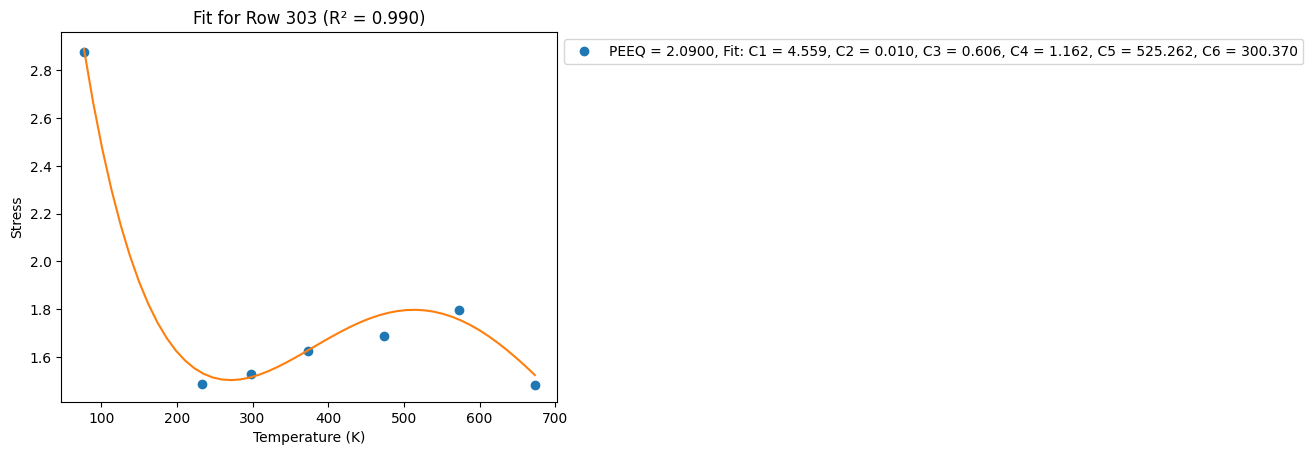

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


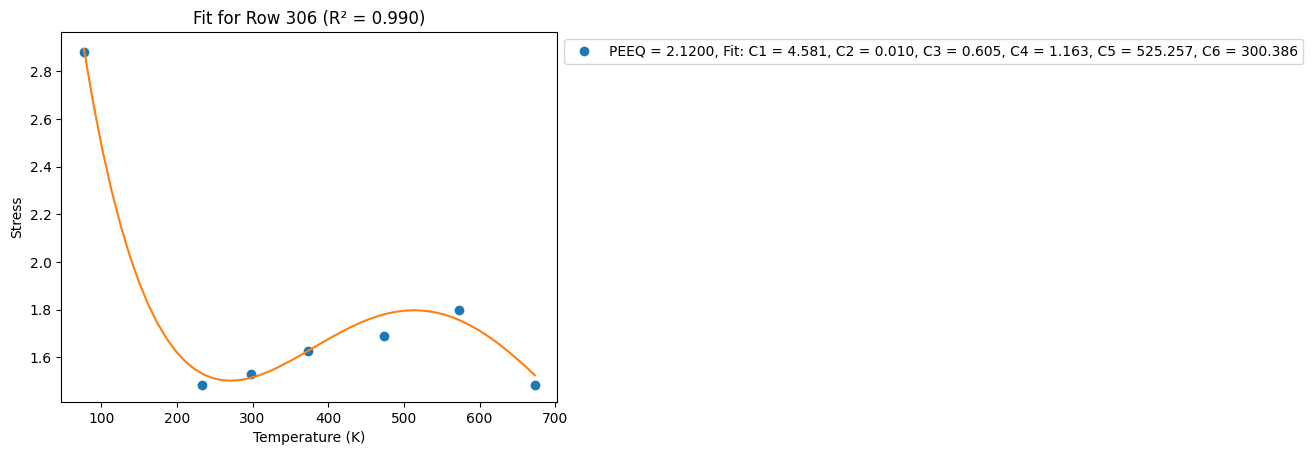

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


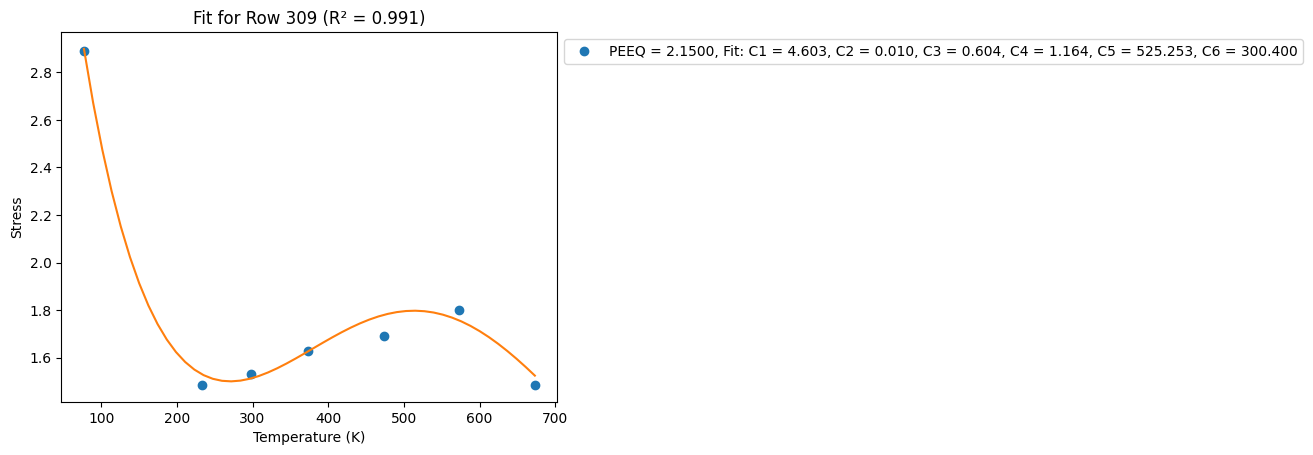

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


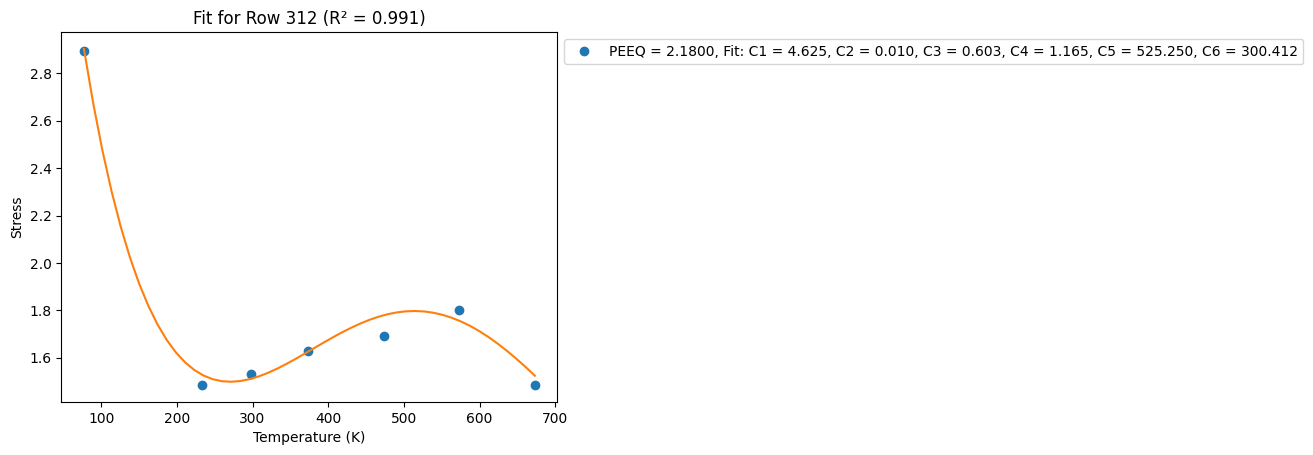

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


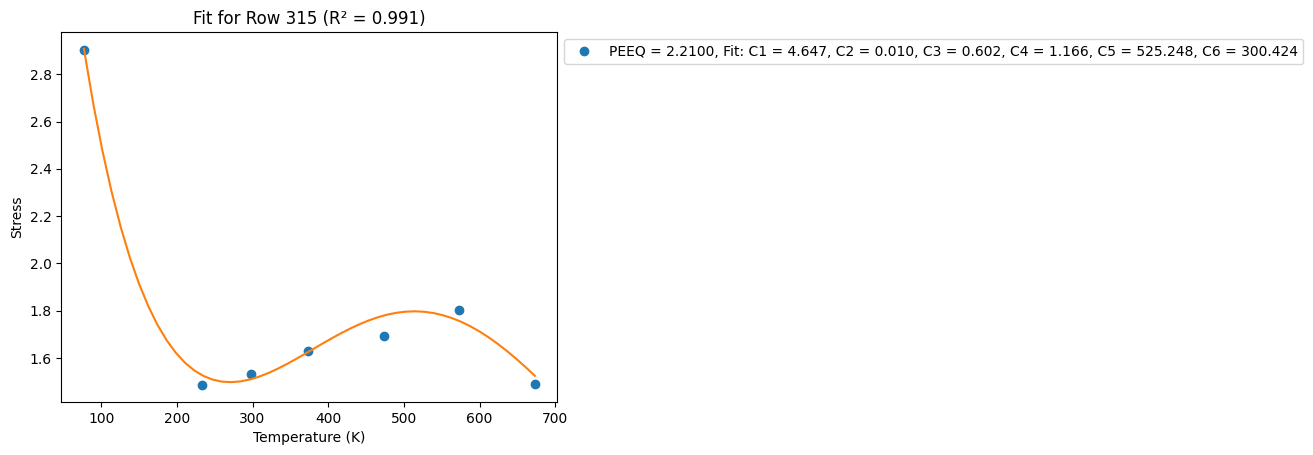

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


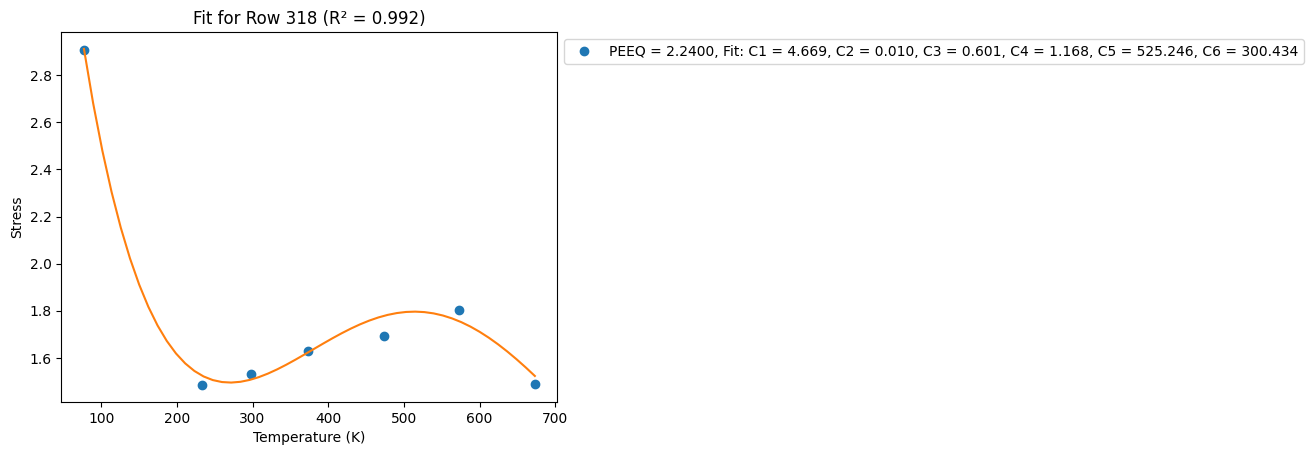

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


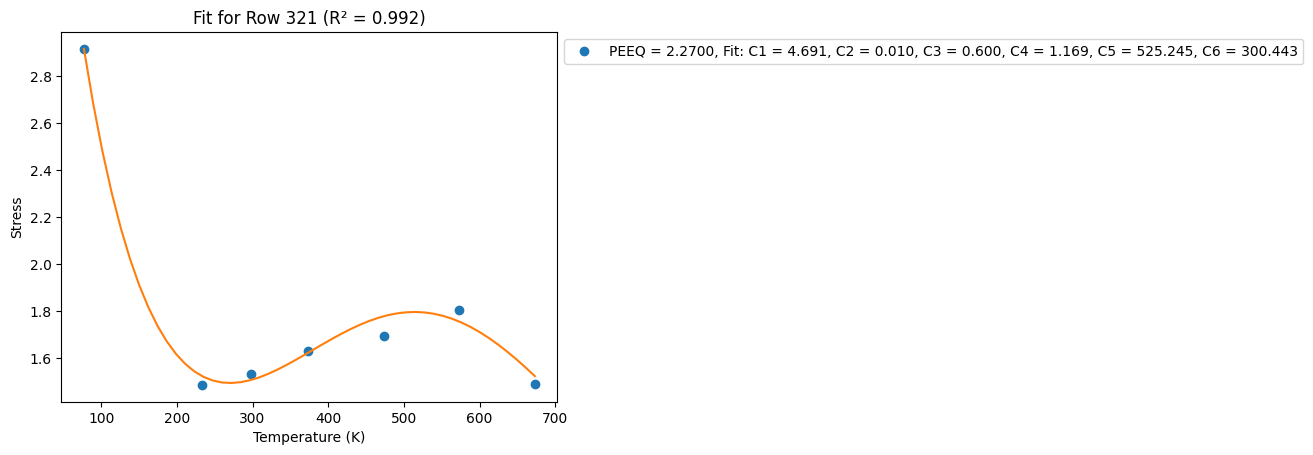

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


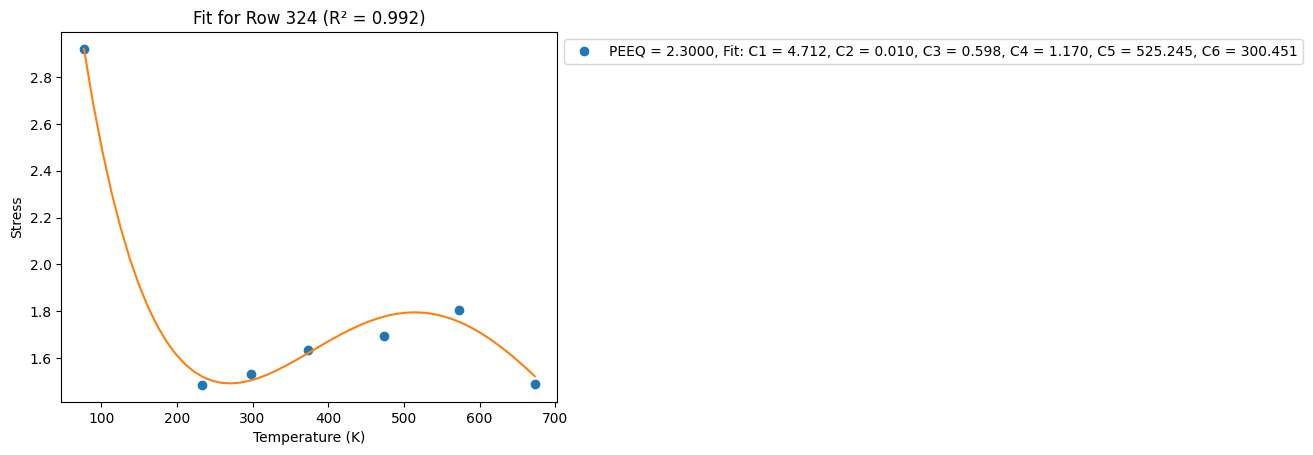

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


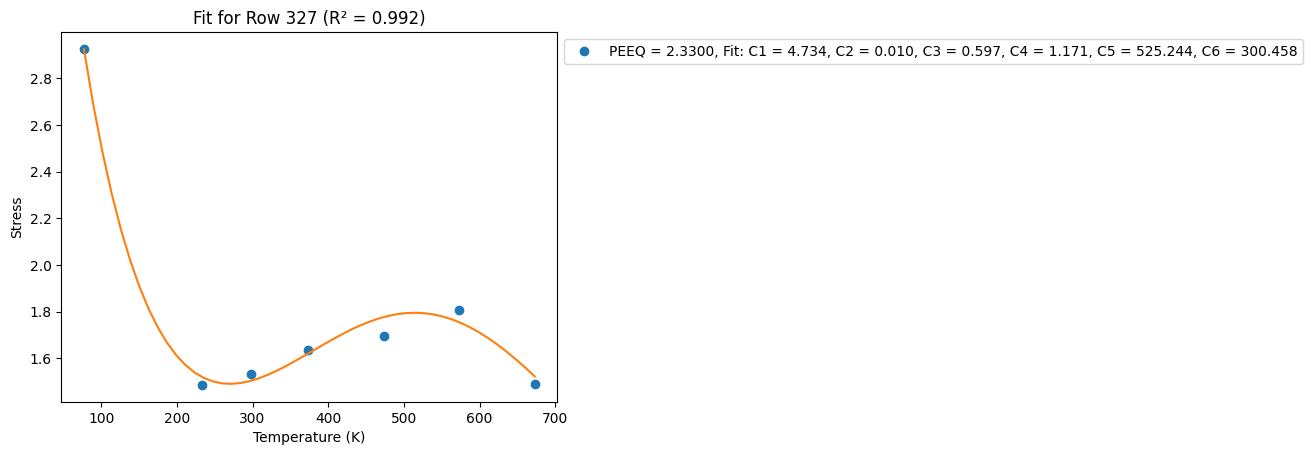

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


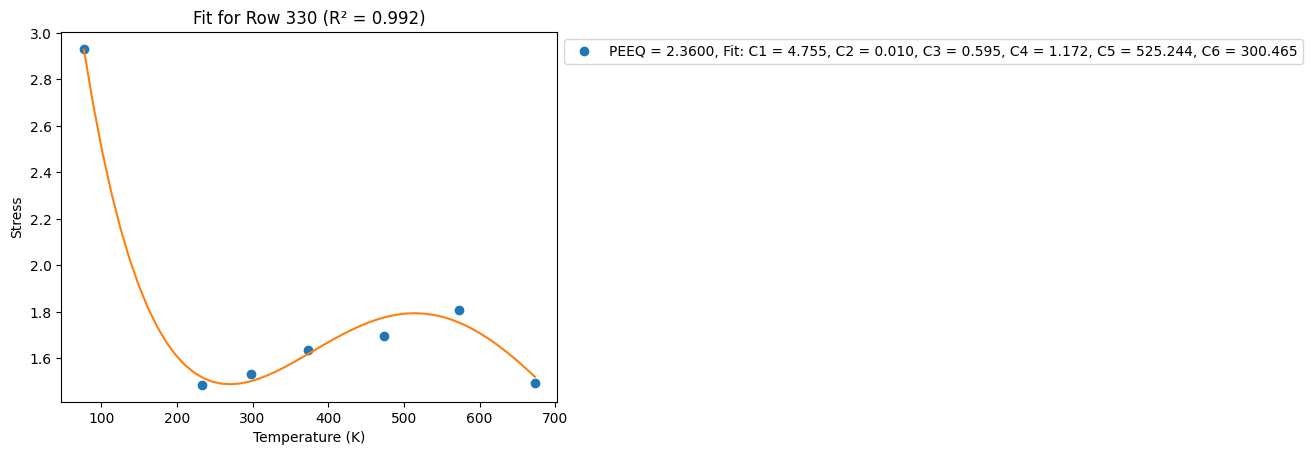

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


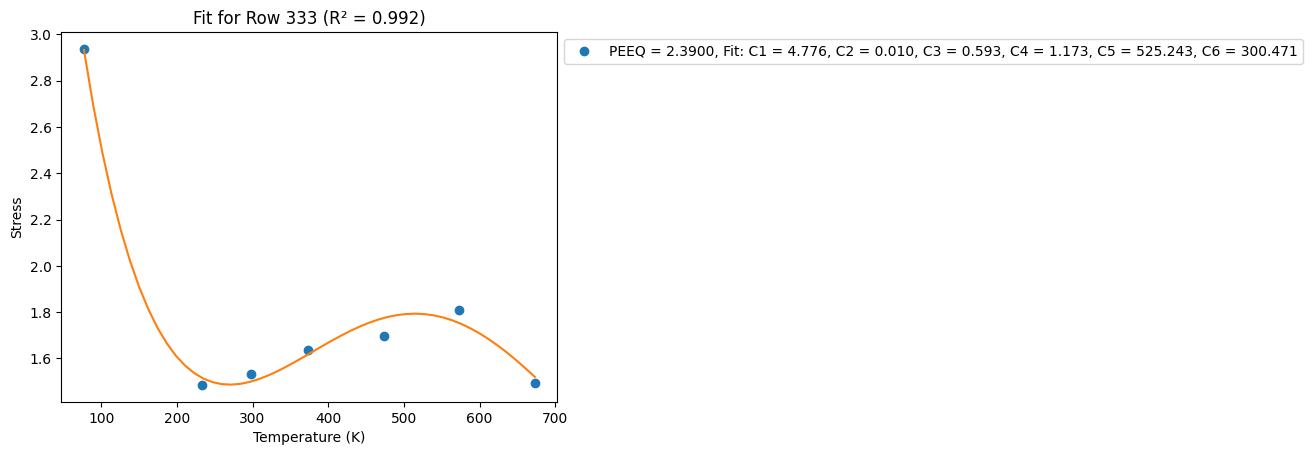

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


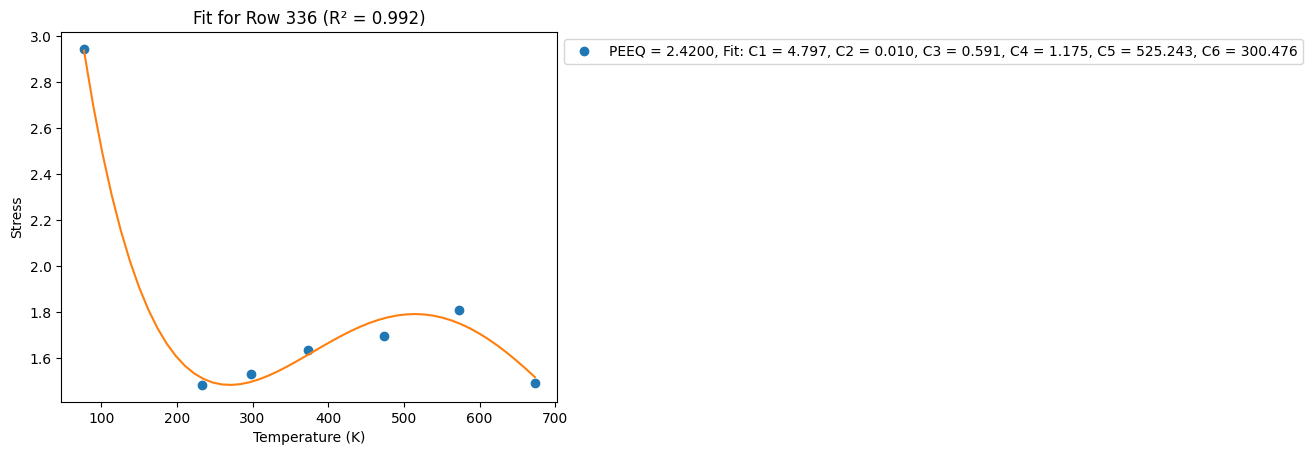

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


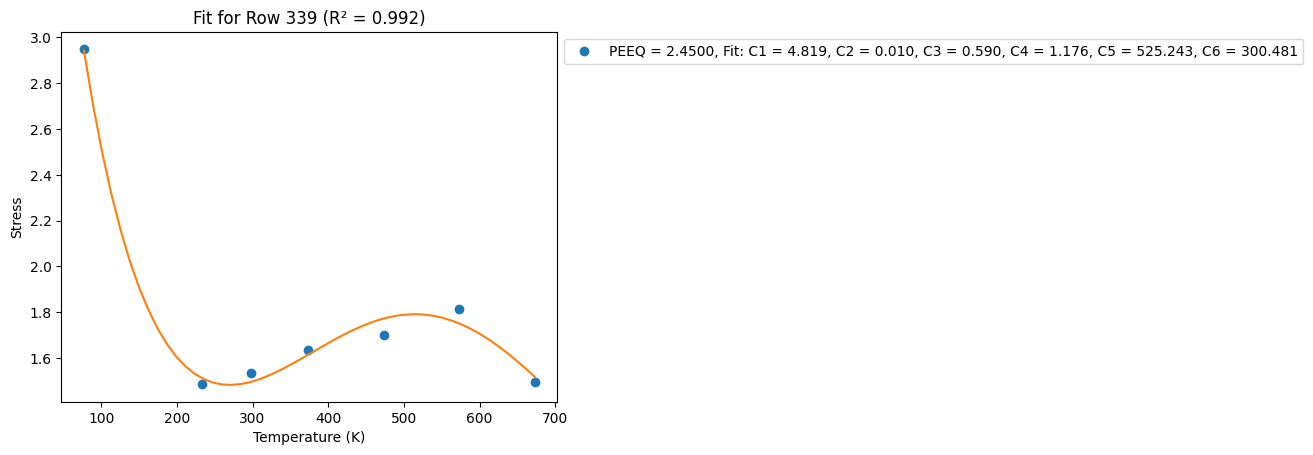

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


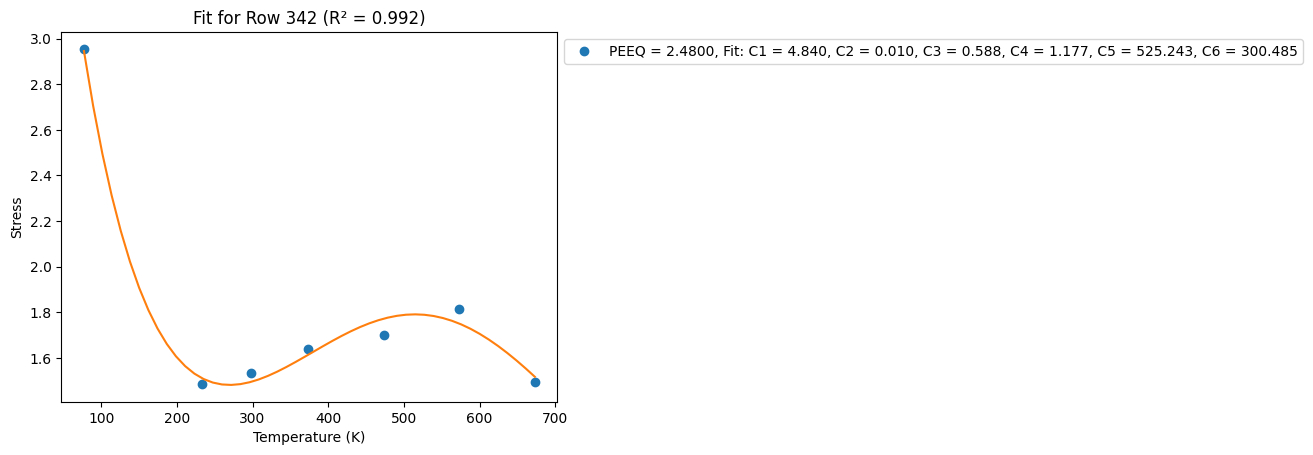

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


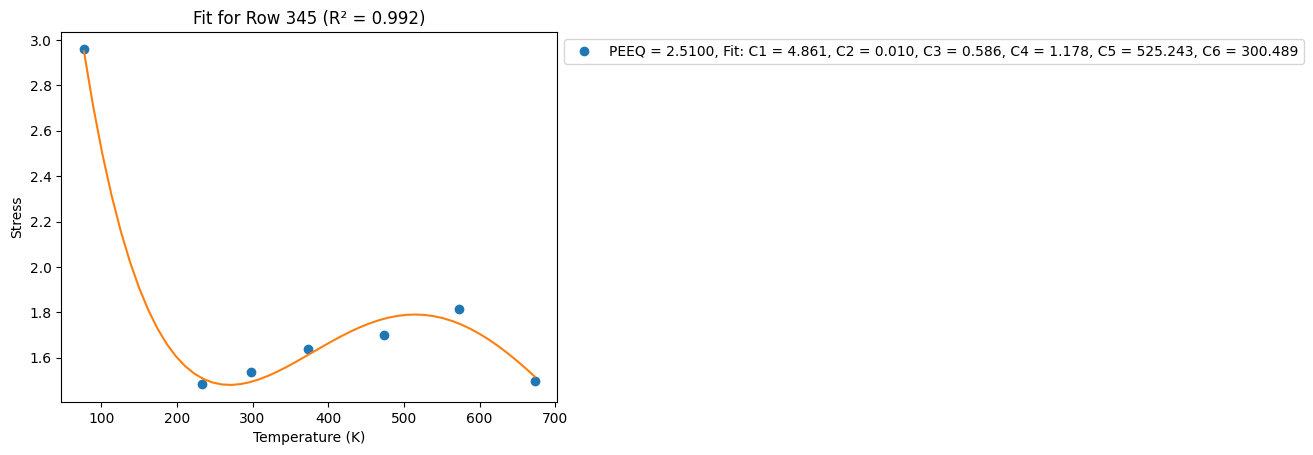

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


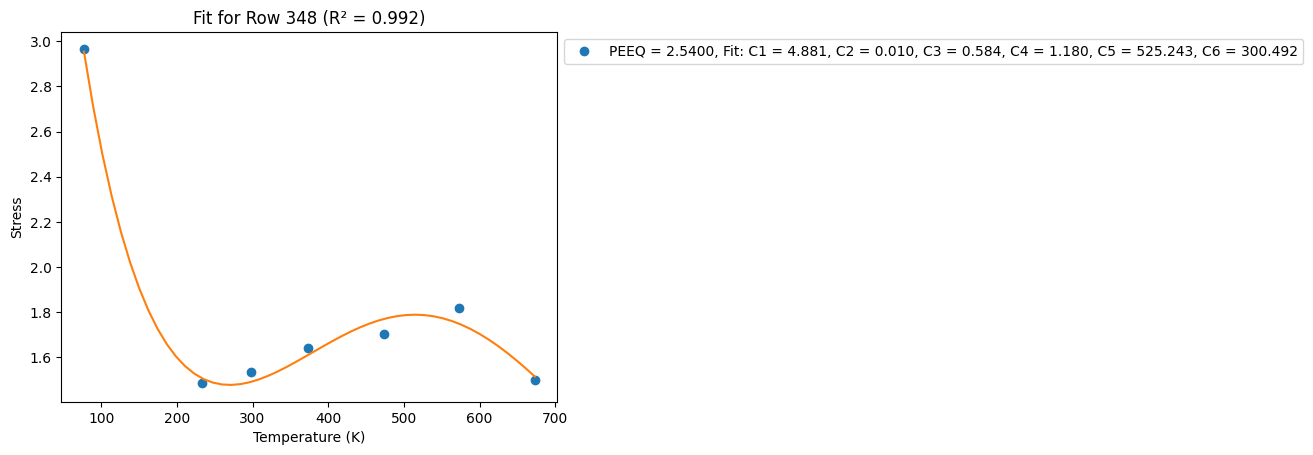

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


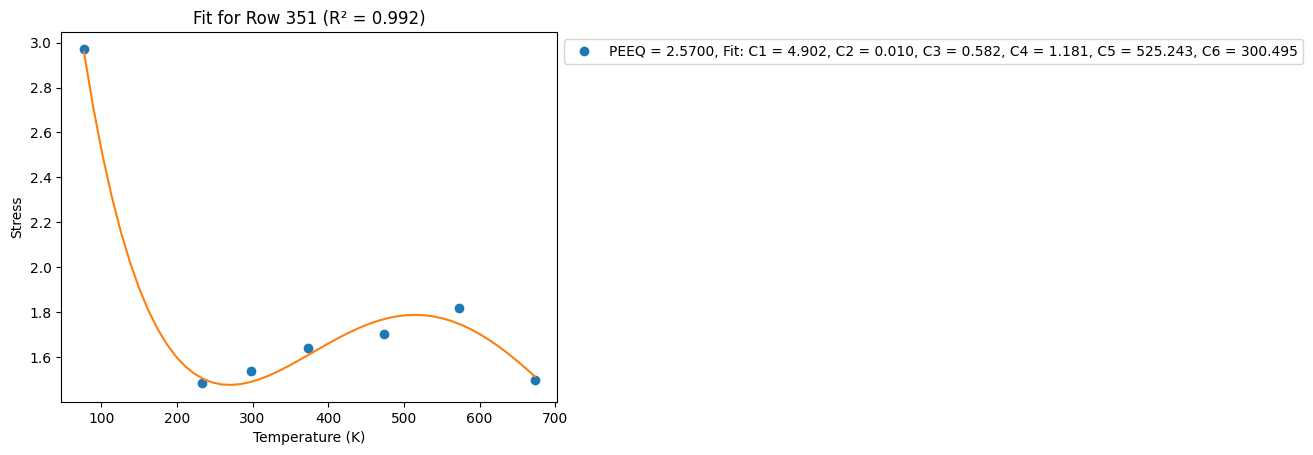

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


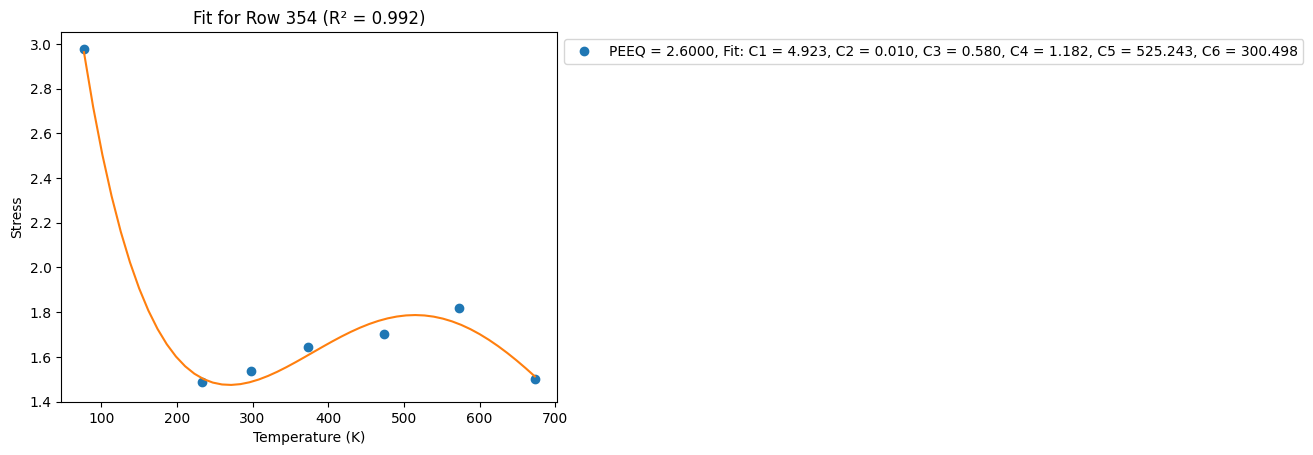

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


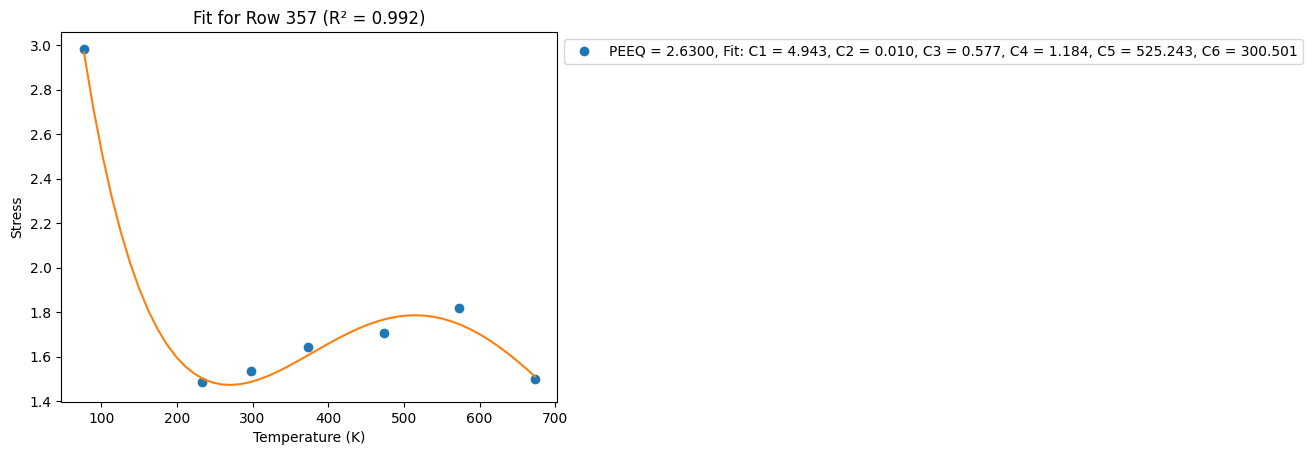

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


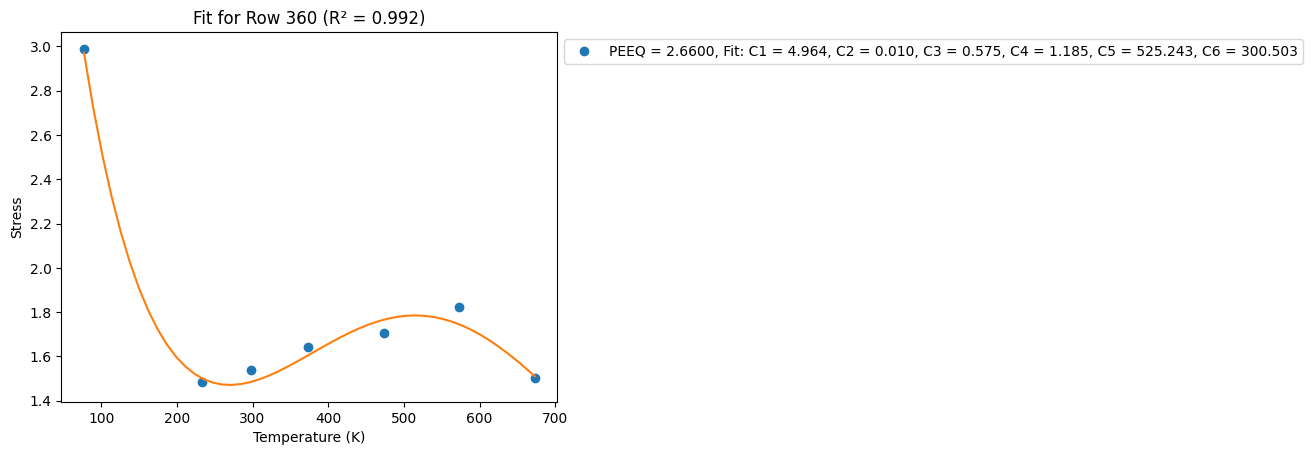

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


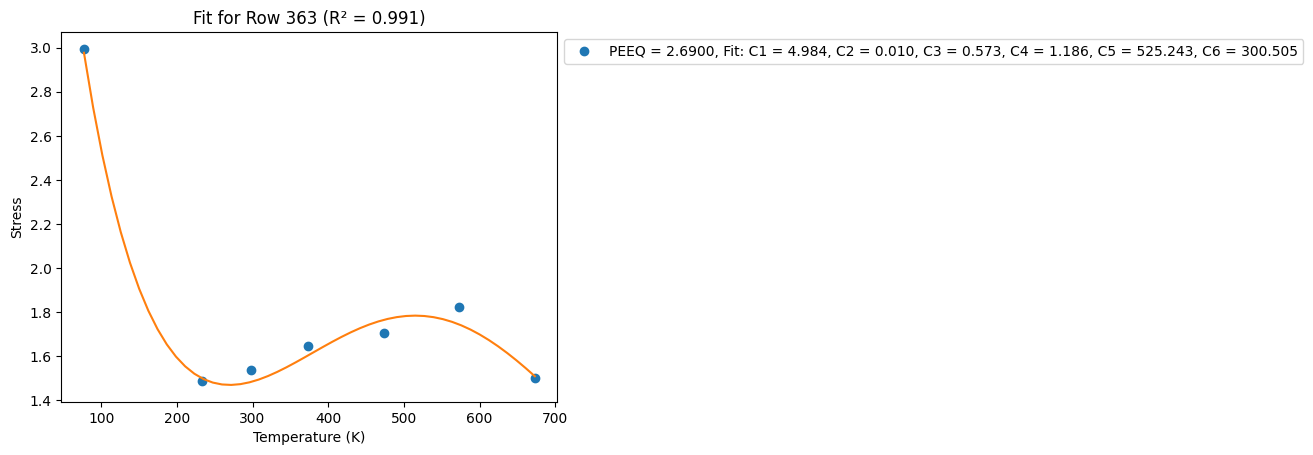

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


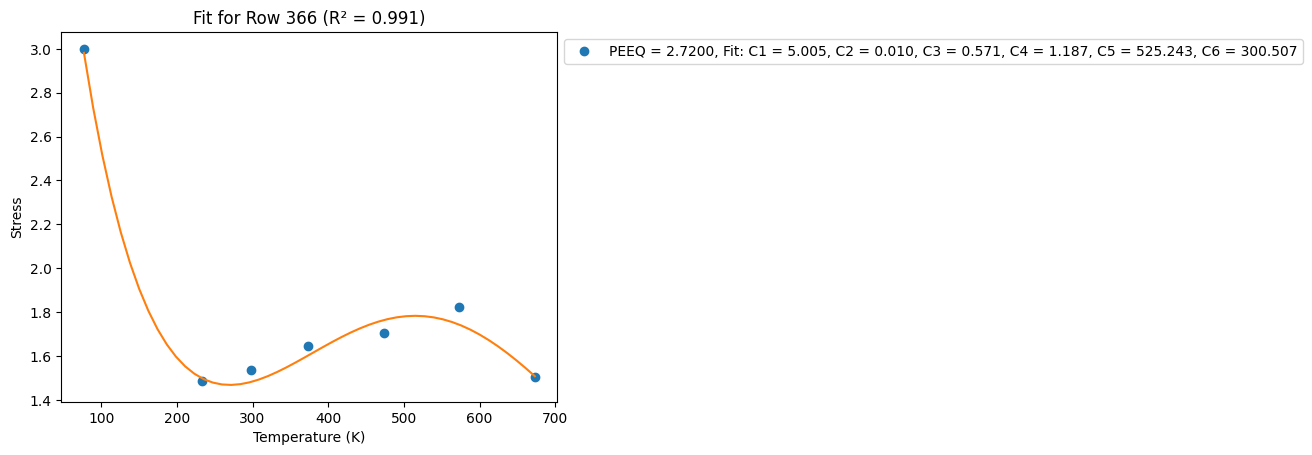

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


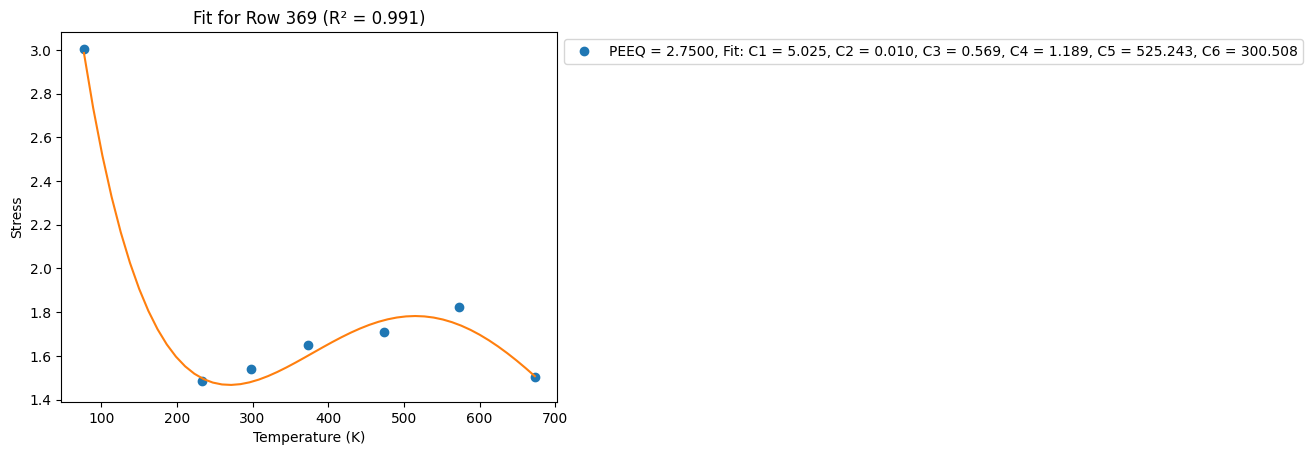

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


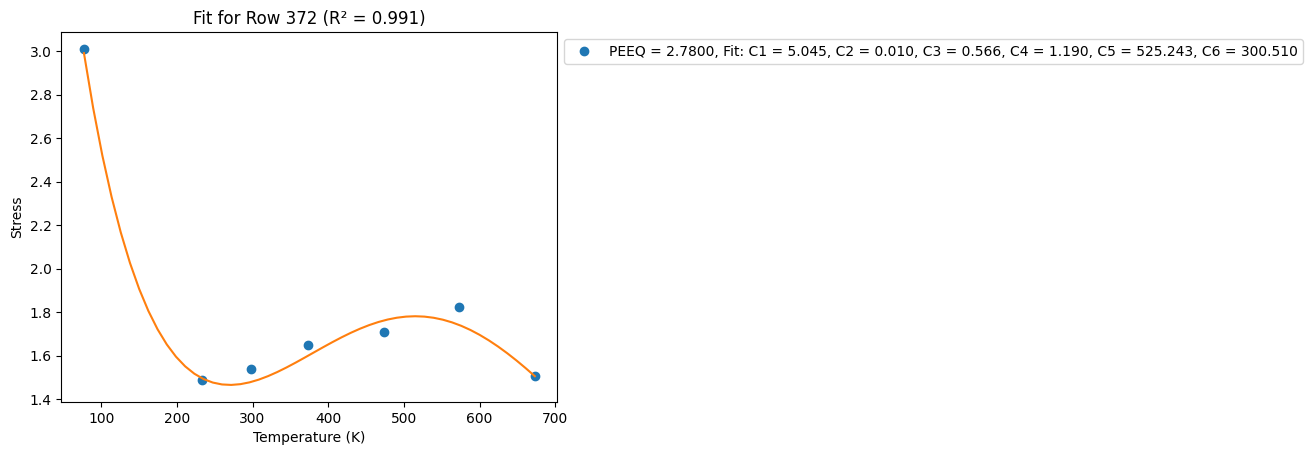

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


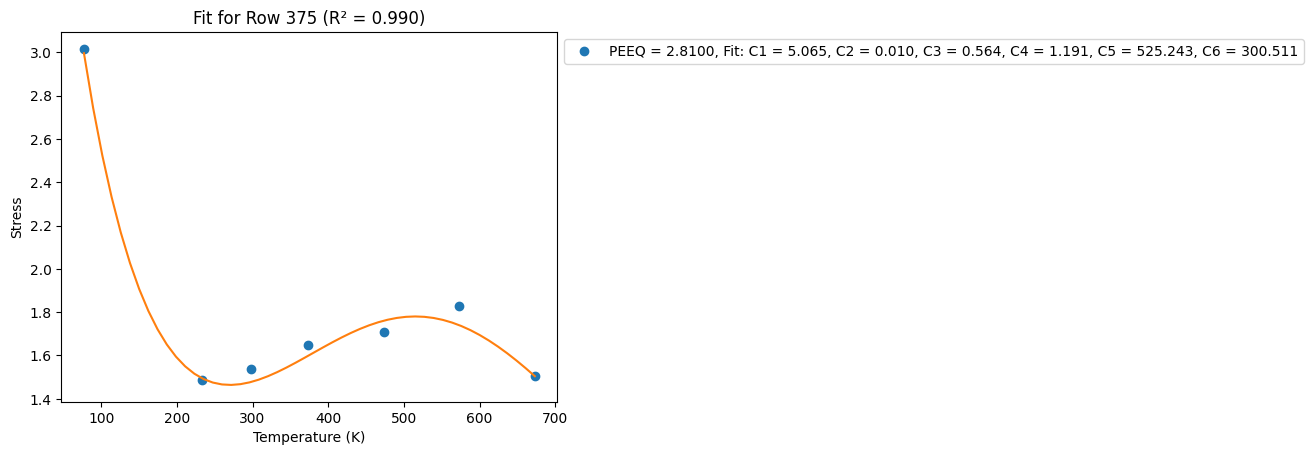

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


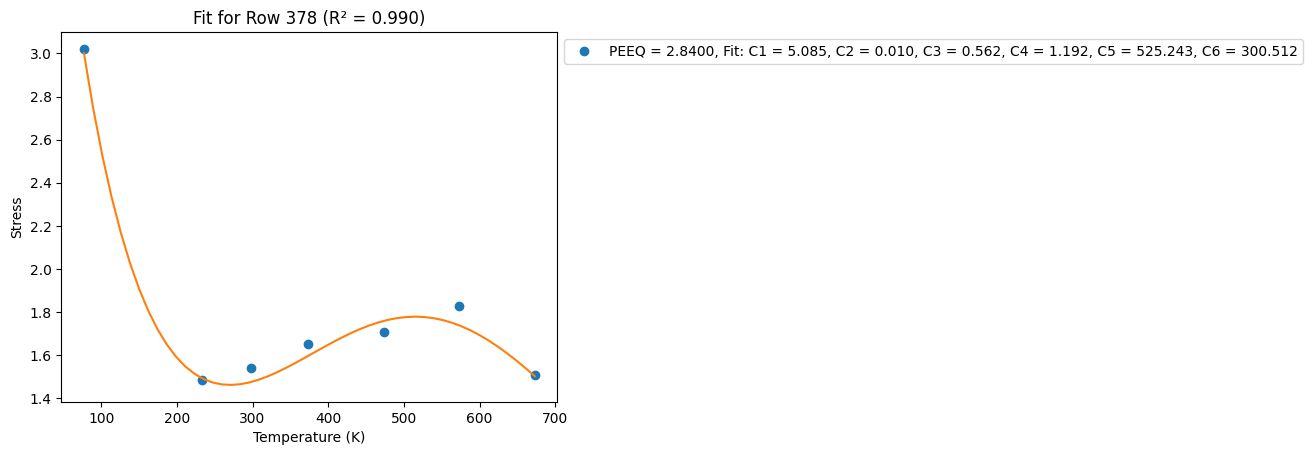

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


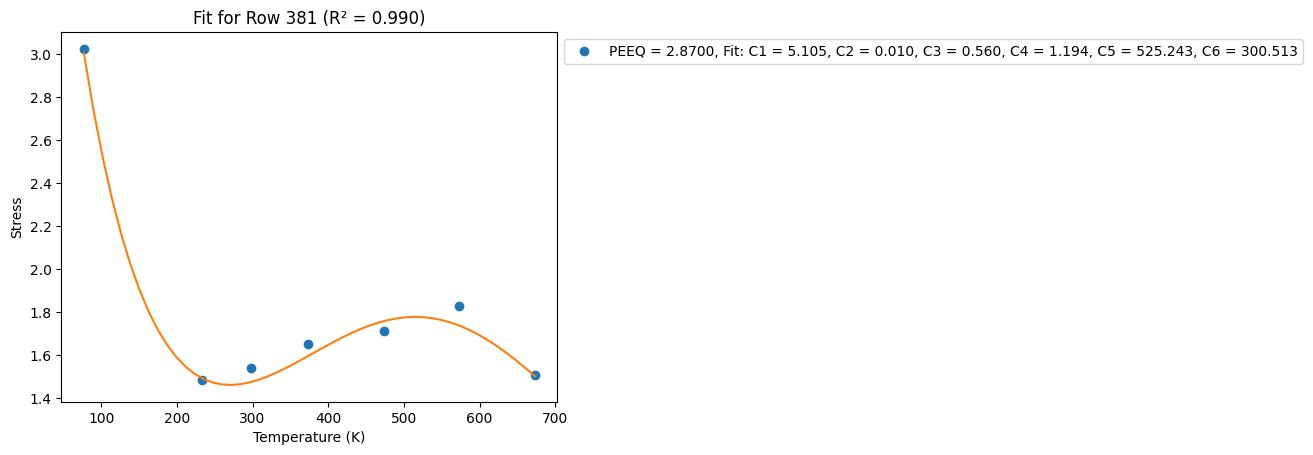

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


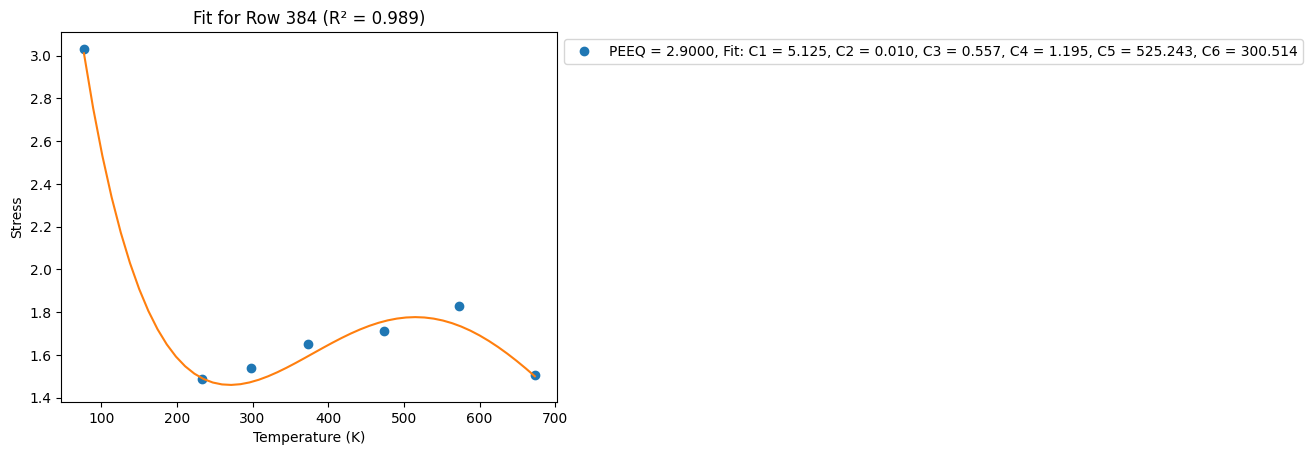

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


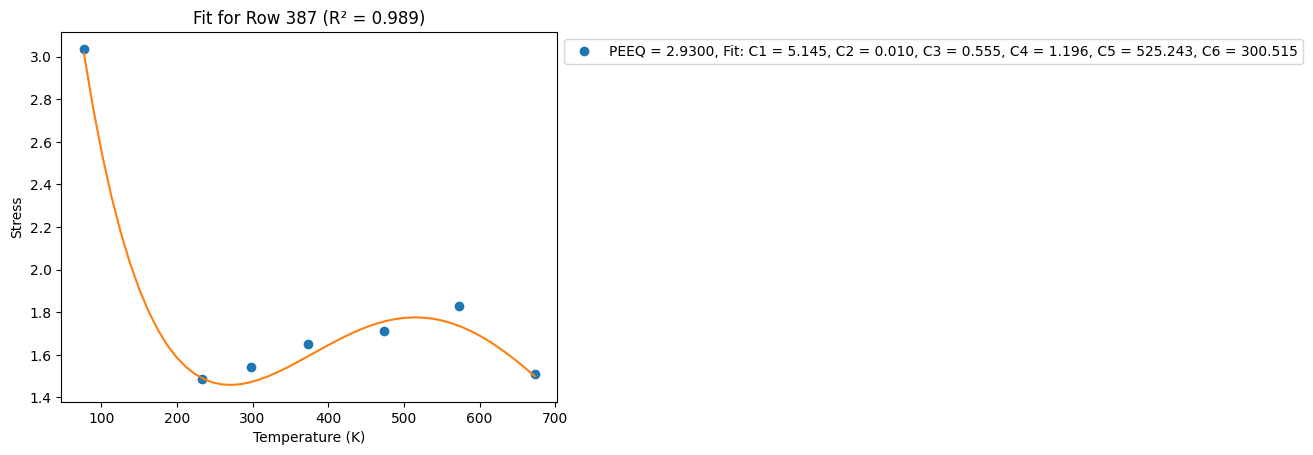

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


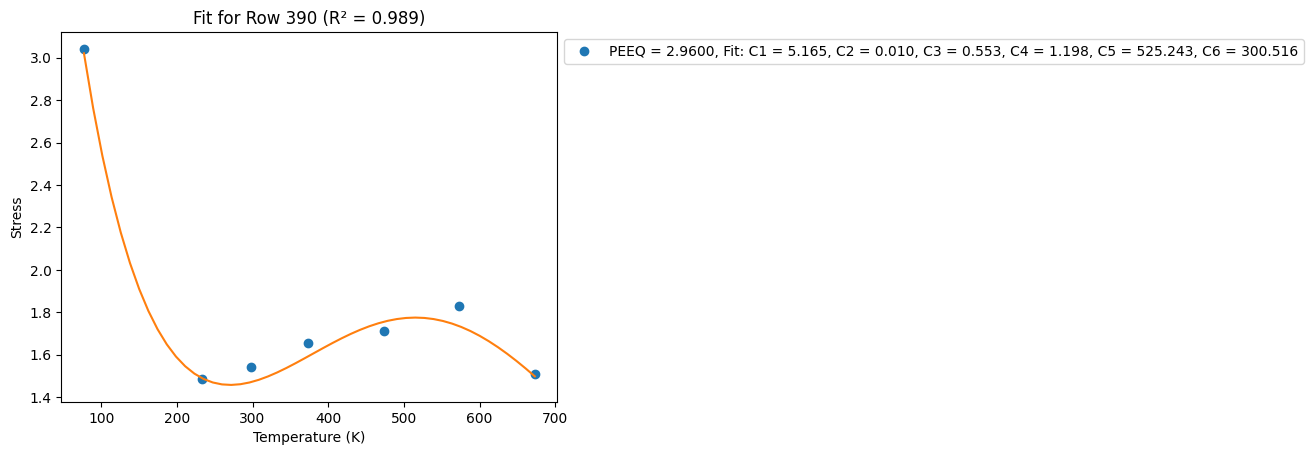

C:\Users\meian\AppData\Local\Temp\ipykernel_7496\1114181692.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


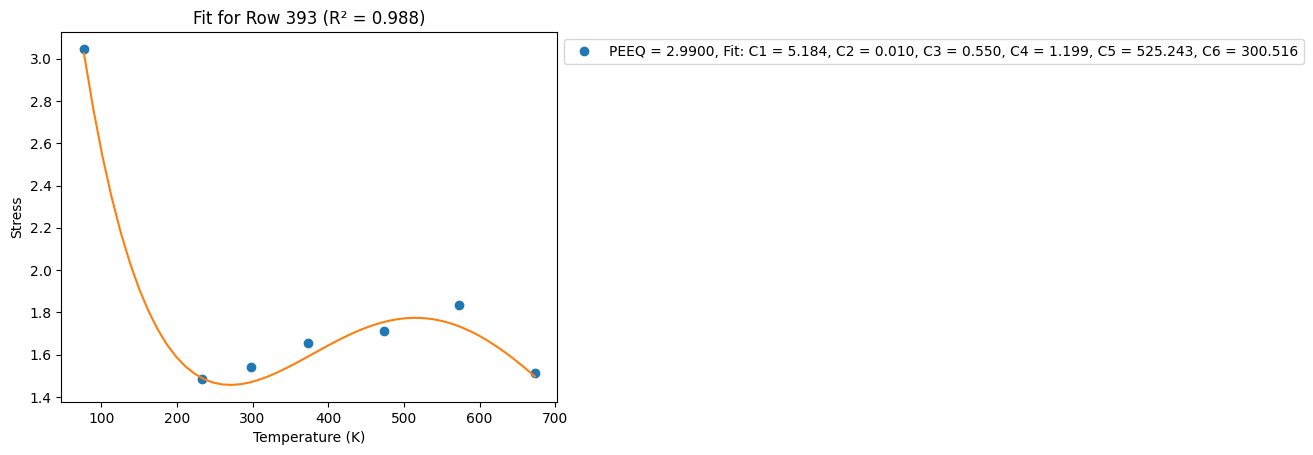

In [10]:
# Temperarute data points
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])

# Temperature function
def f_func(T, cT1, cT2, cT3, cT4, cT5, cT6):
    return cT1*(np.exp(-cT2*T))+cT3+cT4*(np.exp(-((T-cT5)/cT6)**2))

#for j, i in enumerate(np.arange(0, 394, 3)):
for j, i in enumerate([0, 3, 6, 9, 12, 36, 39, 42, 45, 48, 51,
         54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105,
         108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 
         153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 
         198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 
         243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 282, 285, 
         288, 291, 294, 297, 300, 303, 306, 309, 312, 315, 318, 321, 324, 327, 330, 
         333, 336, 339, 342, 345, 348, 351, 354, 357, 360, 363, 366, 369, 372, 375,
         378, 381, 384, 387, 390, 393]):
    T_fit = np.linspace(np.min(T), np.max(T), 50)
    [C1, C2, C3, C4, C5, C6] = fitted_para.iloc[i, 1:]
    y = stress_data.iloc[i, 8:].values
    gaussian_fit = f_func(T_fit, C1, C2, C3, C4, C5, C6)

    # Calculate residuals for error estimation
    y_pred = f_func(T, C1, C2, C3, C4, C5, C6)
    r_squared = r2_score(y, y_pred)

    plt.plot(T, y, 'o', T_fit, gaussian_fit)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Stress")
    plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
    plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
else:
    str(0)